# **Configuration and Utilities**

In [427]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from torchsummary import summary
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.colors as colors

In [516]:
# Import and mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [429]:
def load_data_from_files(file_base_name, drive_path, net):
  '''
    Loads training and testing results from text files stored in a Google Drive folder for a specific network.

  '''

  path = f'/content/drive/MyDrive/Colab Notebooks/{drive_path}/{net}/'

  total_path_train = path + file_base_name + "_train.txt"
  total_path_test = path + file_base_name + "_test.txt"

  dataframes = {
      "train": pd.read_csv(total_path_train, skiprows=2),
      "test": pd.read_csv(total_path_test, skiprows=2)
  }

  return dataframes

In [430]:
def filter_by_epoch(df_train, df_test, epoch_value):
  '''
    Filters training and testing DataFrames to include only the rows corresponding to a specific epoch.

  '''
  df_train_filtered = df_train[df_train["epochs"] == epoch_value]
  df_test_filtered = df_test[df_test["epochs"] == epoch_value]

  return df_train_filtered, df_test_filtered

In [431]:
def filter_by_model(df_train, df_test, model_value):
  '''
    Filters training and testing DataFrames to include only the rows corresponding to a specific model configuration.

  '''
  df_train_filtered = df_train[df_train["units"] == model_value]
  df_test_filtered = df_test[df_test["units"] == model_value]

  return df_train_filtered, df_test_filtered

In [432]:
def plot_simple_train_test_metrics(df_train, df_test, interpolation_threshold=None, xlabel="units", title=""):
  '''
    Plots training and testing loss and error metrics side by side.

  '''

  # Configure seaborn for better style
  sns.set(style="whitegrid", context="notebook", font_scale=1.6)

  # Create a figure with 2 subplots side by side (for loss (left) and error (right))
  fig, axes = plt.subplots(1, 2, figsize=(20, 6))

  for ax, metric in zip(axes, ["loss", "error"]):
    metric_title = metric.title()

    # Plot training metric (dashed blue line)
    ax.plot(df_train[xlabel], df_train[f"train_{metric}"], label=f"Train {metric_title}", color='blue', linestyle="--", linewidth=4)

    # Plot test metric (solid orange line)
    ax.plot(df_test[xlabel], df_test[f"test_{metric}"], label=f"Test {metric_title}", color='orange', linewidth=4)

    # Optionally add a vertical dashed line for interpolation threshold
    if interpolation_threshold is not None:
        ax.axvline(x=interpolation_threshold, label="Interpolation Threshold", color='black', linestyle='dotted', linewidth=4)

    if xlabel == "epochs":
        ax.set_xscale('log')

    ax.set_xlabel("Units" if xlabel == "units" else "Epochs", fontsize=30)
    ax.set_ylabel(metric_title, fontsize=30)

    ax.legend(fontsize=28, loc="best")
    ax.grid(True, linestyle='--', alpha=0.6, linewidth=3)
    ax.tick_params(axis='both', labelsize=24)

  # fig.suptitle(f"Train and Test metrics by {xlabel} {title}", fontweight="bold", fontsize=25)

  plt.tight_layout()
  plt.show()

In [433]:
def plot_train_test_error_heatmap(df_result_train, df_result_test, threshold_value=0.01, colormap="viridis", gamma=0.8, xlabel="Units", ylabel="Epochs", title=""):
  '''
    Plots heatmaps side by side for train and test error across a grid of model sizes and epochs.

  '''

  # Reset matplotlib and seaborn settings to defaults
  mpl.rcParams.update(mpl.rcParamsDefault)
  sns.reset_defaults()

  mpl.rc('axes', titlesize=18)
  mpl.rc('axes', labelsize=18)
  mpl.rc('xtick', labelsize=24)
  mpl.rc('ytick', labelsize=24)

  # Create two subplots: first for test error, second for train error
  fig, axes = plt.subplots(1, 2, figsize=(20, 6))

  # TEST ERROR HEATMAP
  pivot_table_test = df_result_test.pivot(index="epochs", columns="units", values="test_error")
  norm_test = colors.PowerNorm(gamma=gamma, vmin=df_result_test["test_error"].min(), vmax=df_result_test["test_error"].max())

  cax_test = axes[0].pcolormesh(pivot_table_test.columns, pivot_table_test.index, pivot_table_test.values, cmap=colormap, norm=norm_test, shading="auto")

  axes[0].set_yscale("log")
  axes[0].set_ylim(1, df_result_test["epochs"].max())
  fig.colorbar(cax_test, ax=axes[0])

  axes[0].set_xlabel(xlabel, fontsize=28)
  axes[0].set_ylabel(ylabel, fontsize=28)
  axes[0].set_title("Test Error", fontsize=32)

  # TRAIN ERROR HEATMAP
  pivot_table_train = df_result_train.pivot(index="epochs", columns="units", values="train_error")
  norm_train = colors.PowerNorm(gamma=gamma, vmin=df_result_train["train_error"].min(), vmax=df_result_train["train_error"].max())

  cax_train = axes[1].pcolormesh(pivot_table_train.columns, pivot_table_train.index, pivot_table_train.values, cmap=colormap, norm=norm_train, shading="auto")

  axes[1].set_yscale("log")
  axes[1].set_ylim(1, df_result_train["epochs"].max())
  fig.colorbar(cax_train, ax=axes[1])

  axes[1].set_xlabel(xlabel, fontsize=28)
  axes[1].set_ylabel(ylabel, fontsize=28)
  axes[1].set_title("Train Error", fontsize=32)

  # ANNOTATIONS FOR DOUBLE DESCENT
  midpoint_x = pivot_table_test.columns[len(pivot_table_test.columns) // 2]
  midpoint_y = pivot_table_test.index[len(pivot_table_test.index) // 2]

  arrow_style = dict(arrowstyle="fancy", color='white', linewidth=3, mutation_scale=20)

  axes[0].plot([midpoint_x + (midpoint_x/1.5), midpoint_x + (midpoint_x/1.5)], [pivot_table_test.index.min(), pivot_table_test.index.max() * 0.95], 'w--', linewidth=4)
  axes[0].annotate("", xy=(midpoint_x + (midpoint_x/1.5), pivot_table_test.index.max()*0.98), xytext=(midpoint_x + (midpoint_x/1.5), pivot_table_test.index.max() * 0.95), arrowprops=arrow_style)
  axes[0].text(midpoint_x + (midpoint_x/3), midpoint_y * 0.2, "Epoch-wise\nDouble Descent", color='white', fontsize=18, fontweight='bold', ha="center", va="center")

  axes[0].plot([pivot_table_test.columns.min(), pivot_table_test.columns.max() * 0.99], [midpoint_y, midpoint_y], 'w--', linewidth=4)
  axes[0].annotate("", xy=(pivot_table_test.columns.max(), midpoint_y), xytext=(pivot_table_test.columns.max() * 0.99, midpoint_y), arrowprops=arrow_style)
  axes[0].text(pivot_table_test.columns.min() + (midpoint_x/3), midpoint_y * 0.5, "Model-wise\nDouble Descent", color='white', fontsize=18, fontweight='bold', ha="center", va="center")

  # INTERPOLATION THRESHOLD
  x_values = []
  y_values = []

  for unit in pivot_table_train.columns:
      first_zero_epoch = pivot_table_train[unit][pivot_table_train[unit] <= threshold_value].index.min()
      if not pd.isna(first_zero_epoch):
          x_values.append(unit)
          y_values.append(first_zero_epoch)

  axes[1].plot(x_values, y_values, '--', color='white', linewidth=4)

  if len(x_values) > 0:
      axes[1].text(x_values[5], y_values[0] * 0.3, "Interpolation\n  Threshold", color='white', fontsize=18, fontweight='bold')

  # fig.suptitle(f"Train and Test Error by {xlabel.capitalize()} and Epochs {title}", fontweight="bold", fontsize=20, ha='center')

  plt.tight_layout()
  plt.show()

# **Global Variables**

In [434]:
# Defines the path to the folder where the results files are stored on Google Drive
drive_path = "Deep Double Descent"

# **2NN**

In [435]:
class TwoLayerNN(nn.Module):
  def __init__(self, input_size, size=1, num_classes=10):
    super(TwoLayerNN, self).__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(input_size, size)
    self.fc2 = nn.Linear(size, num_classes)

  def forward(self, x):
    x = self.flatten(x)
    x = torch.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [436]:
model = TwoLayerNN(input_size=28*28, size=100, num_classes=10)

input = (1, 28, 28)
summary(model, input)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
            Linear-3                   [-1, 10]           1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.30
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [437]:
net = "2NN"

## **Appendix**

### **Different batch sizes**

In [438]:
file_base_name1 = 'simple2NN_mnist4k_010noise_noda_32bs'
dataframes1 = load_data_from_files(file_base_name1, drive_path, net)

file_base_name2 = 'simple2NN_mnist4k_010noise_noda_64bs'
dataframes2 = load_data_from_files(file_base_name2, drive_path, net)

file_base_name3 = 'simple2NN_mnist4k_010noise_noda_128bs'
dataframes3 = load_data_from_files(file_base_name3, drive_path, net)

file_base_name4 = 'simple2NN_mnist4k_010noise_noda_256bs'
dataframes4 = load_data_from_files(file_base_name4, drive_path, net)

df_train1 = dataframes1["train"]
df_test1 = dataframes1["test"]
df_train2 = dataframes2["train"]
df_test2 = dataframes2["test"]
df_train3 = dataframes3["train"]
df_test3 = dataframes3["test"]
df_train4 = dataframes4["train"]
df_test4 = dataframes4["test"]

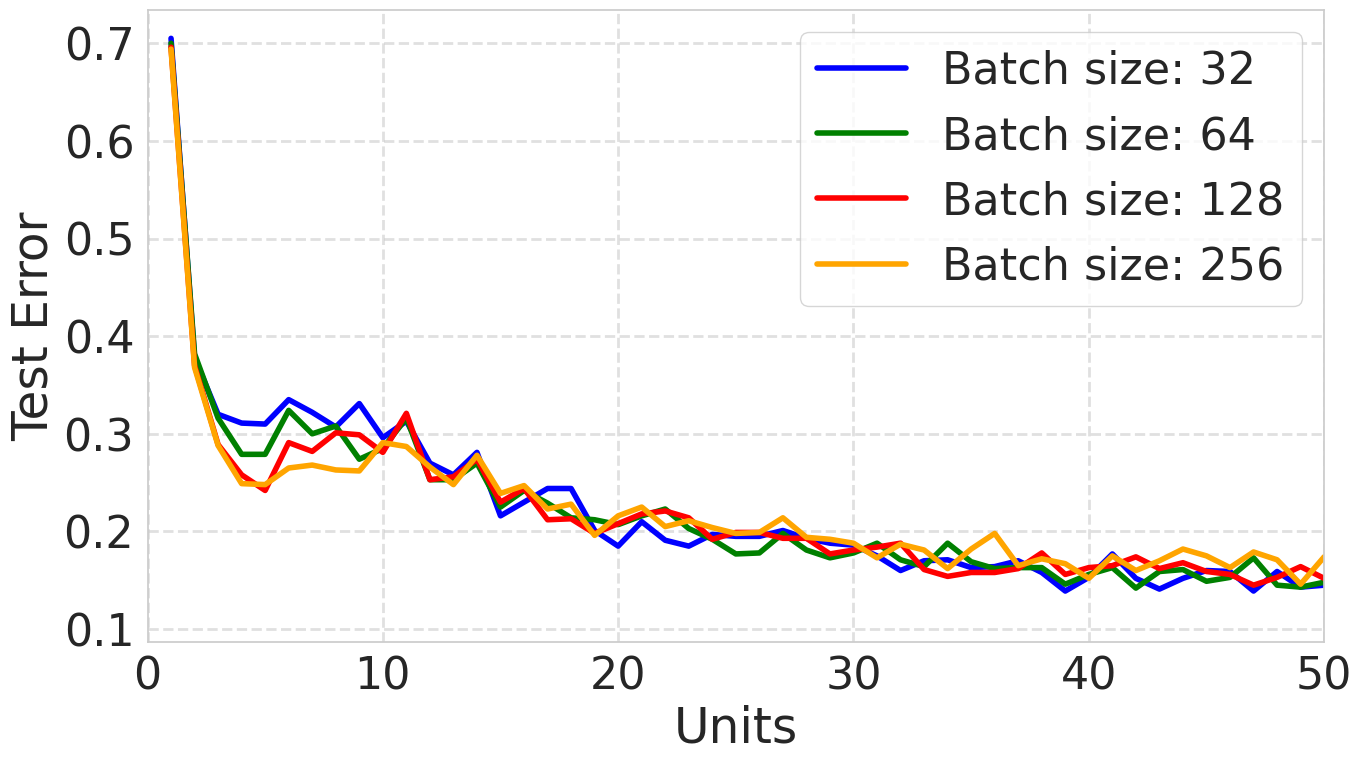

In [439]:
sns.set(style="whitegrid", context="notebook", font_scale=1.6)
plt.figure(figsize=(14, 8))

plt.plot(df_test1["units"], df_test1["test_error"], label="Batch size: 32", color="blue", linewidth=4)
plt.plot(df_test2["units"], df_test2["test_error"], label="Batch size: 64", color="green", linewidth=4)
plt.plot(df_test3["units"], df_test3["test_error"], label="Batch size: 128", color="red", linewidth=4)
plt.plot(df_test4["units"], df_test4["test_error"], label="Batch size: 256", color="orange", linewidth=4)

plt.xlabel("Units", fontsize=35)
plt.ylabel("Test Error", fontsize=35)

plt.xlim(0, 50)
plt.legend(fontsize=32, loc="best")

plt.grid(True, linestyle='--', alpha=0.6, linewidth=2)

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)

# plt.title("Test error by units (2NN, MNIST ([4000/1000] & 10% label noise))", fontsize=18, fontweight="bold")

plt.tight_layout()
plt.show()

### **Different learning rates**

In [440]:
file_base_name1 = 'simple2NN_mnist4k_010noise_noda_256bs_00005lr'
dataframes1 = load_data_from_files(file_base_name1, drive_path, net)

file_base_name2 = 'simple2NN_mnist4k_010noise_noda_256bs'
dataframes2 = load_data_from_files(file_base_name2, drive_path, net)

file_base_name3 = 'simple2NN_mnist4k_010noise_noda_256bs_0005lr'
dataframes3 = load_data_from_files(file_base_name3, drive_path, net)

df_train1 = dataframes1["train"]
df_test1 = dataframes1["test"]
df_train2 = dataframes2["train"]
df_test2 = dataframes2["test"]
df_train3 = dataframes3["train"]
df_test3 = dataframes3["test"]

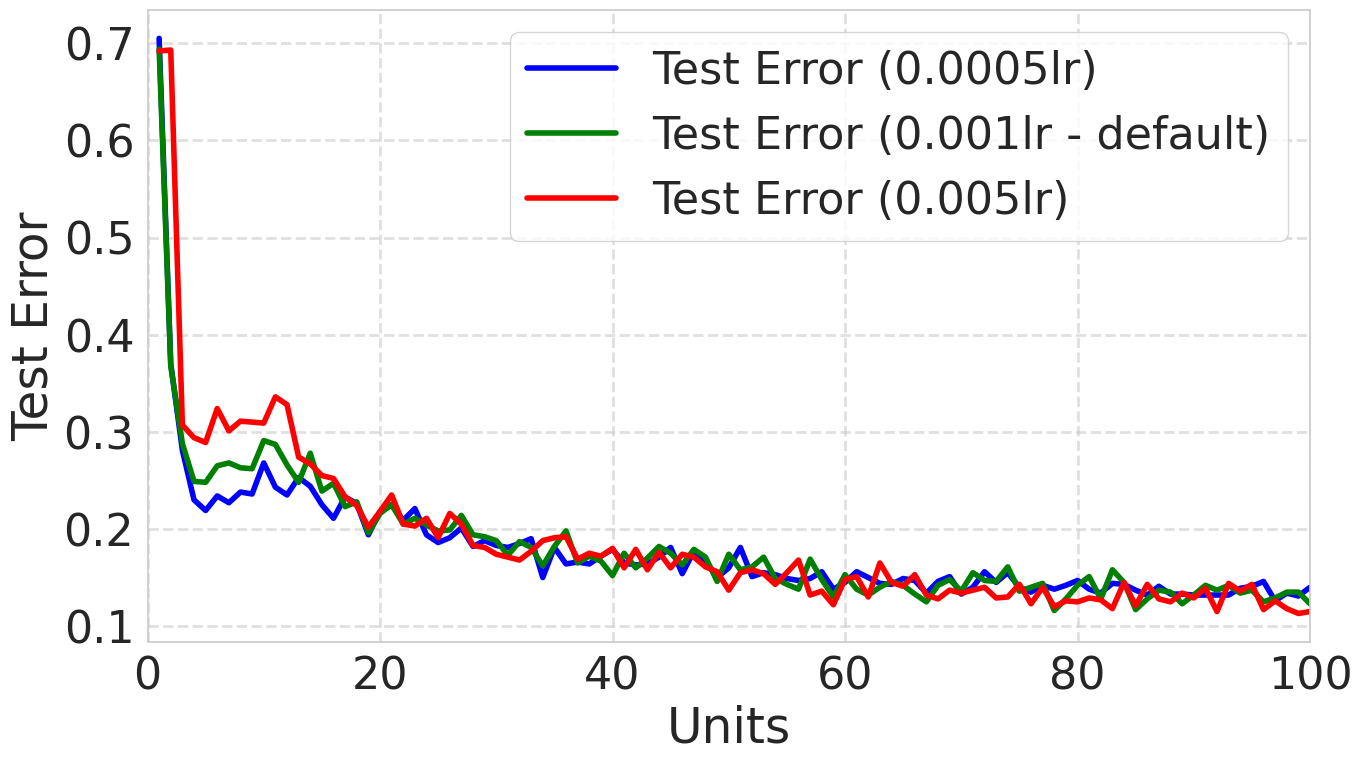

In [441]:
sns.set(style="whitegrid", context="notebook", font_scale=1.6)
plt.figure(figsize=(14, 8))

plt.plot(df_test1["units"], df_test1["test_error"], label="Test Error (0.0005lr)", color="blue", linewidth=4)
plt.plot(df_test2["units"], df_test2["test_error"], label="Test Error (0.001lr - default)", color="green", linewidth=4)
plt.plot(df_test3["units"], df_test3["test_error"], label="Test Error (0.005lr)", color="red", linewidth=4)

plt.xlabel("Units", fontsize=35)
plt.ylabel("Test Error", fontsize=35)

plt.xlim(0, 100)
plt.legend(fontsize=32, loc="best")

plt.grid(True, linestyle='--', alpha=0.6, linewidth=2)

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)

# plt.title("Test error by units (2NN, MNIST ([4000/1000] & 10% label noise))", fontsize=18, fontweight="bold")

plt.tight_layout()
plt.show()

## **Noise-wise (MNIST[4000/1000] & [0-40]% label noise)**

In [442]:
file_base_name1 = 'simple2NN_mnist4k_0noise_noda_256bs'
dataframes1 = load_data_from_files(file_base_name1, drive_path, net)

file_base_name2 = 'simple2NN_mnist4k_010noise_noda_256bs'
dataframes2 = load_data_from_files(file_base_name2, drive_path, net)

df_train1 = dataframes1["train"]
df_test1 = dataframes1["test"]
df_train2 = dataframes2["train"]
df_test2 = dataframes2["test"]

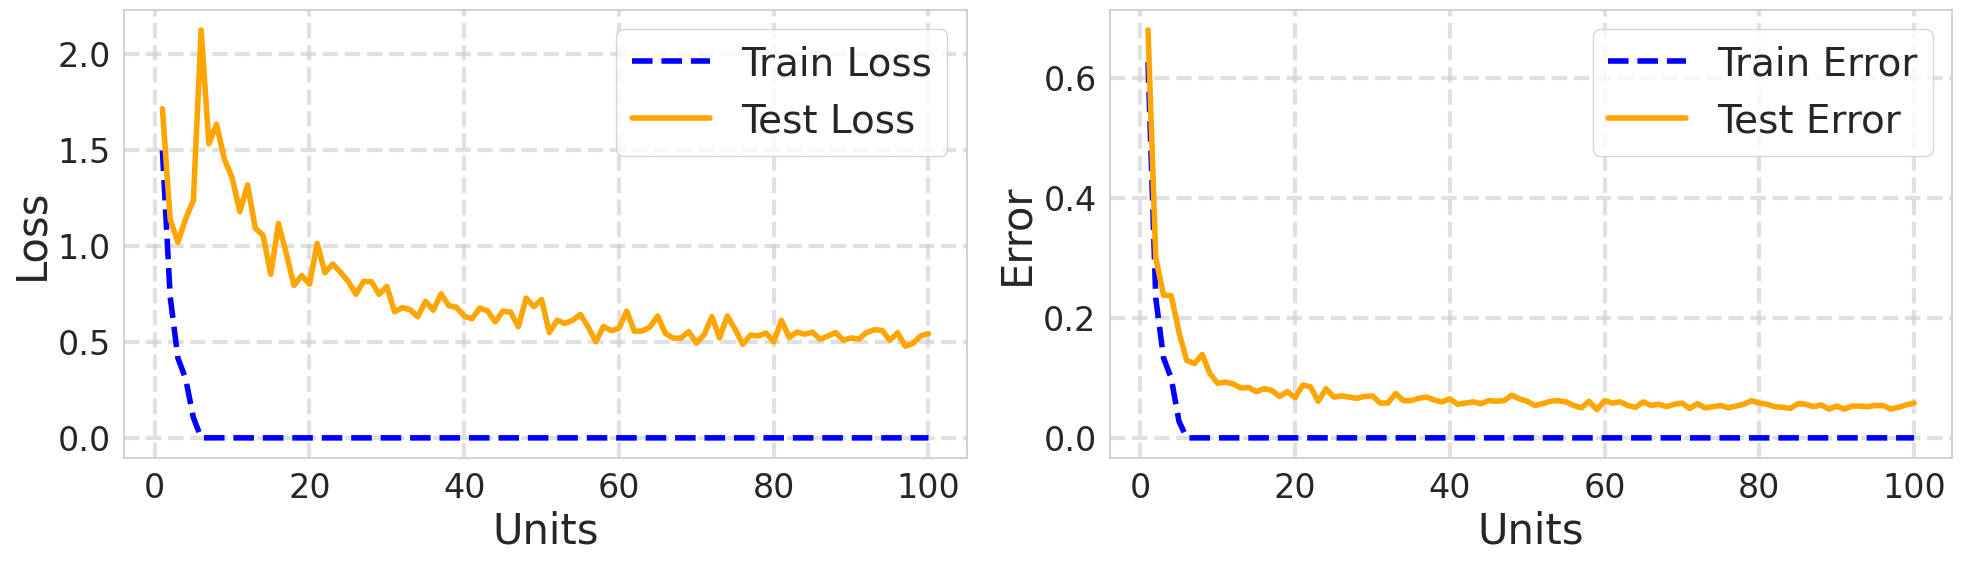

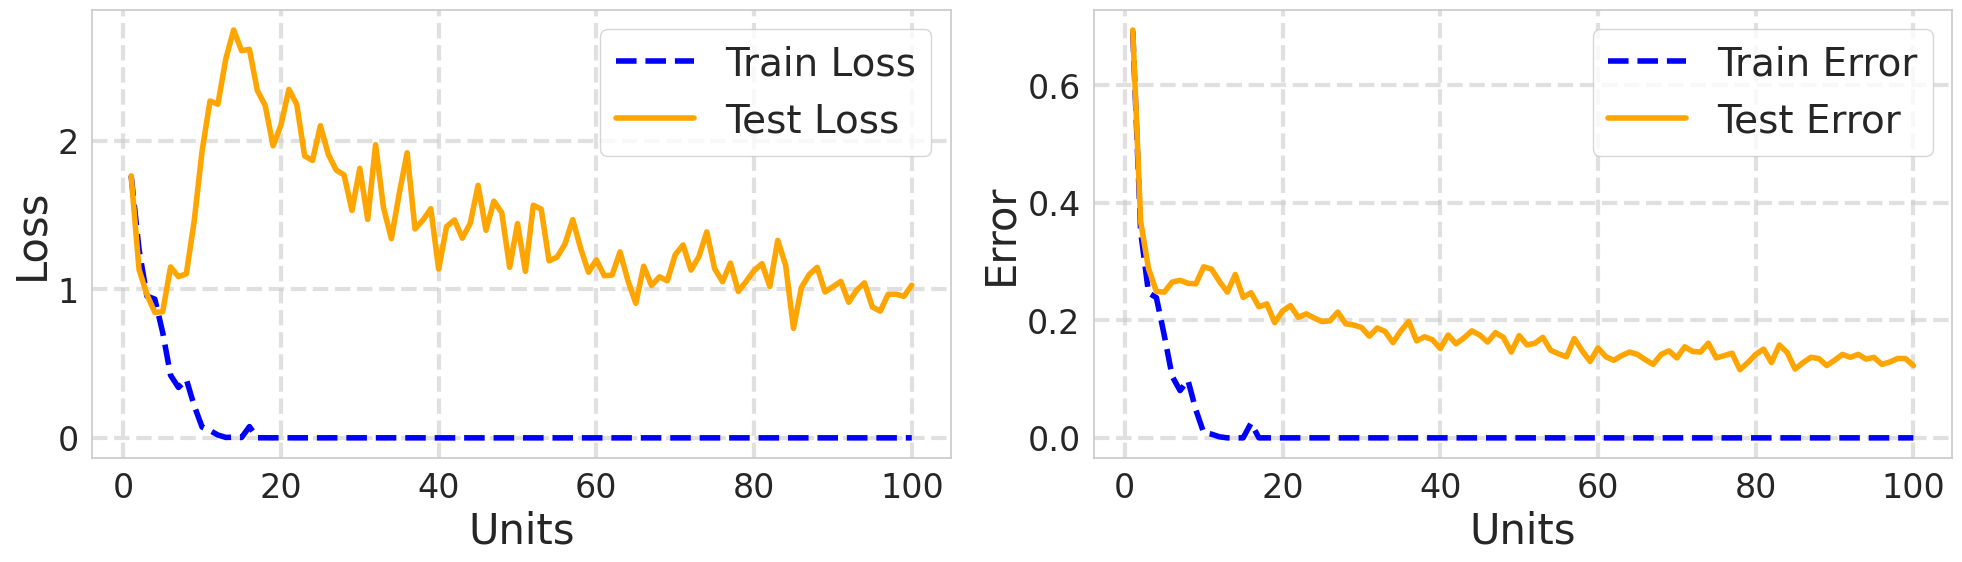

In [443]:
plot_simple_train_test_metrics(df_train1, df_test1, interpolation_threshold=None, xlabel="units", title="(2NN, MNIST ([4000/1000] & no added label noise))")
plot_simple_train_test_metrics(df_train2, df_test2, interpolation_threshold=None, xlabel="units", title="(2NN, MNIST ([4000/1000] & 10% label noise))")

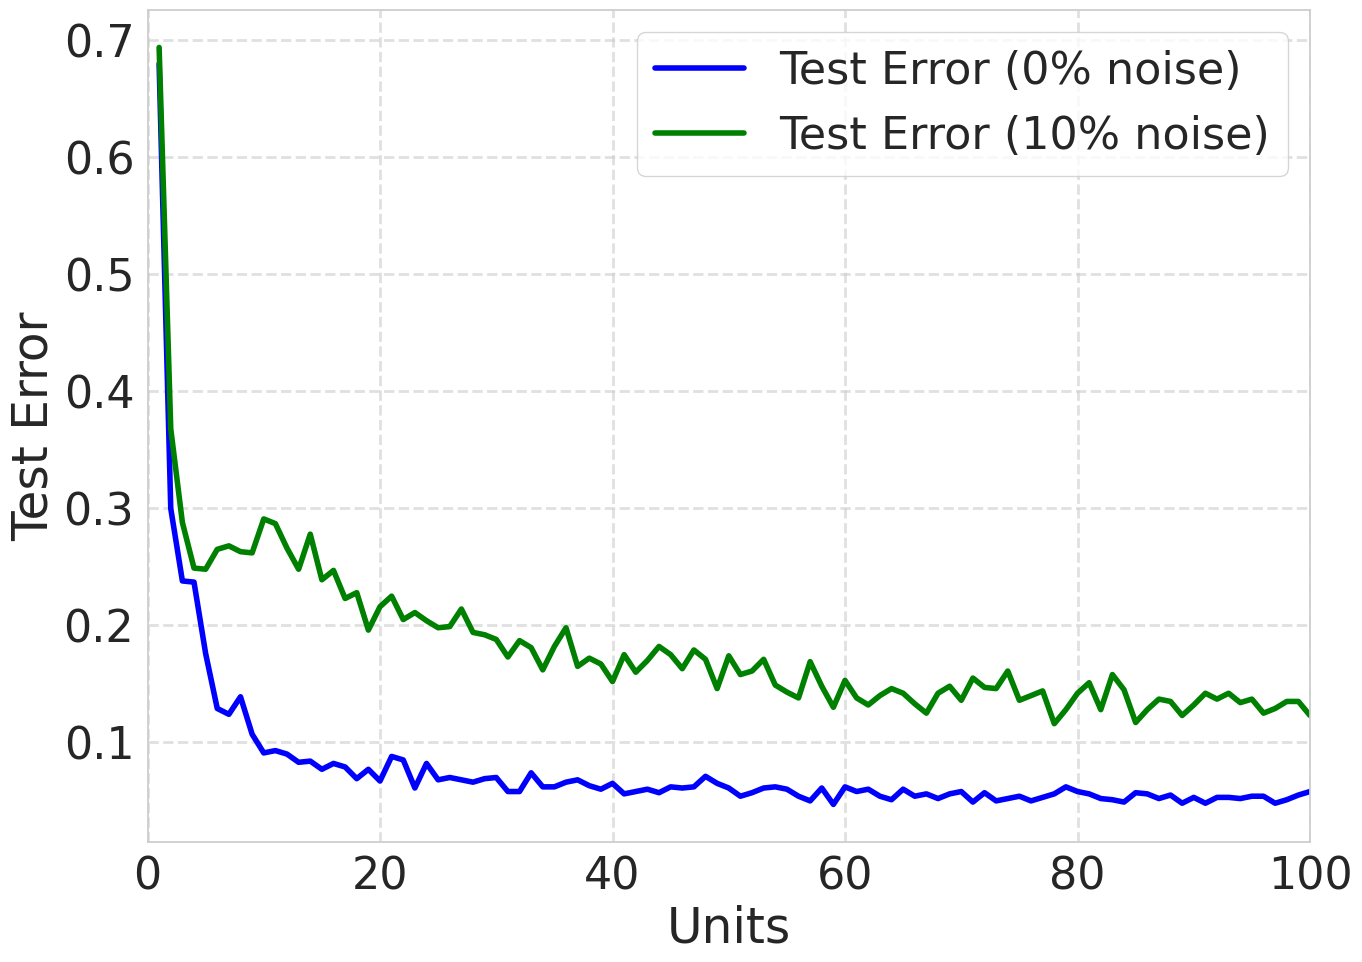

In [444]:
sns.set(style="whitegrid", context="notebook", font_scale=1.6)
plt.figure(figsize=(14, 10))

plt.plot(df_test1["units"], df_test1["test_error"], label="Test Error (0% noise)", color="blue", linewidth=4)
plt.plot(df_test2["units"], df_test2["test_error"], label="Test Error (10% noise)", color="green", linewidth=4)

plt.xlabel("Units", fontsize=35)
plt.ylabel("Test Error", fontsize=35)

plt.xlim(0, 100)
plt.legend(fontsize=32, loc="best")

plt.grid(True, linestyle='--', alpha=0.6, linewidth=2)

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)

# plt.title("Test error by units (2NN, MNIST ([4000/1000] & [0-10]% label noise))", fontsize=18, fontweight="bold")

plt.tight_layout()
plt.show()

In [445]:
file_base_name1 = 'simple2NN_mnist4k_010noise_noda_256bs'
dataframes1 = load_data_from_files(file_base_name1, drive_path, net)

file_base_name2 = 'simple2NN_mnist4k_020noise_noda_256bs'
dataframes2 = load_data_from_files(file_base_name2, drive_path, net)

df_train1 = dataframes1["train"]
df_test1 = dataframes1["test"]
df_train2 = dataframes2["train"]
df_test2 = dataframes2["test"]

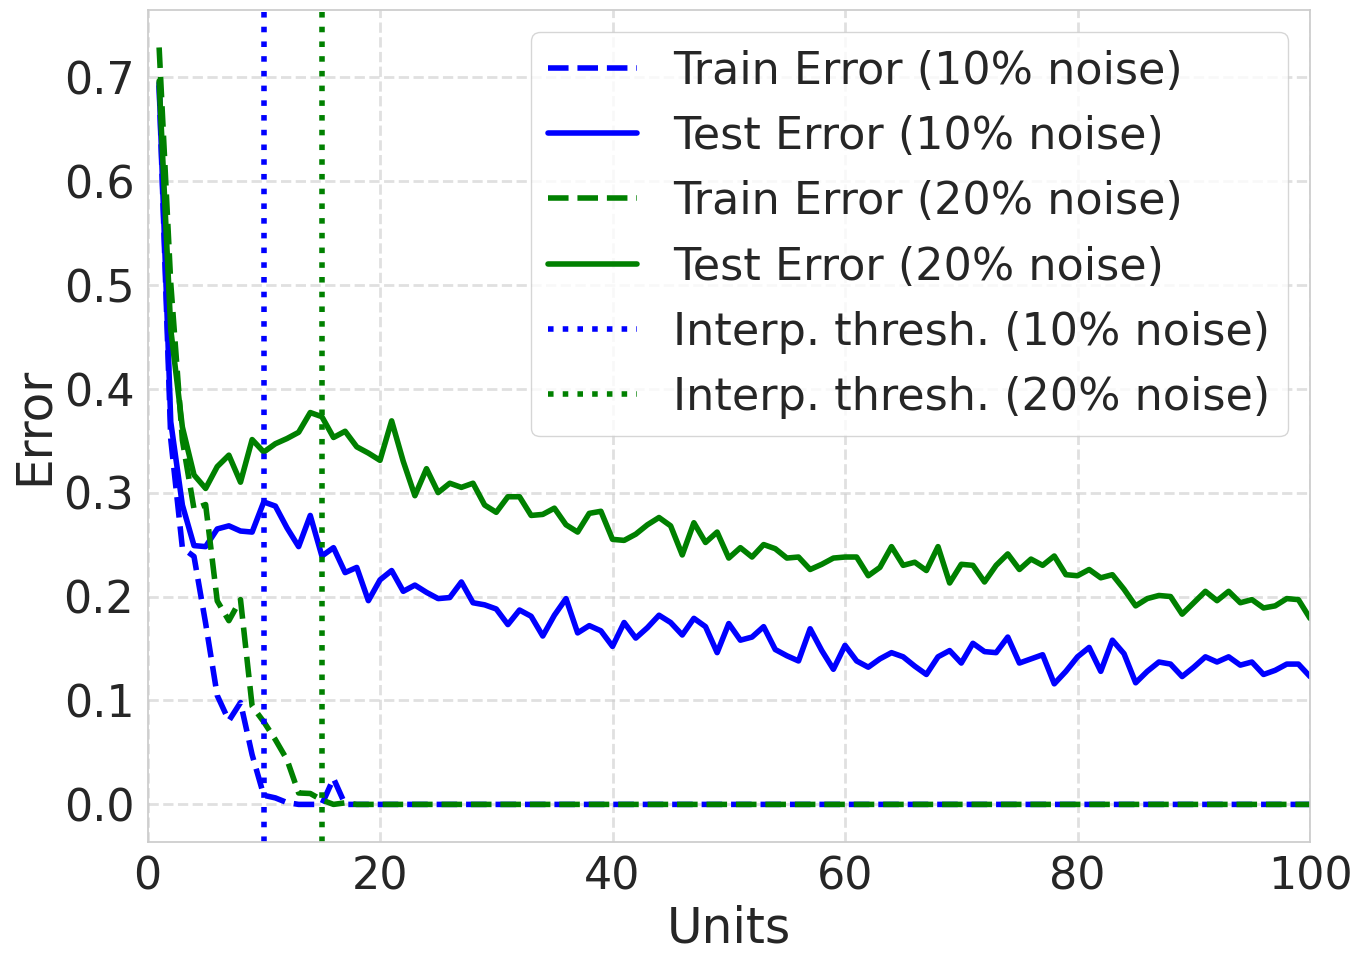

In [446]:
sns.set(style="whitegrid", context="notebook", font_scale=1.6)
plt.figure(figsize=(14, 10))

plt.plot(df_train1["units"], df_train1["train_error"], label="Train Error (10% noise)", color="blue", linestyle="--", linewidth=4)
plt.plot(df_test1["units"], df_test1["test_error"], label="Test Error (10% noise)", color="blue", linewidth=4)
plt.plot(df_train2["units"], df_train2["train_error"], label="Train Error (20% noise)", color="green", linestyle="--", linewidth=4)
plt.plot(df_test2["units"], df_test2["test_error"], label="Test Error (20% noise)", color="green", linewidth=4)

plt.axvline(x=10, color='blue', linestyle='dotted', label="Interp. thresh. (10% noise)", linewidth=4)
plt.axvline(x=15, color='green', linestyle='dotted', label="Interp. thresh. (20% noise)", linewidth=4)

plt.xlabel("Units", fontsize=35)
plt.ylabel("Error", fontsize=35)

plt.xlim(0, 100)
plt.legend(fontsize=32, loc="best")

plt.grid(True, linestyle='--', alpha=0.6, linewidth=2)

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)

# plt.title("Train and Test error by units (2NN, MNIST ([4000/1000] & [10-20]% label noise))", fontsize=18, fontweight="bold")

plt.tight_layout()
plt.show()

In [447]:
file_base_name1 = 'simple2NN_mnist4k_010noise_noda_256bs'
dataframes1 = load_data_from_files(file_base_name1, drive_path, net)

file_base_name2 = 'simple2NN_mnist4k_020noise_noda_256bs'
dataframes2 = load_data_from_files(file_base_name2, drive_path, net)

file_base_name3 = 'simple2NN_mnist4k_030noise_noda_256bs'
dataframes3 = load_data_from_files(file_base_name3, drive_path, net)

file_base_name4 = 'simple2NN_mnist4k_040noise_noda_256bs'
dataframes4 = load_data_from_files(file_base_name4, drive_path, net)

df_train1 = dataframes1["train"]
df_test1 = dataframes1["test"]
df_train2 = dataframes2["train"]
df_test2 = dataframes2["test"]
df_train3 = dataframes3["train"]
df_test3 = dataframes3["test"]
df_train4 = dataframes4["train"]
df_test4 = dataframes4["test"]

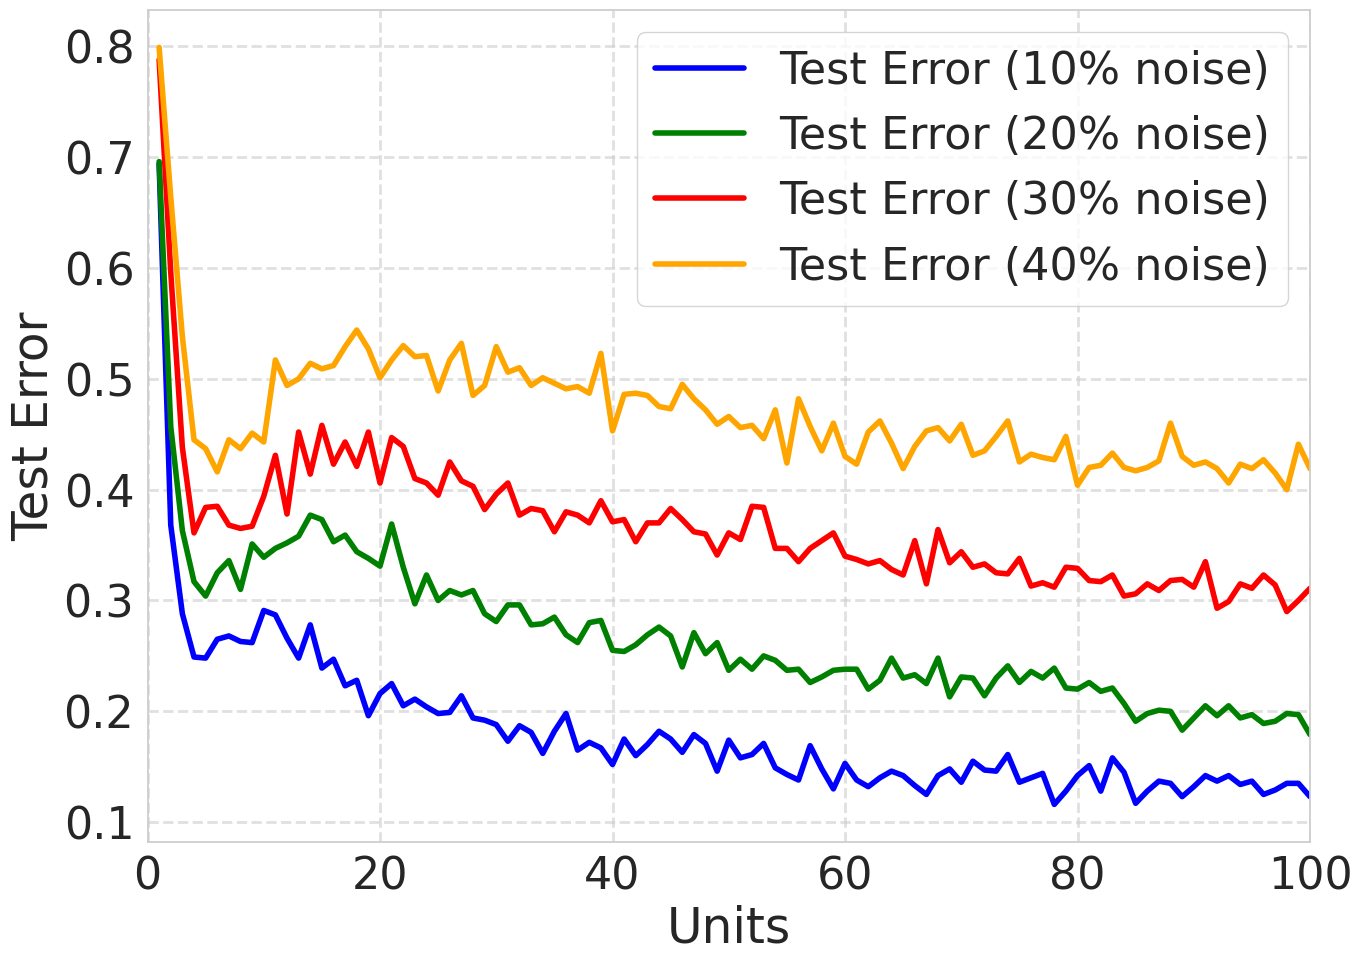

In [448]:
sns.set(style="whitegrid", context="notebook", font_scale=1.6)
plt.figure(figsize=(14, 10))

plt.plot(df_test1["units"], df_test1["test_error"], label="Test Error (10% noise)", color="blue", linewidth=4)
plt.plot(df_test2["units"], df_test2["test_error"], label="Test Error (20% noise)", color="green", linewidth=4)
plt.plot(df_test3["units"], df_test3["test_error"], label="Test Error (30% noise)", color="red", linewidth=4)
plt.plot(df_test4["units"], df_test4["test_error"], label="Test Error (40% noise)", color="orange", linewidth=4)

plt.xlabel("Units", fontsize=35)
plt.ylabel("Test Error", fontsize=35)

plt.xlim(0, 100)
plt.legend(fontsize=32, loc="best")

plt.grid(True, linestyle='--', alpha=0.6, linewidth=2)

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)

# plt.title("Test error by units (2NN, MNIST ([4000/1000] & [10-40]% label noise))", fontsize=18, fontweight="bold")

plt.tight_layout()
plt.show()

## **MNIST [4000/1000] vs MNIST [8000/1000] (Sample-wise)**

In [449]:
file_base_name1 = 'simple2NN_mnist4k_010noise_noda_256bs'
dataframes1 = load_data_from_files(file_base_name1, drive_path, net)

file_base_name2 = 'simple2NN_mnist8k_010noise_noda_256bs'
dataframes2 = load_data_from_files(file_base_name2, drive_path, net)

df_train1 = dataframes1["train"]
df_test1 = dataframes1["test"]
df_train2 = dataframes2["train"]
df_test2 = dataframes2["test"]

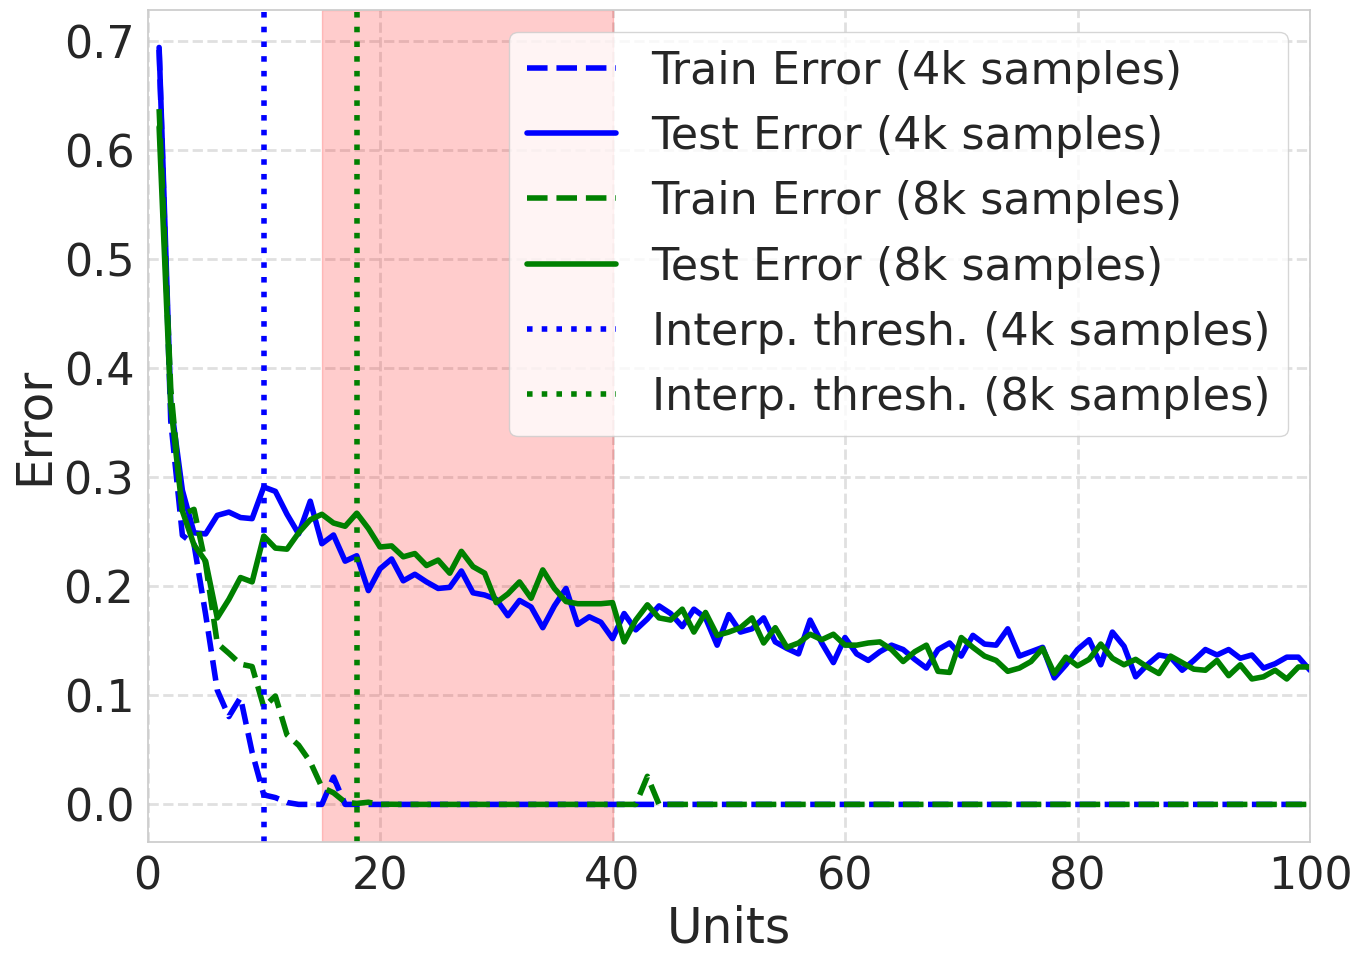

In [450]:
sns.set(style="whitegrid", context="notebook", font_scale=1.6)
plt.figure(figsize=(14, 10))

plt.plot(df_train1["units"], df_train1["train_error"], label="Train Error (4k samples)", color="blue", linestyle="--", linewidth=4)
plt.plot(df_test1["units"], df_test1["test_error"], label="Test Error (4k samples)", color="blue", linewidth=4)
plt.plot(df_train2["units"], df_train2["train_error"], label="Train Error (8k samples)", color="green", linestyle="--", linewidth=4)
plt.plot(df_test2["units"], df_test2["test_error"], label="Test Error (8k samples)", color="green", linewidth=4)

plt.axvspan(15, 40, color="red", alpha=0.2)

plt.axvline(x=10, color='blue', linestyle='dotted', label="Interp. thresh. (4k samples)", linewidth=4)
plt.axvline(x=18, color='green', linestyle='dotted', label="Interp. thresh. (8k samples)", linewidth=4)

plt.xlabel("Units", fontsize=35)
plt.ylabel("Error", fontsize=35)

plt.xlim(0, 100)
plt.legend(fontsize=32, loc="best")

plt.grid(True, linestyle='--', alpha=0.6, linewidth=2)

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)

# plt.title("Train and Test error by units (2NN, MNIST ([4000-8000/1000] & 10% label noise))", fontsize=18, fontweight="bold")

plt.tight_layout()
plt.show()

In [451]:
file_base_name1 = 'simple2NN_x3mnist4k_010noise_noda_256bs'
dataframes1 = load_data_from_files(file_base_name1, drive_path, net)

file_base_name2 = 'simple2NN_x3mnist8k_010noise_noda_256bs'
dataframes2 = load_data_from_files(file_base_name2, drive_path, net)

df_train1 = dataframes1["train"]
df_test1 = dataframes1["test"]
df_train2 = dataframes2["train"]
df_test2 = dataframes2["test"]

In [452]:
def compute_test_mean(df):
  mean_df = []
  num_subsets = df['subset'].nunique()

  for unit in df['units'].unique():
      subset_data = df[df['units'] == unit]

      mean_test_loss = subset_data['test_loss'].sum() / num_subsets
      mean_test_accuracy = subset_data['test_accuracy'].sum() / num_subsets
      mean_test_error = subset_data['test_error'].sum() / num_subsets

      mean_df.append({
          'units': unit,
          'test_loss': mean_test_loss,
          'test_accuracy': mean_test_accuracy,
          'test_error': mean_test_error
      })

  return pd.DataFrame(mean_df)

In [453]:
mean_df1 = compute_test_mean(df_test1)
mean_df2 = compute_test_mean(df_test2)

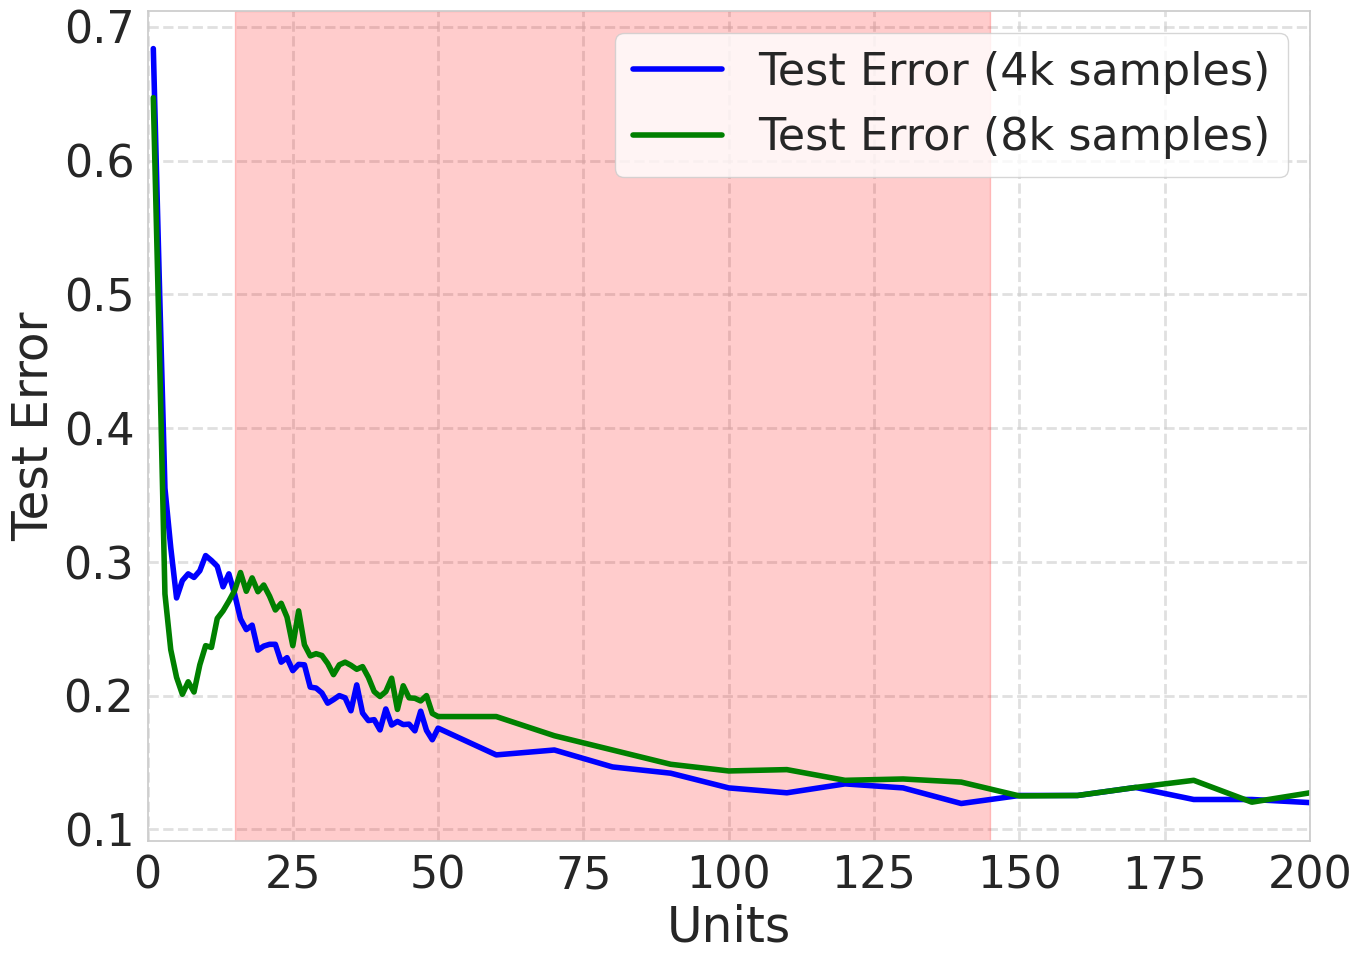

In [454]:
sns.set(style="whitegrid", context="notebook", font_scale=1.6)
plt.figure(figsize=(14, 10))

plt.plot(mean_df1["units"], mean_df1["test_error"], label="Test Error (4k samples)", color="blue", linewidth=4)
plt.plot(mean_df2["units"], mean_df2["test_error"], label="Test Error (8k samples)", color="green", linewidth=4)

plt.axvspan(15, 145, color="red", alpha=0.2)

plt.xlabel("Units", fontsize=35)
plt.ylabel("Test Error", fontsize=35)

plt.xlim(0, 200)
plt.legend(fontsize=32, loc="best")

plt.grid(True, linestyle='--', alpha=0.6, linewidth=2)

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)

# plt.title("Test error by units (2NN, MNIST (x3[4000-8000/1000] & 10% label noise))", fontsize=18, fontweight="bold")

plt.tight_layout()
plt.show()

## **MNIST [4000/1000] up to 1000 hidden units**

In [456]:
path = '/content/drive/MyDrive/Colab Notebooks/Deep Double Descent/2NN/'
file1 = path + 'simple2NN_500units_mnist4k_010noise_noda_256bs_test.txt'
file2 = path + 'simple2NN_750units_mnist4k_010noise_noda_256bs_test.txt'
file3 = path + 'simple2NN_1000units_mnist4k_010noise_noda_256bs_test.txt'

df1 = pd.read_csv(file1, skiprows=2)
df2 = pd.read_csv(file2, skiprows=2)
df3 = pd.read_csv(file3, skiprows=2)

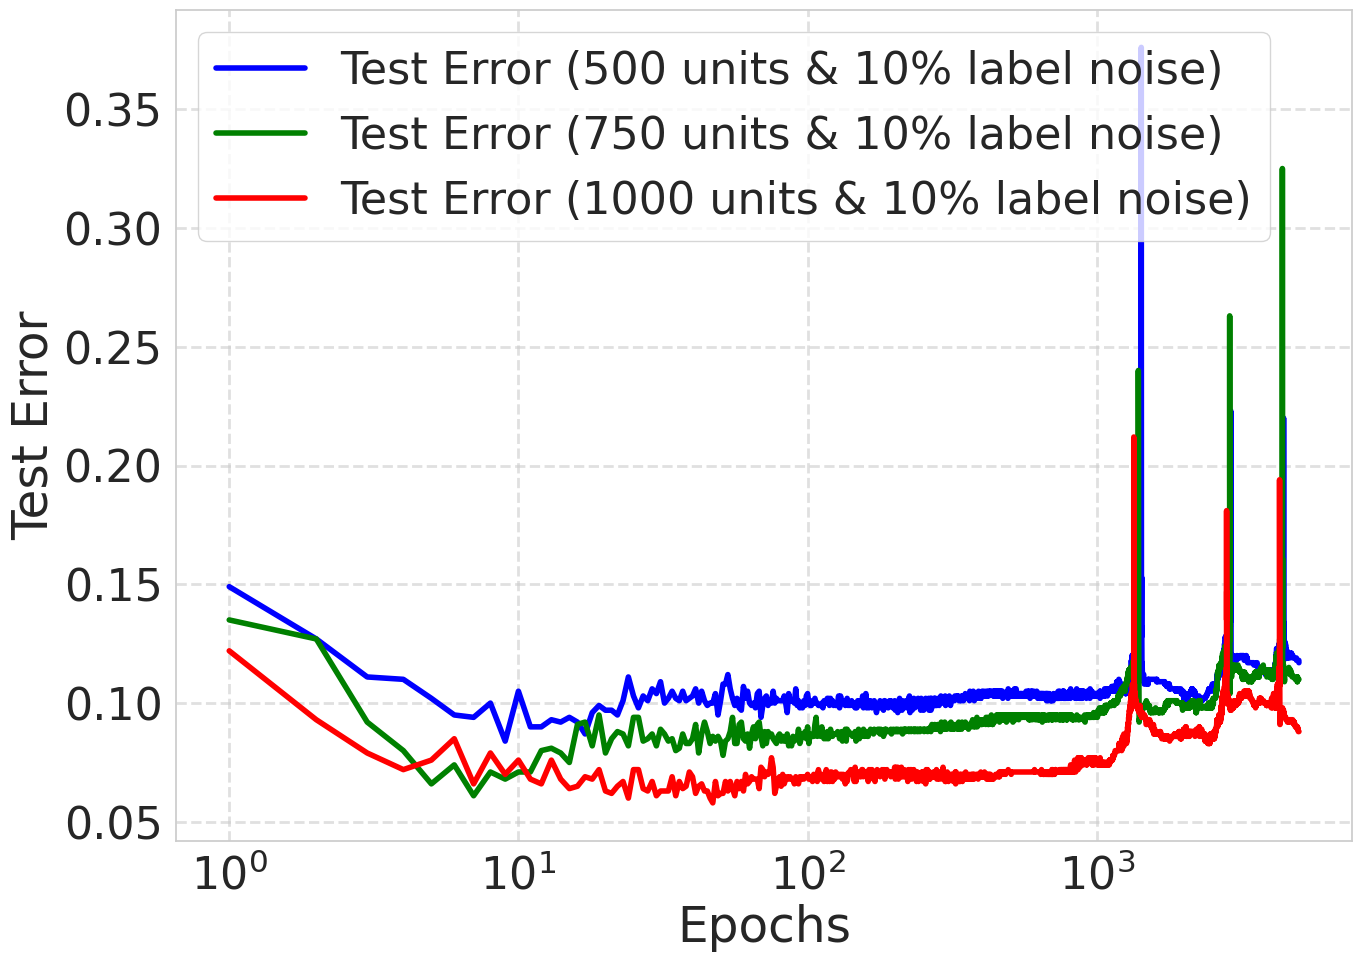

In [457]:
sns.set(style="whitegrid", context="notebook", font_scale=1.6)
plt.figure(figsize=(14, 10))

plt.plot(df1["epoch"], df1["test_error"], label="Test Error (500 units & 10% label noise)", color="blue", linewidth=4)
plt.plot(df2["epoch"], df2["test_error"], label="Test Error (750 units & 10% label noise)", color="green", linewidth=4)
plt.plot(df3["epoch"], df3["test_error"], label="Test Error (1000 units & 10% label noise)", color="red", linewidth=4)

plt.xlabel("Epochs", fontsize=35)
plt.xscale("log")
plt.ylabel("Test Error", fontsize=35)

plt.legend(fontsize=32, loc="best")

plt.grid(True, linestyle='--', alpha=0.6, linewidth=2)

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)

# plt.title("Test error by number of epochs (2NN - MNIST ([4000/1000] & 10% label noise))", fontsize=18, fontweight="bold")

plt.tight_layout()
plt.show()

## **Ratio weights/samples**

In [458]:
file_base_name1 = 'simple2NN_mnist4k_010noise_noda_256bs'
dataframes1 = load_data_from_files(file_base_name1, drive_path, net)

file_base_name2 = 'simple2NN_mnist8k_010noise_noda_256bs'
dataframes2 = load_data_from_files(file_base_name2, drive_path, net)

file_base_name3 = 'simple2NN_mnist12k_010noise_noda_256bs'
dataframes3 = load_data_from_files(file_base_name3, drive_path, net)

file_base_name4 = 'simple2NN_mnist16k_010noise_noda_256bs'
dataframes4 = load_data_from_files(file_base_name4, drive_path, net)

df_train1 = dataframes1["train"]
df_test1 = dataframes1["test"]
df_train2 = dataframes2["train"]
df_test2 = dataframes2["test"]
df_train3 = dataframes3["train"]
df_test3 = dataframes3["test"]
df_train4 = dataframes4["train"]
df_test4 = dataframes4["test"]

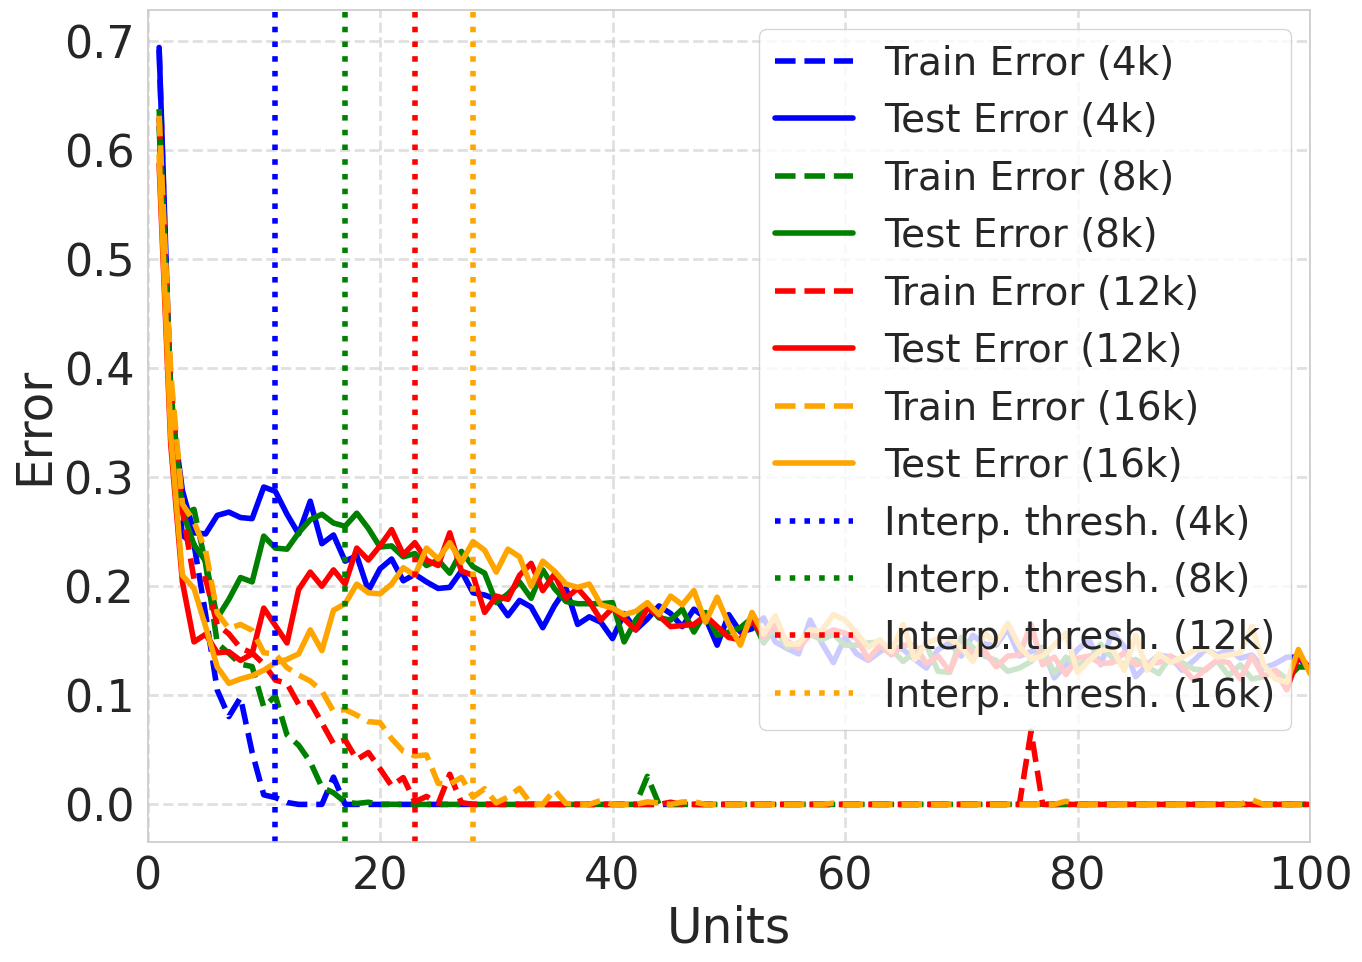

In [459]:
sns.set(style="whitegrid", context="notebook", font_scale=1.6)
plt.figure(figsize=(14, 10))

plt.plot(df_train1["units"], df_train1["train_error"], label="Train Error (4k)", color="blue", linestyle="--", linewidth=4)
plt.plot(df_test1["units"], df_test1["test_error"], label="Test Error (4k)", color="blue", linewidth=4)
plt.plot(df_train2["units"], df_train2["train_error"], label="Train Error (8k)", color="green", linestyle="--", linewidth=4)
plt.plot(df_test2["units"], df_test2["test_error"], label="Test Error (8k)", color="green", linewidth=4)
plt.plot(df_train3["units"], df_train3["train_error"], label="Train Error (12k)", color="red", linestyle="--", linewidth=4)
plt.plot(df_test3["units"], df_test3["test_error"], label="Test Error (12k)", color="red", linewidth=4)
plt.plot(df_train4["units"], df_train4["train_error"], label="Train Error (16k)", color="orange", linestyle="--", linewidth=4)
plt.plot(df_test4["units"], df_test4["test_error"], label="Test Error (16k)", color="orange", linewidth=4)

plt.axvline(x=11, color='blue', linestyle='dotted', linewidth=4, label="Interp. thresh. (4k)")
plt.axvline(x=17, color='green', linestyle='dotted', linewidth=4, label="Interp. thresh. (8k)")
plt.axvline(x=23, color='red', linestyle='dotted', linewidth=4, label="Interp. thresh. (12k)")
plt.axvline(x=28, color='orange', linestyle='dotted', linewidth=4, label="Interp. thresh. (16k)")

plt.xlabel("Units", fontsize=35)
plt.ylabel("Error", fontsize=35)

plt.xlim(0, 100)
plt.legend(fontsize=28, loc="upper right")

plt.grid(True, linestyle='--', alpha=0.6, linewidth=2)

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)

# plt.title("Train and Test error by units (2NN - MNIST ([4000-16000], 10% label noise))", fontsize=18, fontweight="bold")

plt.tight_layout()
plt.show()

## **Test error by units and epochs**

### **MNIST [4000/1000]**

In [460]:
file_base_name1 = 'simple2NN_mnist4k_010noise_noda_256bs_epochwise5k'
dataframes1 = load_data_from_files(file_base_name1, drive_path, net)

df_train = dataframes1["train"]
df_test = dataframes1["test"]

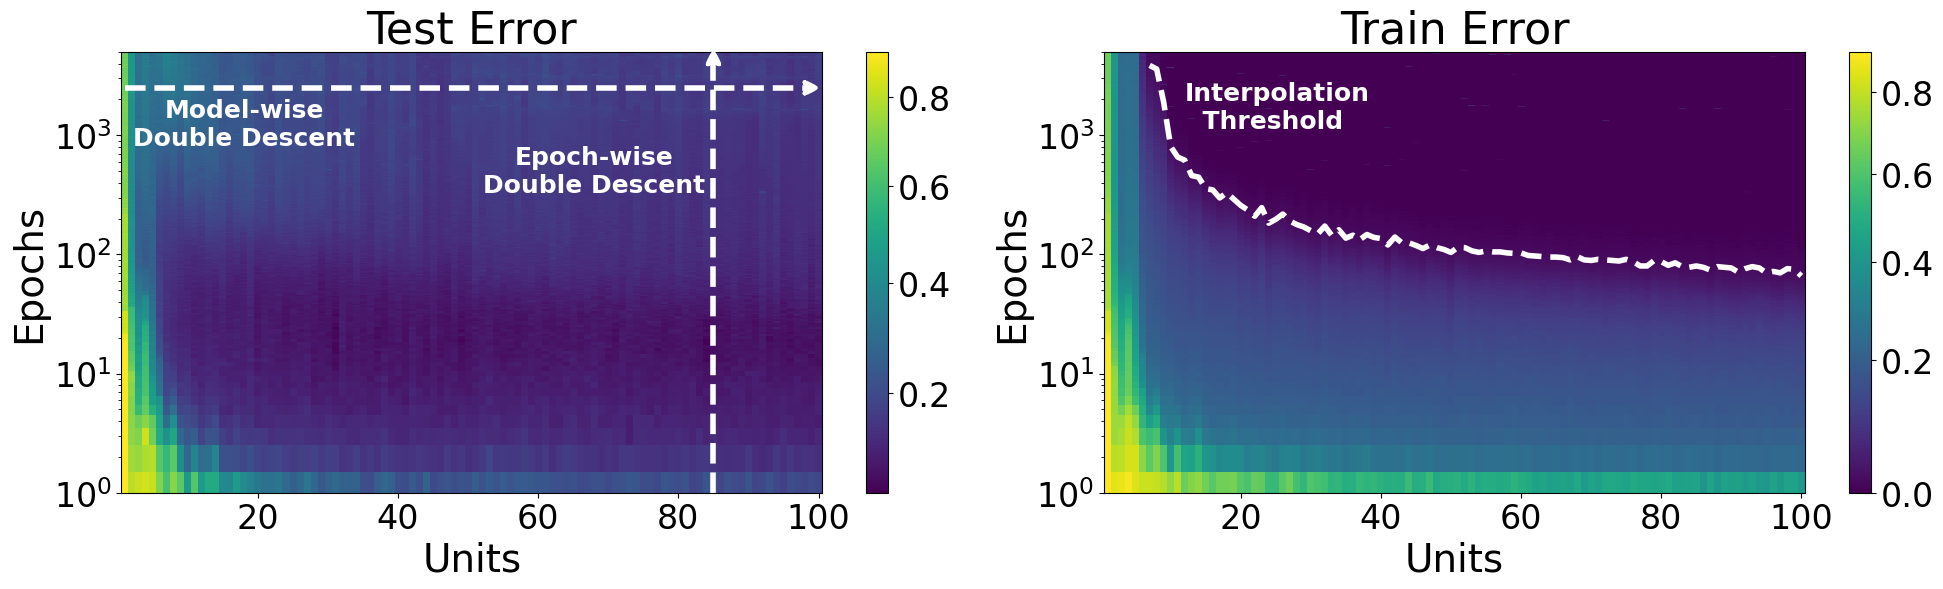

In [461]:
plot_train_test_error_heatmap(df_train, df_test, threshold_value=0.01, colormap="viridis", gamma=0.8, xlabel="Units", ylabel="Epochs", title="(2NN, MNIST ([4000/1000] & 10% label noise))")

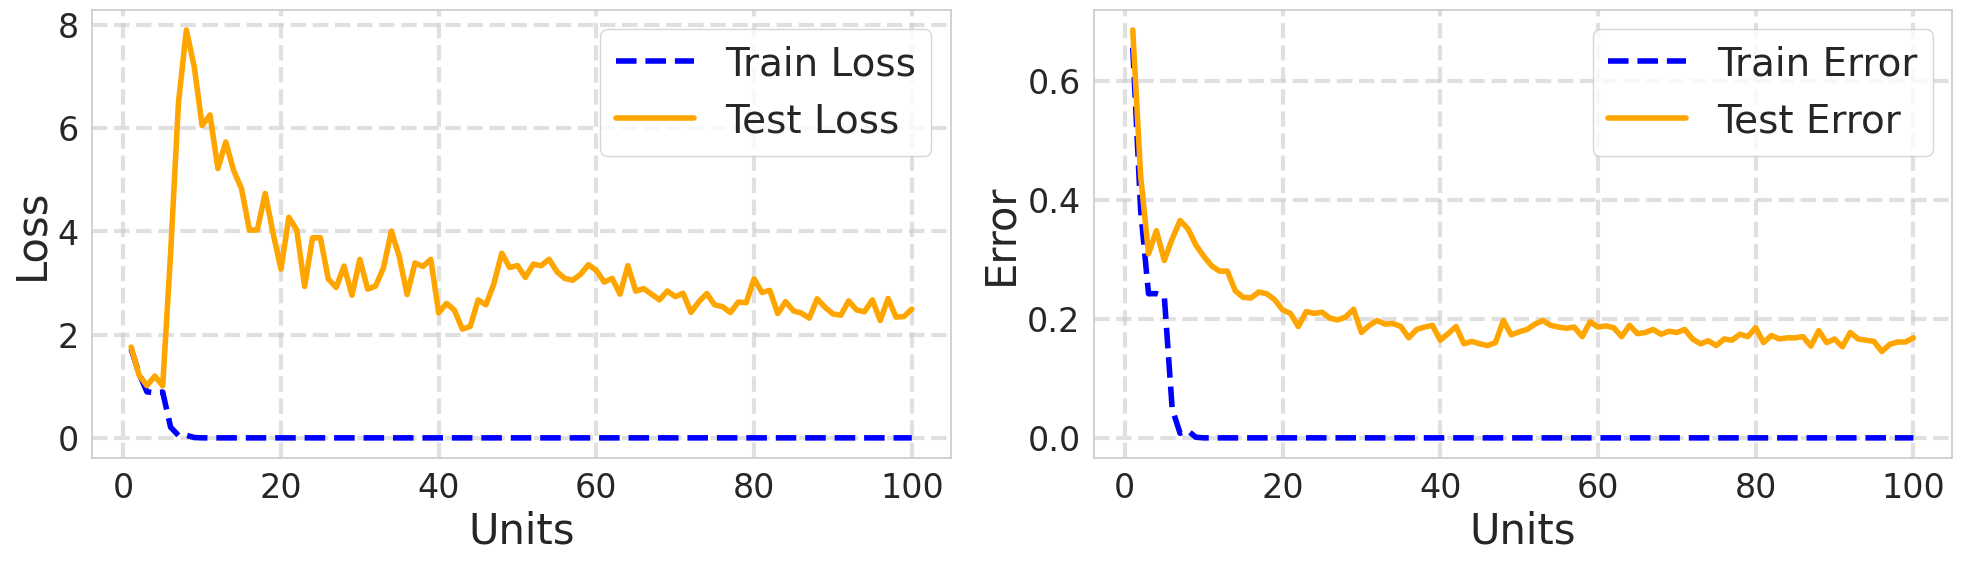

In [462]:
epoch = 5000
df_train_filtered, df_test_filtered = filter_by_epoch(df_train, df_test, epoch)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="units", title="(2NN, MNIST ([4000/1000] & 10% label noise))")

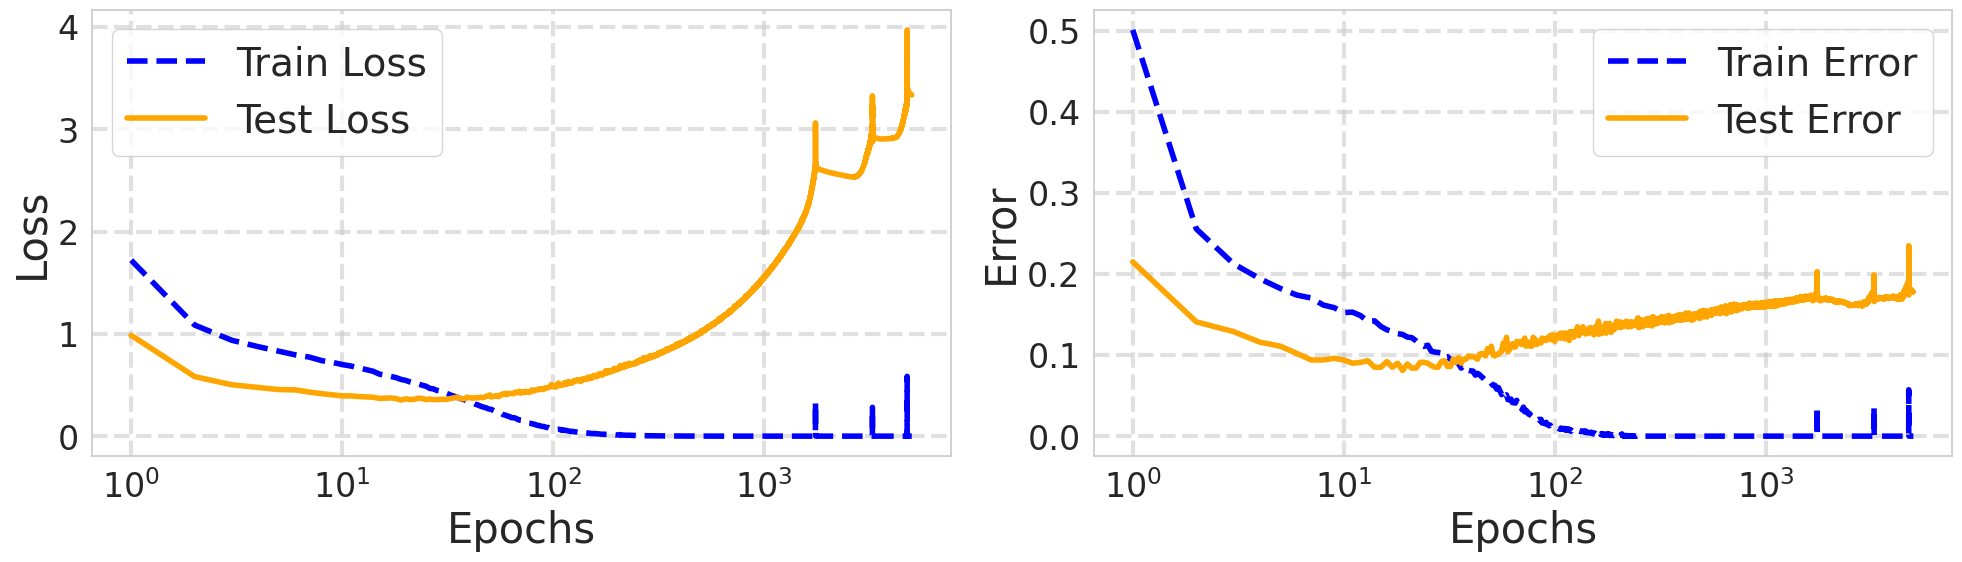

In [463]:
model = 50
df_train_filtered, df_test_filtered = filter_by_model(df_train, df_test, model)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="epochs", title=f"(2NN(k={model}) - MNIST ([4000/1000] & 10% label noise))")

### **CIFAR10 [4000/1000]**

In [464]:
file_base_name1 = 'simple2NN_cifar104k_020noise_noda_128bs'
dataframes1 = load_data_from_files(file_base_name1, drive_path, net)

df_train = dataframes1["train"]
df_test = dataframes1["test"]

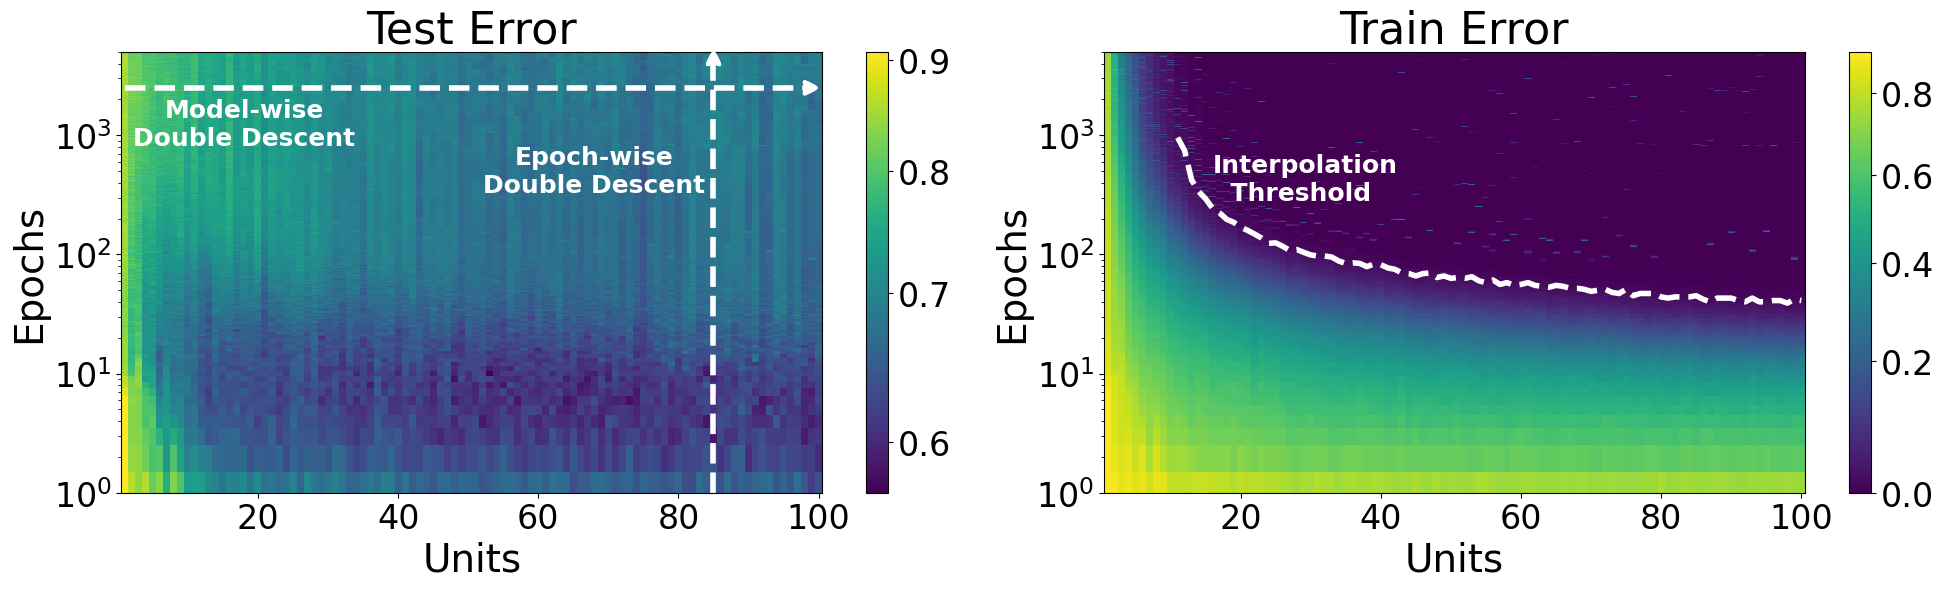

In [465]:
plot_train_test_error_heatmap(df_train, df_test, threshold_value=0.01, colormap="viridis", gamma=0.8, xlabel="Units", ylabel="Epochs", title="(2NN, CIFAR10 ([4000/1000] & 20% label noise))")

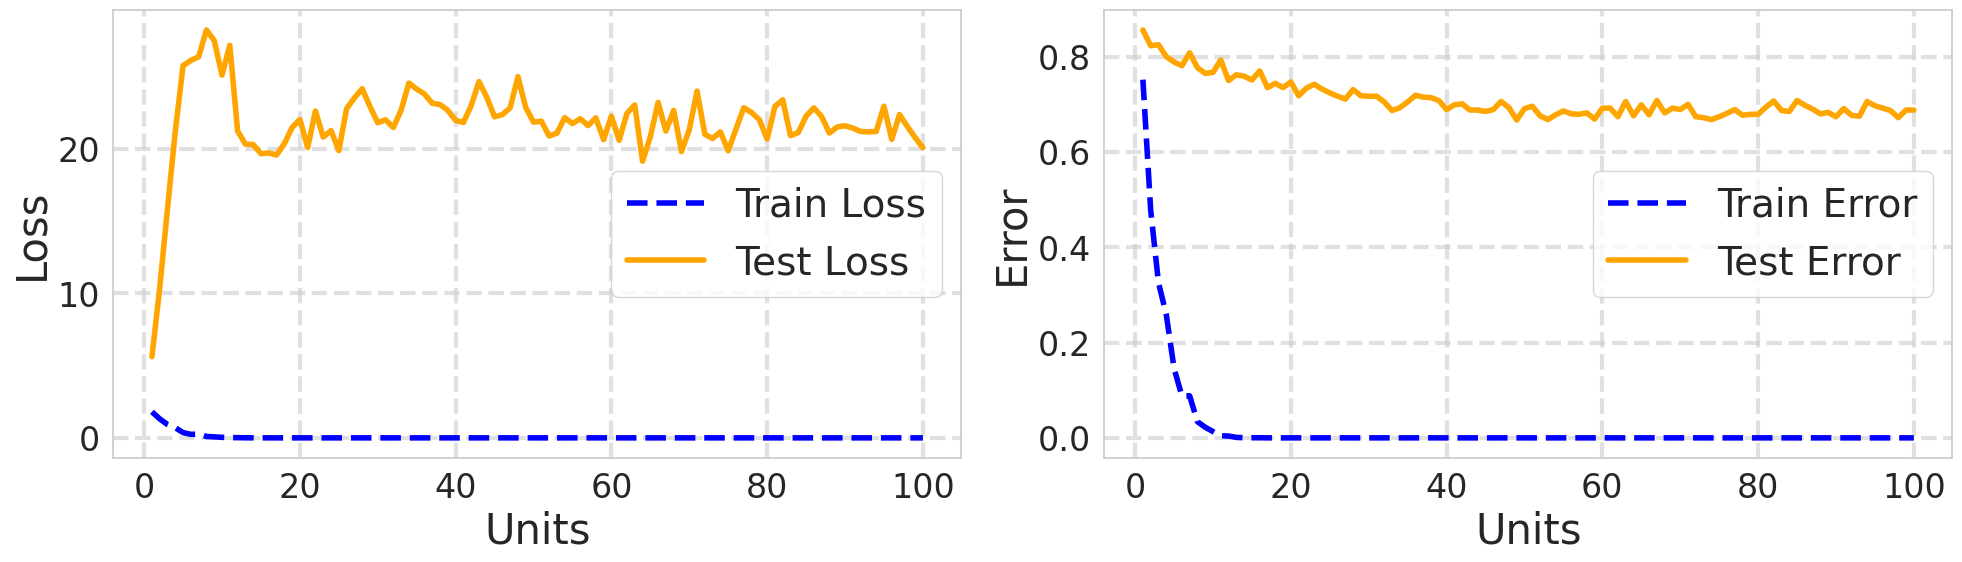

In [466]:
epoch = 5000
df_train_filtered, df_test_filtered = filter_by_epoch(df_train, df_test, epoch)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="units", title="(2NN, CIFAR10 ([4000/1000] & 15% label noise))")

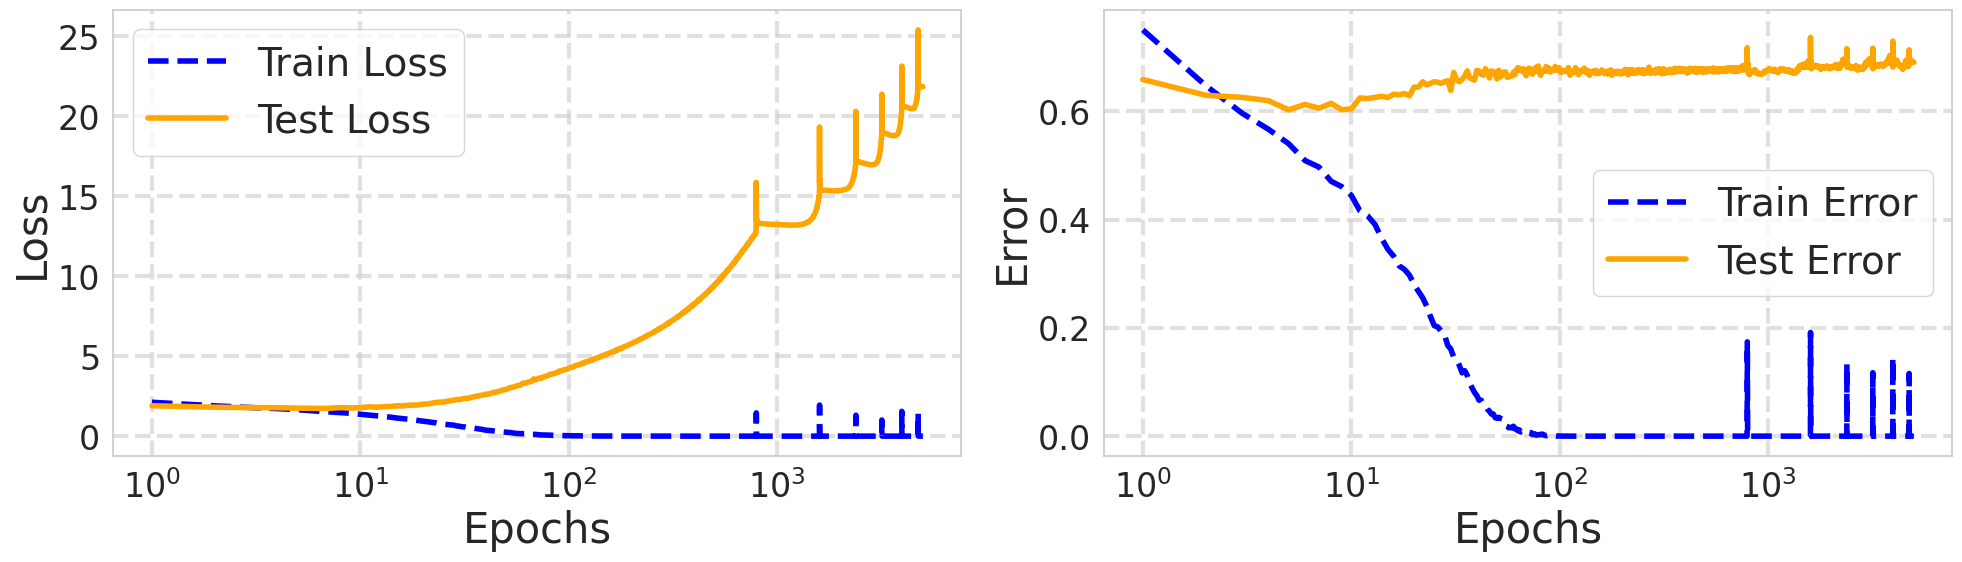

In [467]:
model = 50
df_train_filtered, df_test_filtered = filter_by_model(df_train, df_test, model)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="epochs", title=f"(2NN(k={model}) - CIFAR10 ([4000/1000] & 15% label noise))")

# **DeepNN**

In [468]:
class DeepNN(nn.Module):
  def __init__(self, input_size, size=1, num_classes=10):
    super(DeepNN, self).__init__()

    hidden_size = (size + 1) // 2
    self.flatten = nn.Flatten()

    self.layers = nn.Sequential(
        nn.Linear(input_size, hidden_size), nn.ReLU(),
        nn.Linear(hidden_size, hidden_size), nn.ReLU(),
        nn.Linear(hidden_size, 2*hidden_size), nn.ReLU(),
        nn.Linear(2*hidden_size, 2*hidden_size), nn.ReLU(),
        nn.Linear(2*hidden_size, 2*hidden_size), nn.ReLU(),
        nn.Linear(2*hidden_size, 2*hidden_size), nn.ReLU(),
        nn.Linear(2*hidden_size, 4*hidden_size), nn.ReLU(),
        nn.Linear(4*hidden_size, num_classes)
    )

  def forward(self, x):
    x = self.flatten(x)
    x = self.layers(x)
    return x

def create_deep_nn(input_size, size, num_classes):
  model = DeepNN(input_size=input_size, size=size, num_classes=num_classes)
  return model

In [469]:
net = create_deep_nn(input_size=28*28, size=64, num_classes=10)

input = (1, 28, 28)
summary(net, input)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 32]          25,120
              ReLU-3                   [-1, 32]               0
            Linear-4                   [-1, 32]           1,056
              ReLU-5                   [-1, 32]               0
            Linear-6                   [-1, 64]           2,112
              ReLU-7                   [-1, 64]               0
            Linear-8                   [-1, 64]           4,160
              ReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 64]           4,160
             ReLU-11                   [-1, 64]               0
           Linear-12                   [-1, 64]           4,160
             ReLU-13                   [-1, 64]               0
           Linear-14                  [

In [470]:
net = "DeepNN"

## **MNIST [4000/1000]**

In [471]:
file_base_name = 'simpleDeepNN_mnist4k_010noise_noda_256bs'
dataframes = load_data_from_files(file_base_name, drive_path, net)

df_train = dataframes["train"]
df_test = dataframes["test"]

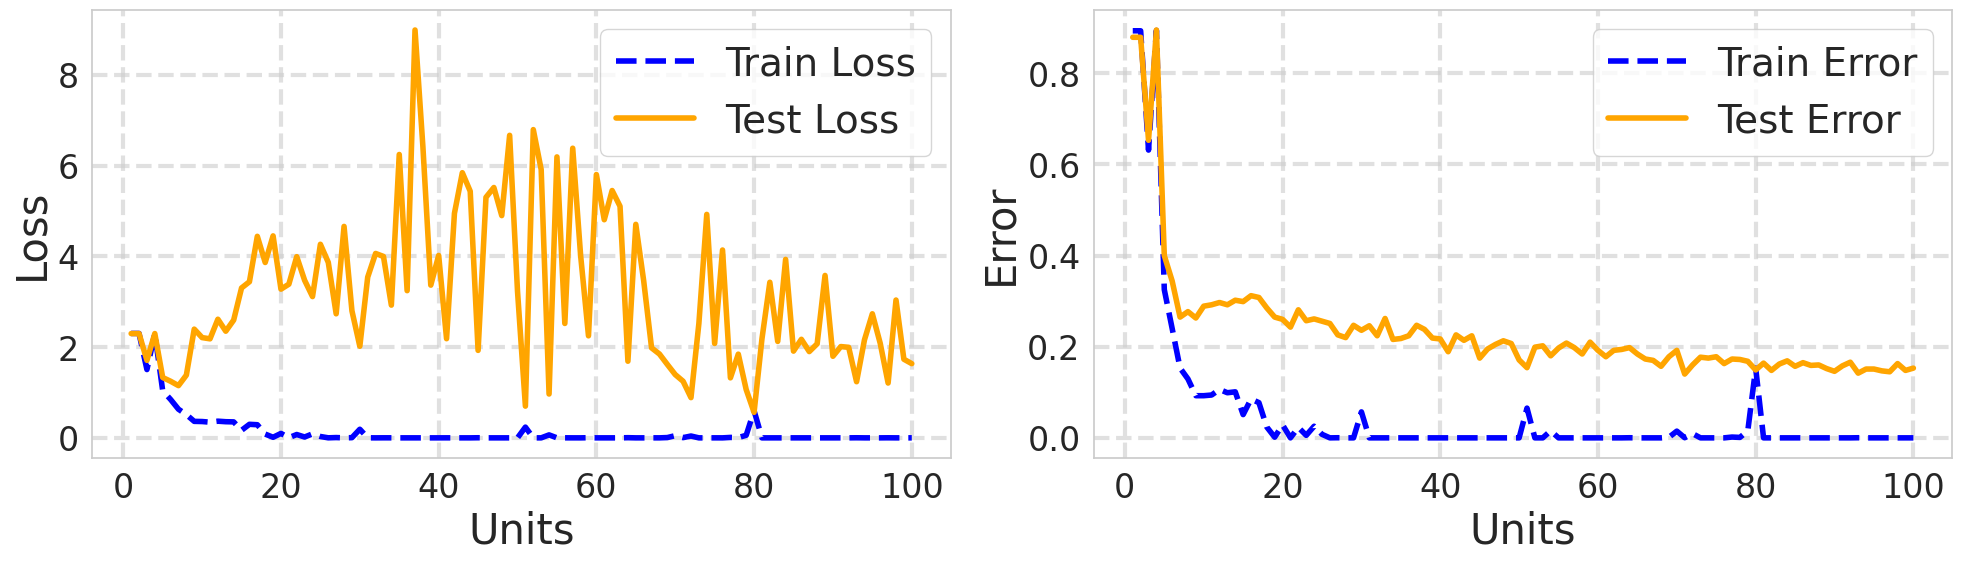

In [472]:
plot_simple_train_test_metrics(df_train, df_test, interpolation_threshold=None, xlabel="units", title="(DeepNN, MNIST ([4000/1000] & 10% label noise))")

## **2NN vs DeepNN**

In [473]:
net1 = "2NN"

file_base_name1 = 'simple2NN_mnist4k_010noise_noda_256bs'
dataframes1 = load_data_from_files(file_base_name1, drive_path, net1)

df_train1 = dataframes1["train"]
df_test1 = dataframes1["test"]

In [474]:
net2 = "DeepNN"
file_base_name2 = 'simpleDeepNN_mnist4k_010noise_noda_256bs'
dataframes = load_data_from_files(file_base_name2, drive_path, net2)

df_train2 = dataframes["train"]
df_test2 = dataframes["test"]

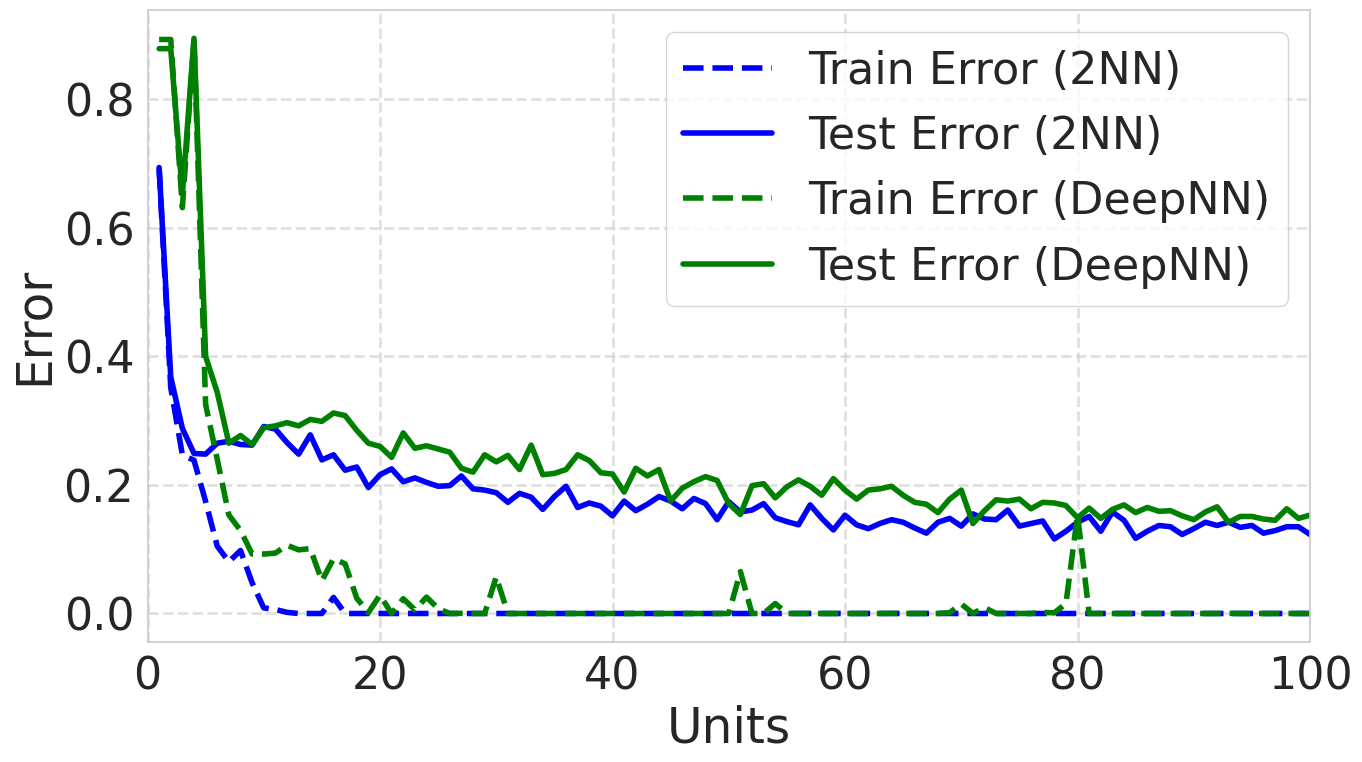

In [475]:
sns.set(style="whitegrid", context="notebook", font_scale=1.6)
plt.figure(figsize=(14, 8))

plt.plot(df_train1["units"], df_train1["train_error"], label="Train Error (2NN)", color="blue", linestyle="--", linewidth=4)
plt.plot(df_test1["units"], df_test1["test_error"], label="Test Error (2NN)", color="blue", linewidth=4)
plt.plot(df_train2["units"], df_train2["train_error"], label="Train Error (DeepNN)", color="green", linestyle="--", linewidth=4)
plt.plot(df_test2["units"], df_test2["test_error"], label="Test Error (DeepNN)", color="green", linewidth=4)

plt.xlabel("Units", fontsize=35)
plt.ylabel("Error", fontsize=35)

plt.xlim(0, 100)
plt.legend(fontsize=32, loc="best")

plt.grid(True, linestyle='--', alpha=0.6, linewidth=2)

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)

# plt.title("Train and Test error by units (2NN & DeepNN, MNIST ([4000/1000] & 10% label noise))", fontsize=18, fontweight="bold")

plt.tight_layout()
plt.show()

# **3CNN**

In [ ]:
class ThreeLayerCNN(nn.Module):
  def __init__(self, in_channels, k, num_classes):
    super(ThreeLayerCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, k, kernel_size=5, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(k)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2)

    self.conv2 = nn.Conv2d(k, 2 * k, kernel_size=5, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(2 * k)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(2)

    self.conv3 = nn.Conv2d(2 * k, 4 * k, kernel_size=5, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(4 * k)
    self.relu3 = nn.ReLU()
    self.pool3 = nn.AdaptiveMaxPool2d((1, 1))

    self.flatten = nn.Flatten()
    self.fc = nn.Linear(4 * k, num_classes)

  def forward(self, x):
    x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
    x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
    x = self.pool3(self.relu3(self.bn3(self.conv3(x))))

    x = self.flatten(x)
    x = self.fc(x)
    return x

def create_3cnn(in_channels, size, num_classes):
  model = ThreeLayerCNN(in_channels=in_channels, k=size, num_classes=num_classes)
  return model

In [477]:
in_channels = 3
k = 64
num_classes = 10

net = create_3cnn(in_channels=in_channels, size=k, num_classes=num_classes)
input = (3, 32, 32)
summary(net, input)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           4,864
       BatchNorm2d-2           [-1, 64, 30, 30]             128
              ReLU-3           [-1, 64, 30, 30]               0
         MaxPool2d-4           [-1, 64, 15, 15]               0
            Conv2d-5          [-1, 128, 13, 13]         204,928
       BatchNorm2d-6          [-1, 128, 13, 13]             256
              ReLU-7          [-1, 128, 13, 13]               0
         MaxPool2d-8            [-1, 128, 6, 6]               0
            Conv2d-9            [-1, 256, 4, 4]         819,456
      BatchNorm2d-10            [-1, 256, 4, 4]             512
             ReLU-11            [-1, 256, 4, 4]               0
        MaxPool2d-12            [-1, 256, 1, 1]               0
          Flatten-13                  [-1, 256]               0
           Linear-14                   

In [478]:
net = "3CNN"

## **MNIST [4000/1000]**

In [479]:
file_base_name = 'simple3CNN_mnist4k_010noise_noda_128bs'
dataframes = load_data_from_files(file_base_name, drive_path, net)

df_train = dataframes["train"]
df_test = dataframes["test"]

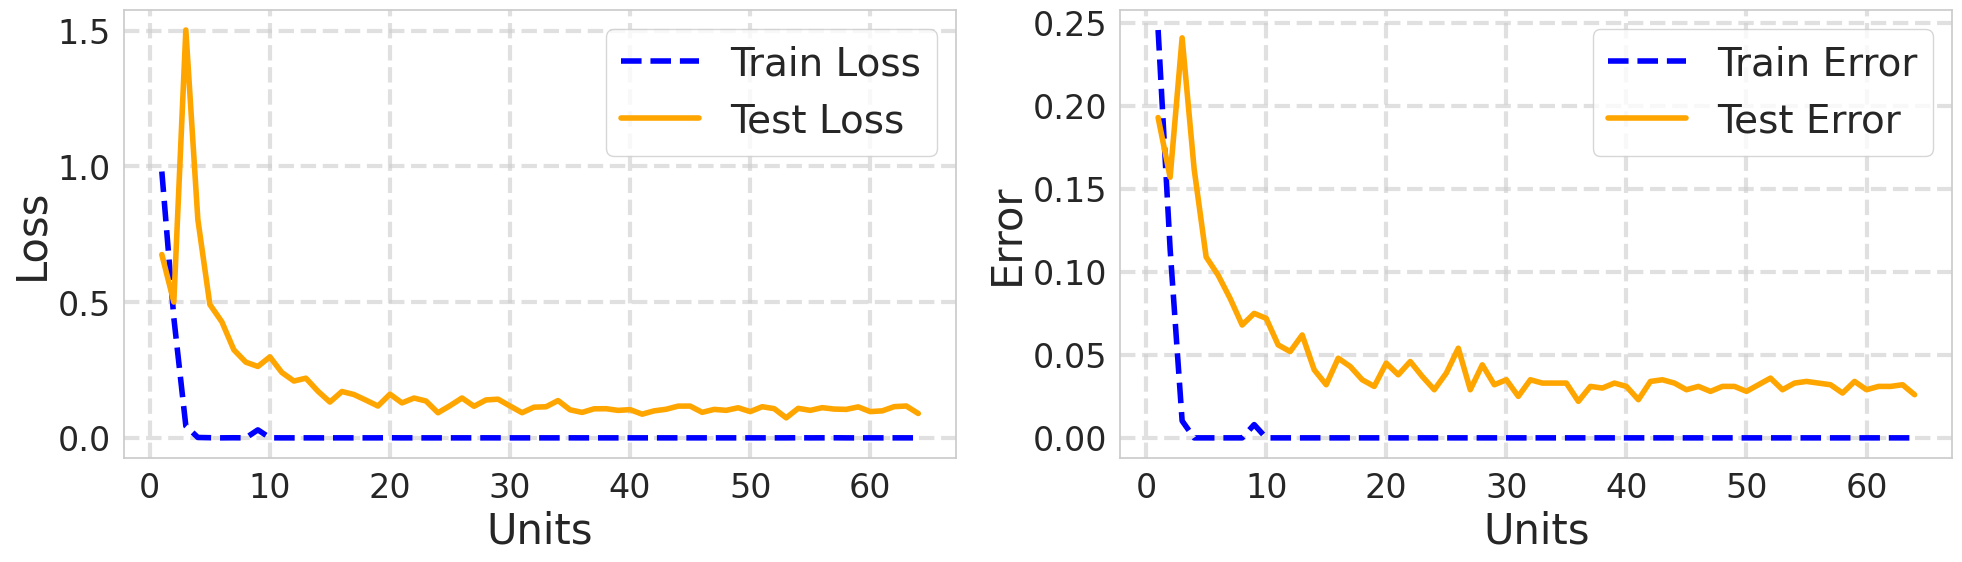

In [480]:
epoch = 1000
df_train_filtered, df_test_filtered = filter_by_epoch(df_train, df_test, epoch)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="units", title="(3CNN, MNIST ([4000/1000] & 10% label noise))")

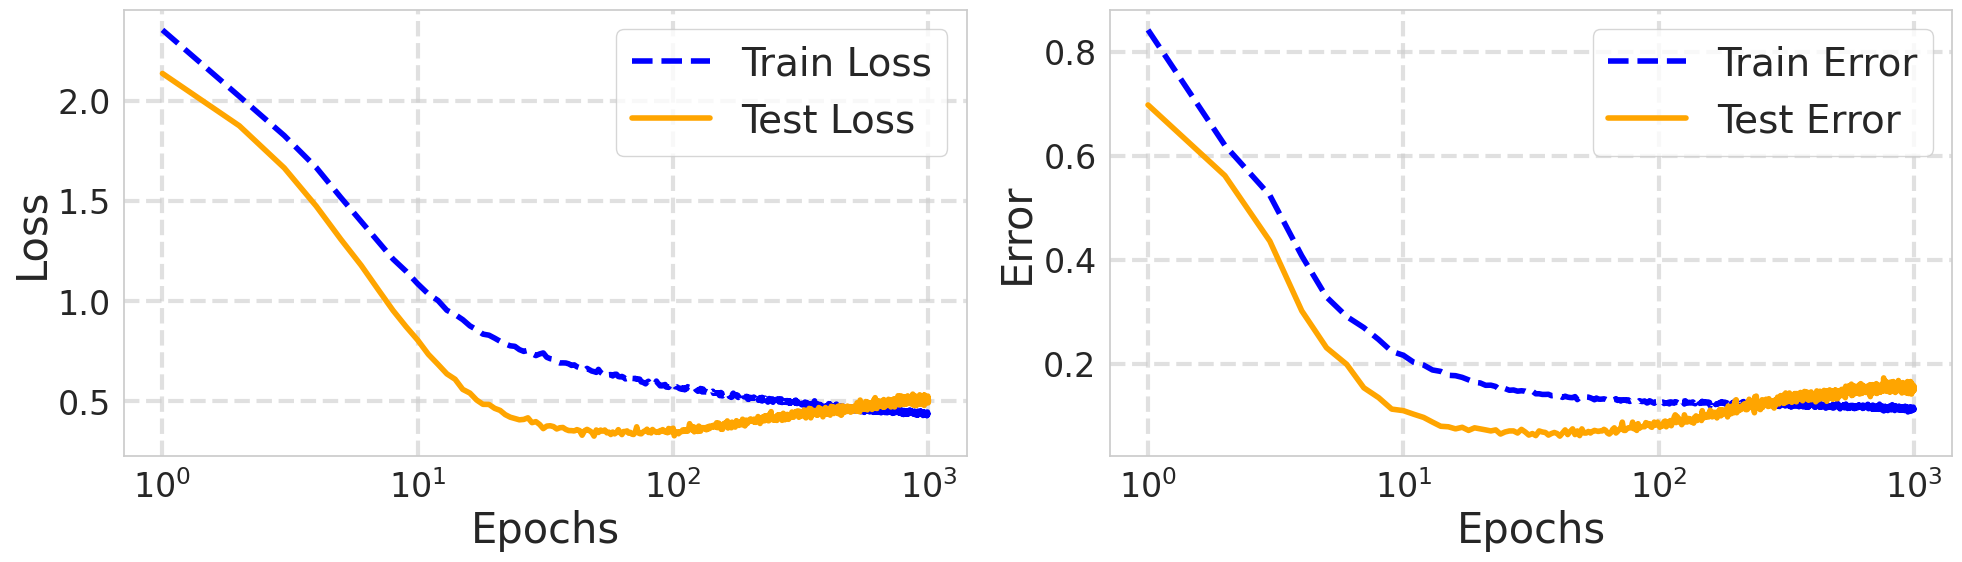

In [481]:
model = 2
df_train_filtered, df_test_filtered = filter_by_model(df_train, df_test, model)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="epochs", title=f"(3CNN(k={model}) - MNIST ([4000/1000] & 10% label noise))")

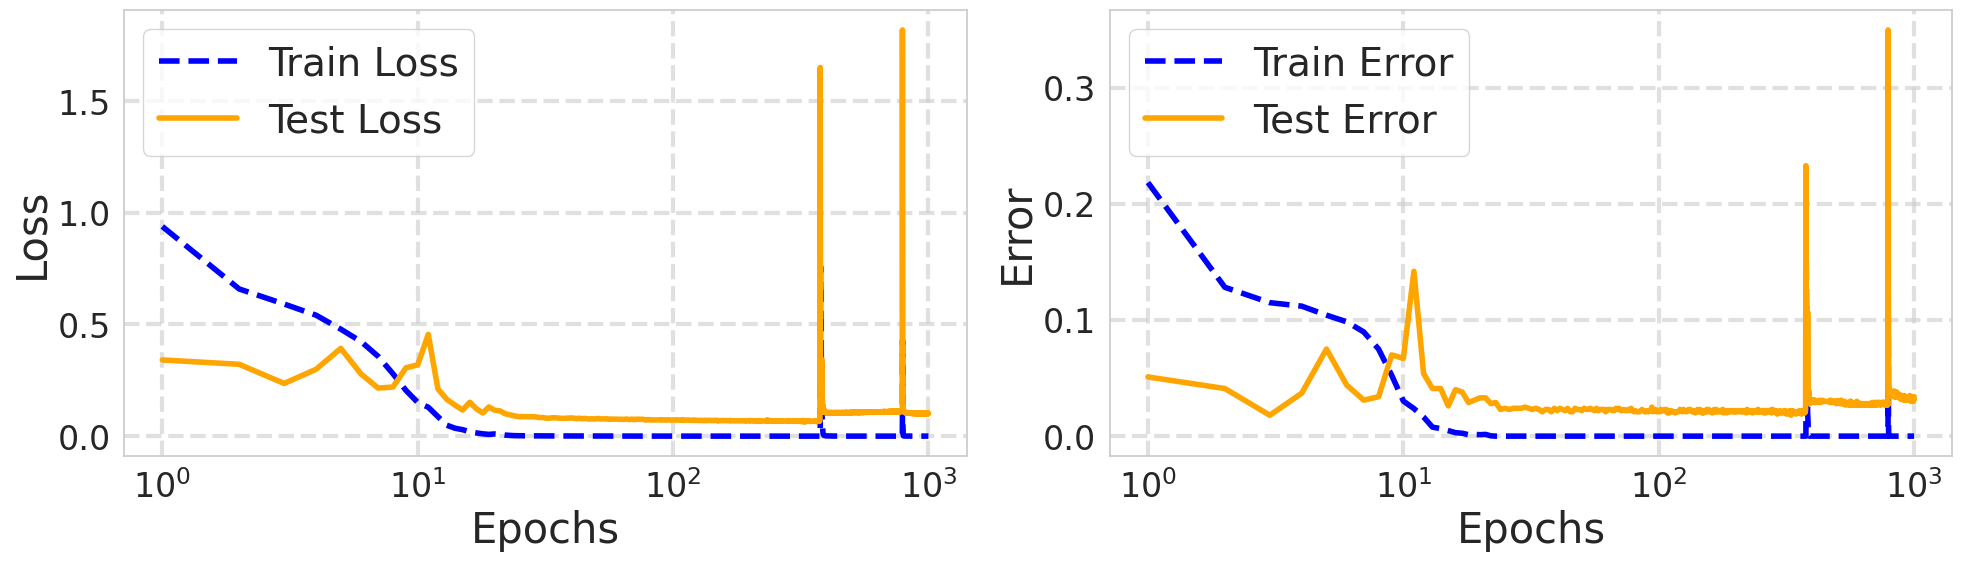

In [482]:
model = 55
df_train_filtered, df_test_filtered = filter_by_model(df_train, df_test, model)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="epochs", title=f"(3CNN(k={model}) - MNIST ([4000/1000] & 10% label noise))")

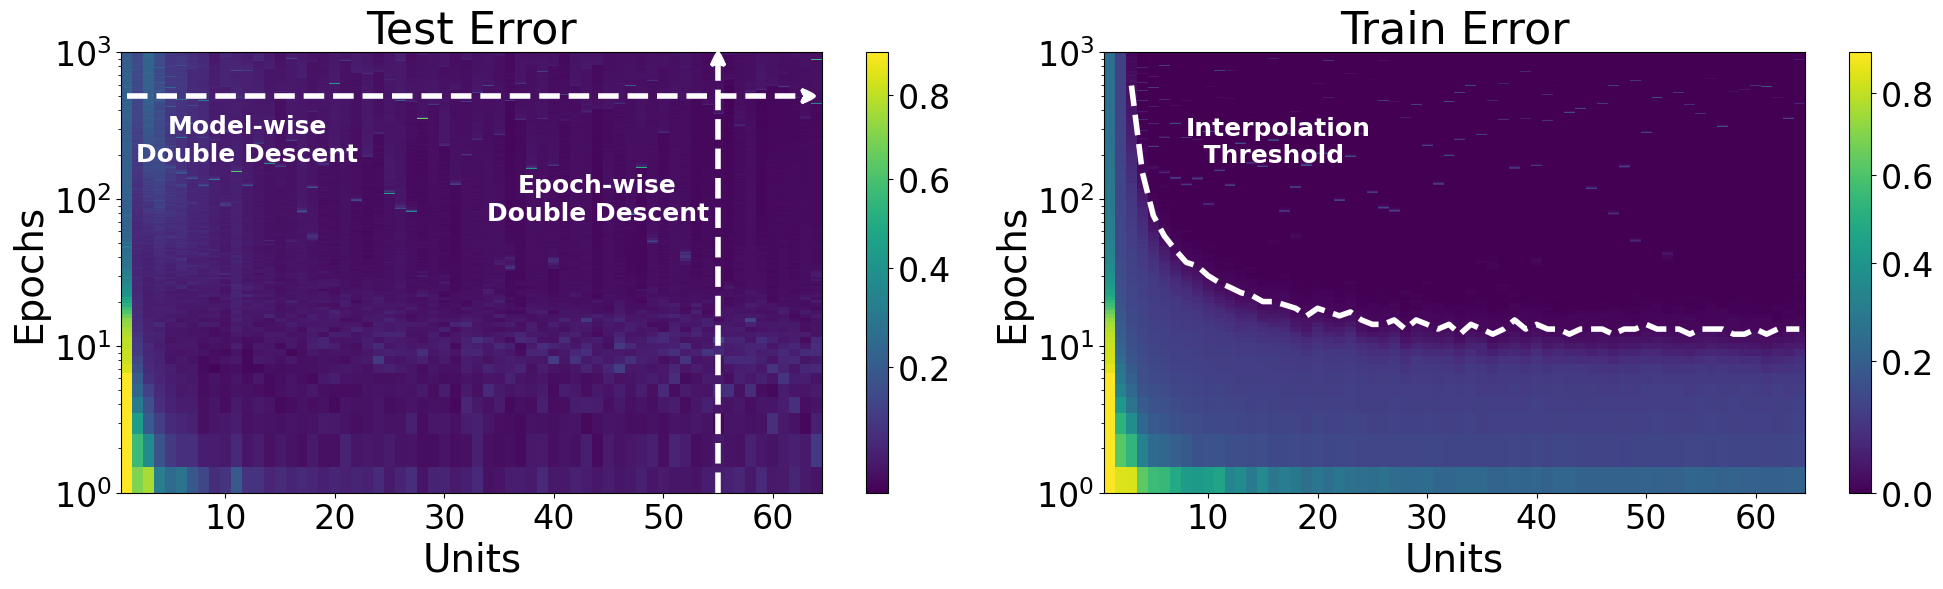

In [483]:
plot_train_test_error_heatmap(df_train, df_test, threshold_value=0.01, colormap="viridis", gamma=0.8, xlabel="Units", ylabel="Epochs", title="(3CNN, MNIST ([4000/1000] & 10% label noise))")

## **MNIST [30000/5000]**

In [484]:
file_base_name = 'simple3CNN_mnist30k_010noise_noda_128bs'
dataframes = load_data_from_files(file_base_name, drive_path, net)

df_train = dataframes["train"]
df_test = dataframes["test"]

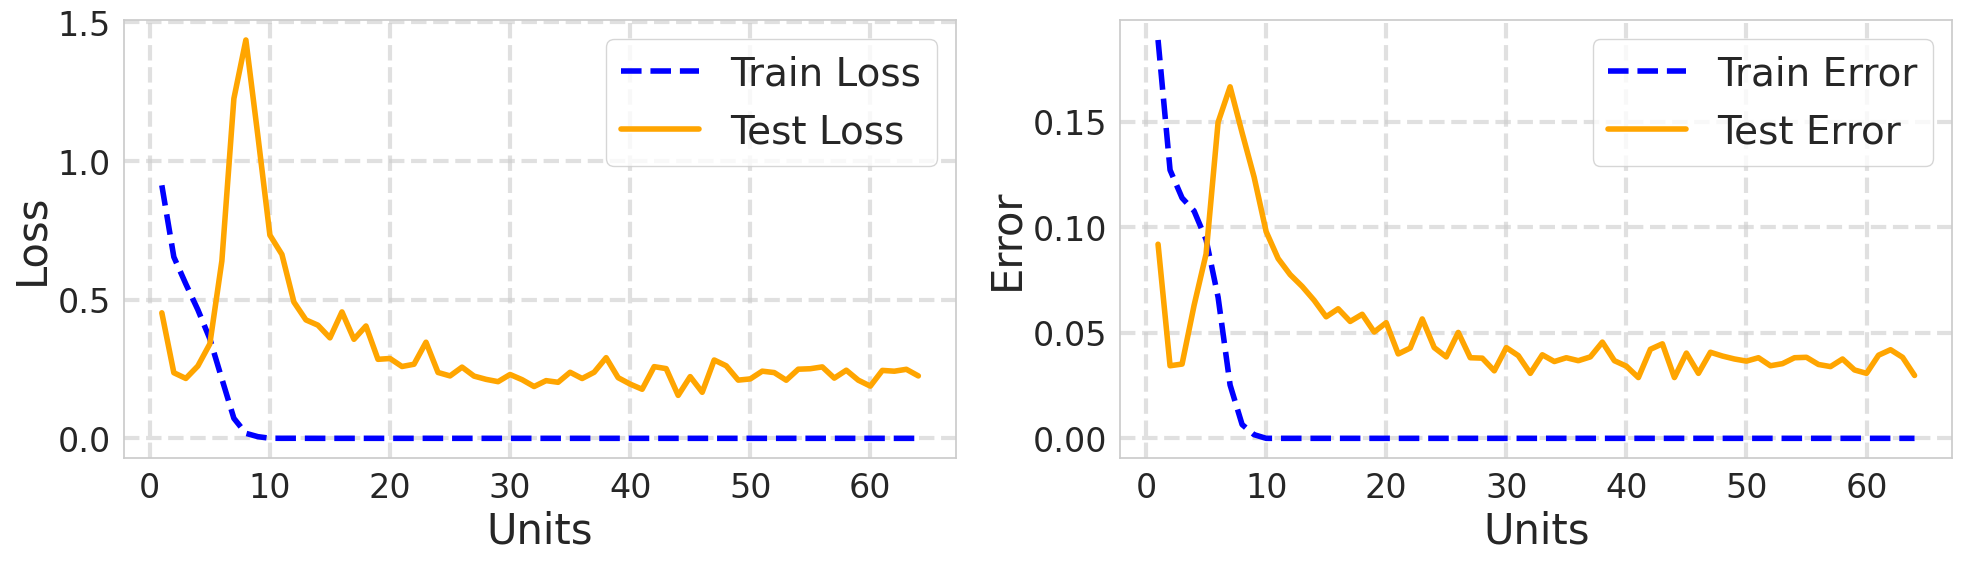

In [485]:
epoch = 1000
df_train_filtered, df_test_filtered = filter_by_epoch(df_train, df_test, epoch)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="units", title="(3CNN, MNIST ([30000/5000] & 10% label noise))")

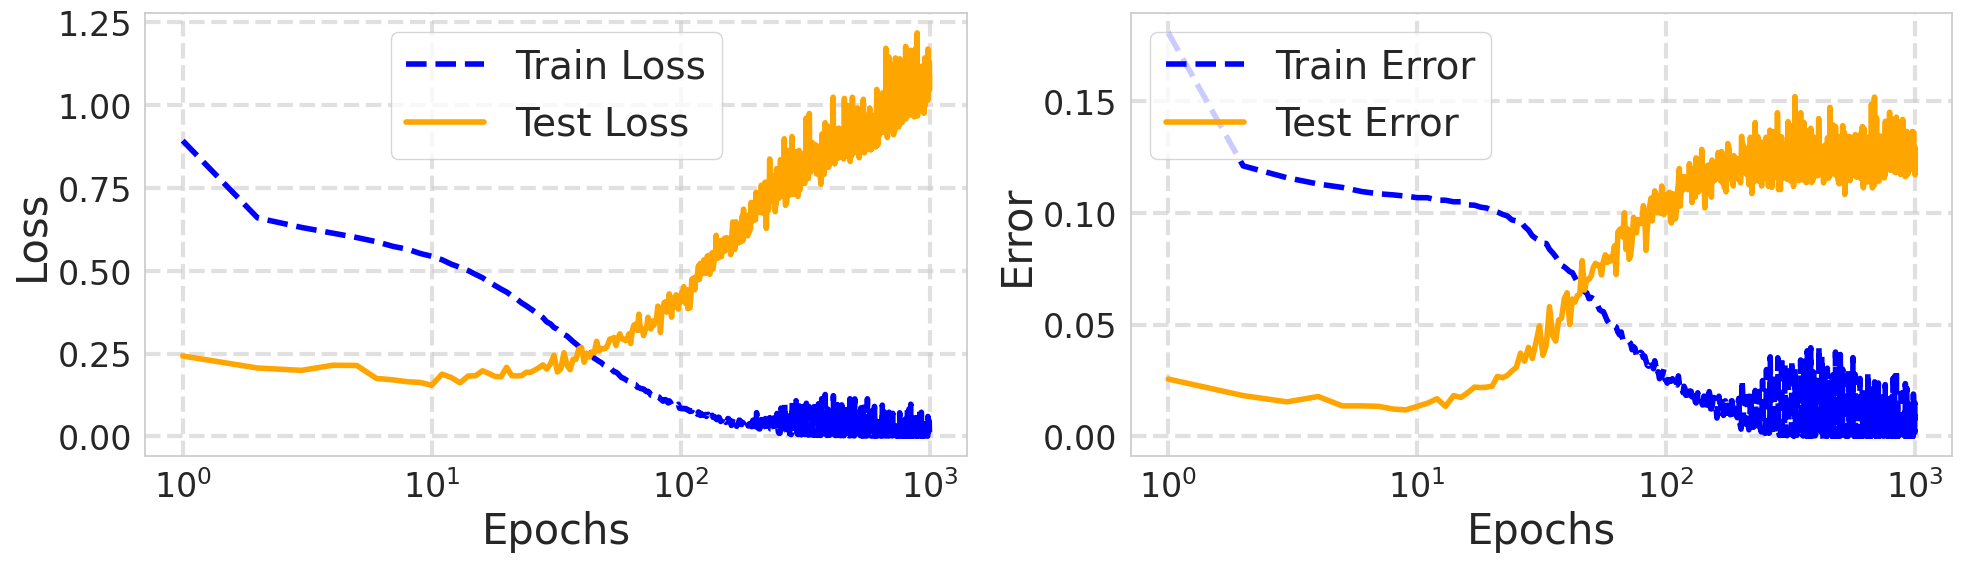

In [486]:
model = 9
df_train_filtered, df_test_filtered = filter_by_model(df_train, df_test, model)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="epochs", title=f"(3CNN(k={model}) - MNIST ([30000/5000] & 10% label noise))")

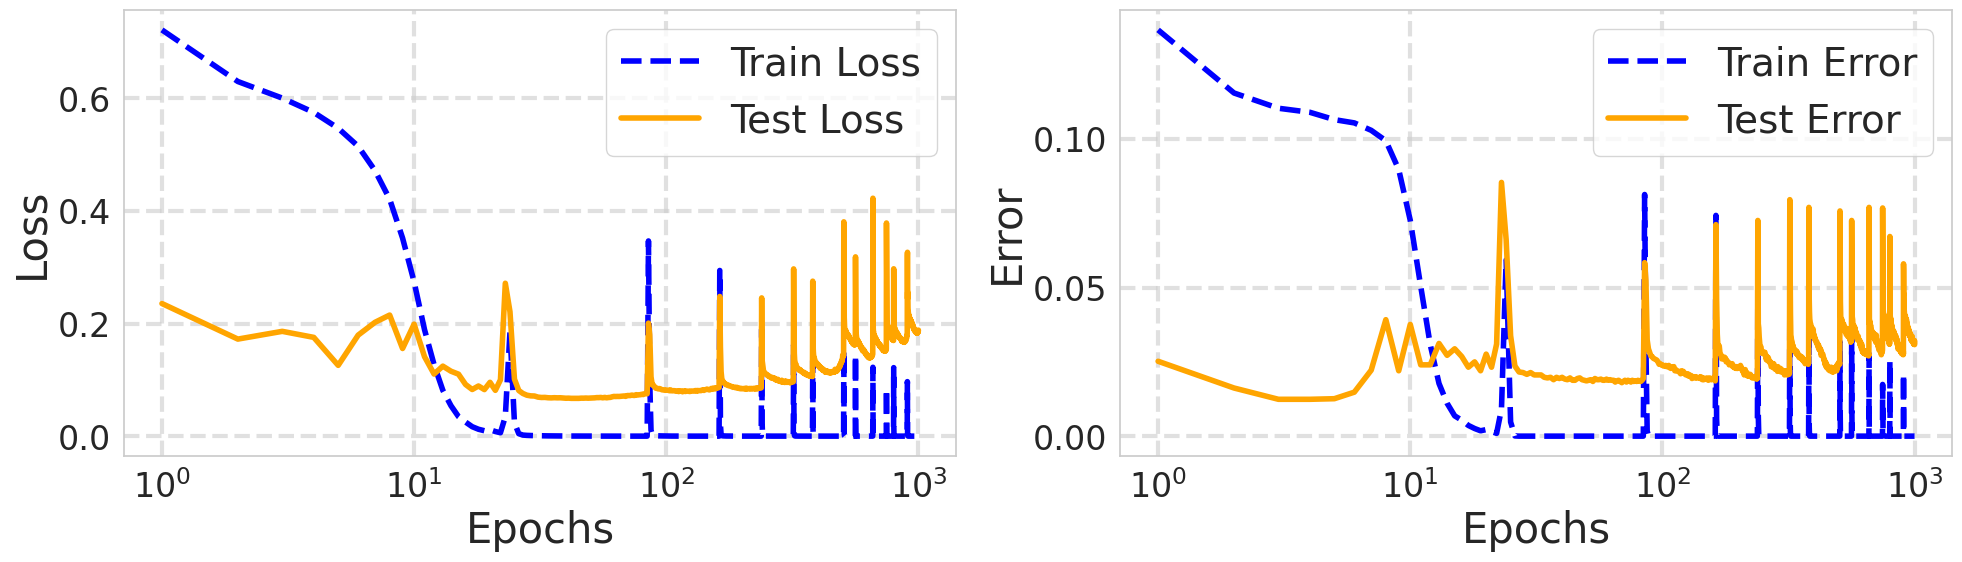

In [487]:
model = 60
df_train_filtered, df_test_filtered = filter_by_model(df_train, df_test, model)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="epochs", title=f"(3CNN(k={model}) - MNIST ([30000/5000] & 10% label noise))")

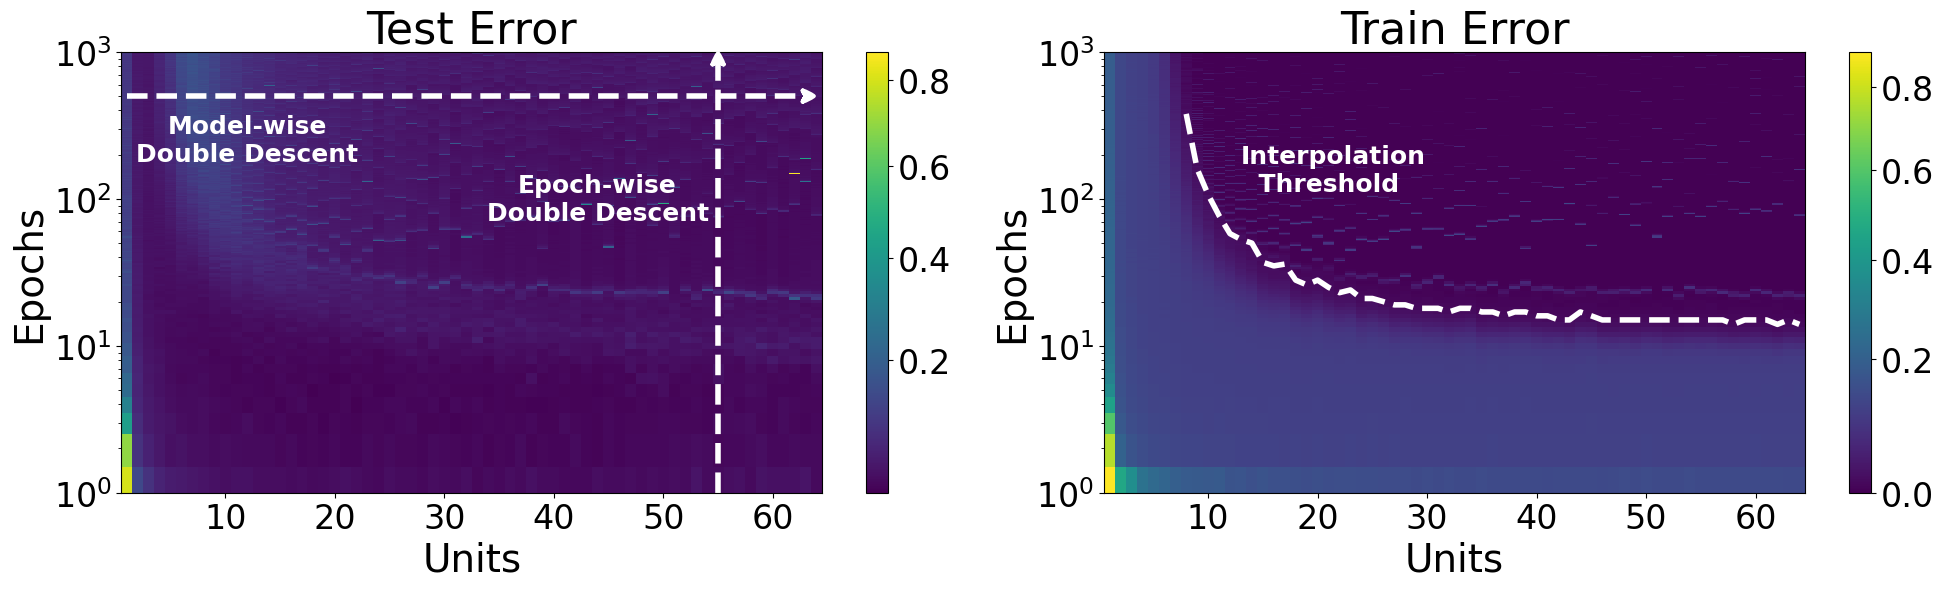

In [488]:
plot_train_test_error_heatmap(df_train, df_test, threshold_value=0.01, colormap="viridis", gamma=0.8, xlabel="Units", ylabel="Epochs", title="(3CNN, MNIST ([30000/5000] & 10% label noise))")

## **CIFAR10 [25000/5000]**

In [489]:
file_base_name = 'simple3CNN_cifar1025k_020noise_noda_128bs'
dataframes = load_data_from_files(file_base_name, drive_path, net)

df_train = dataframes["train"]
df_test = dataframes["test"]

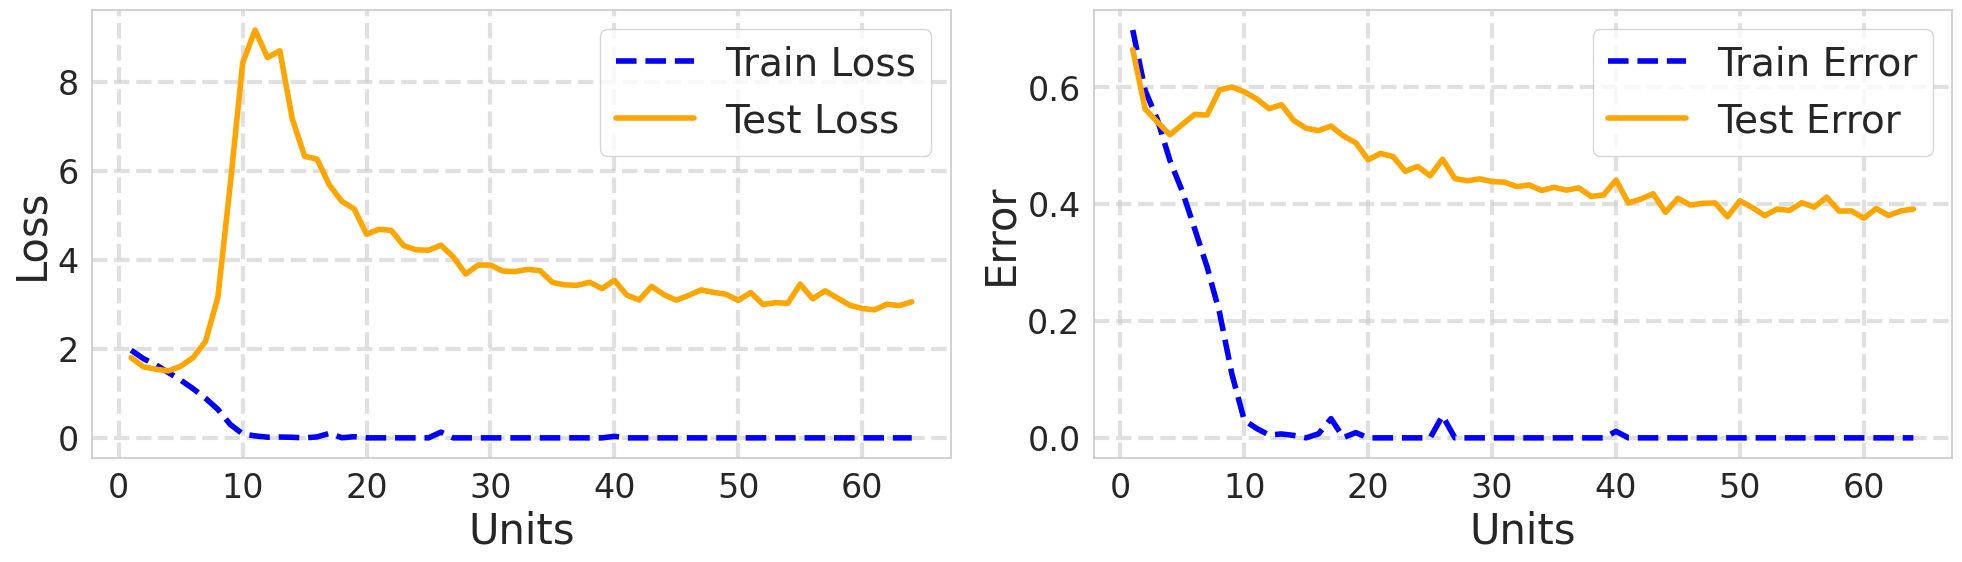

In [490]:
epoch = 1000
df_train_filtered, df_test_filtered = filter_by_epoch(df_train, df_test, epoch)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="units", title="(3CNN, CIFAR10 ([25000/5000] & 20% label noise))")

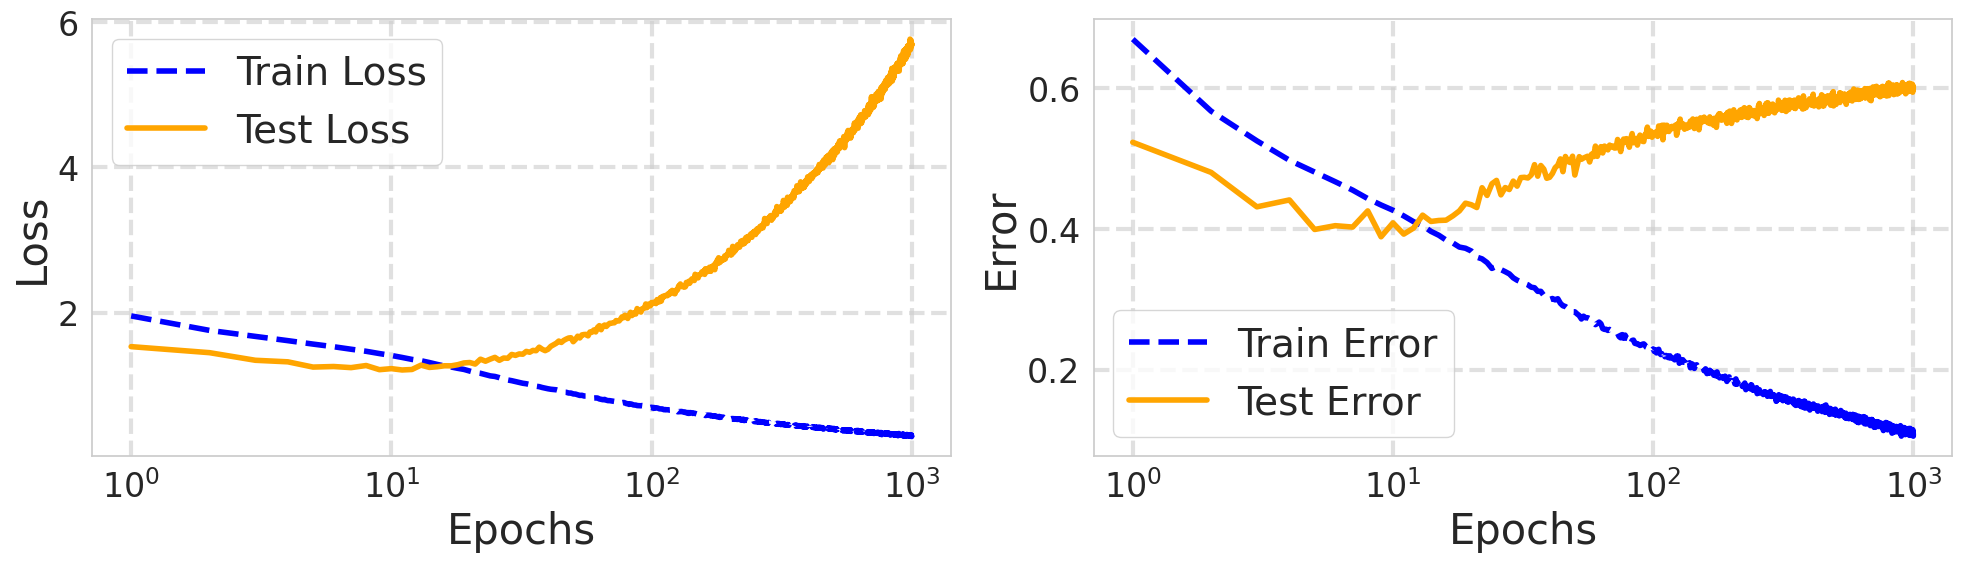

In [491]:
model = 9
df_train_filtered, df_test_filtered = filter_by_model(df_train, df_test, model)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="epochs", title=f"(3CNN(k={model}) - CIFAR10 ([25000/5000] & 20% label noise))")

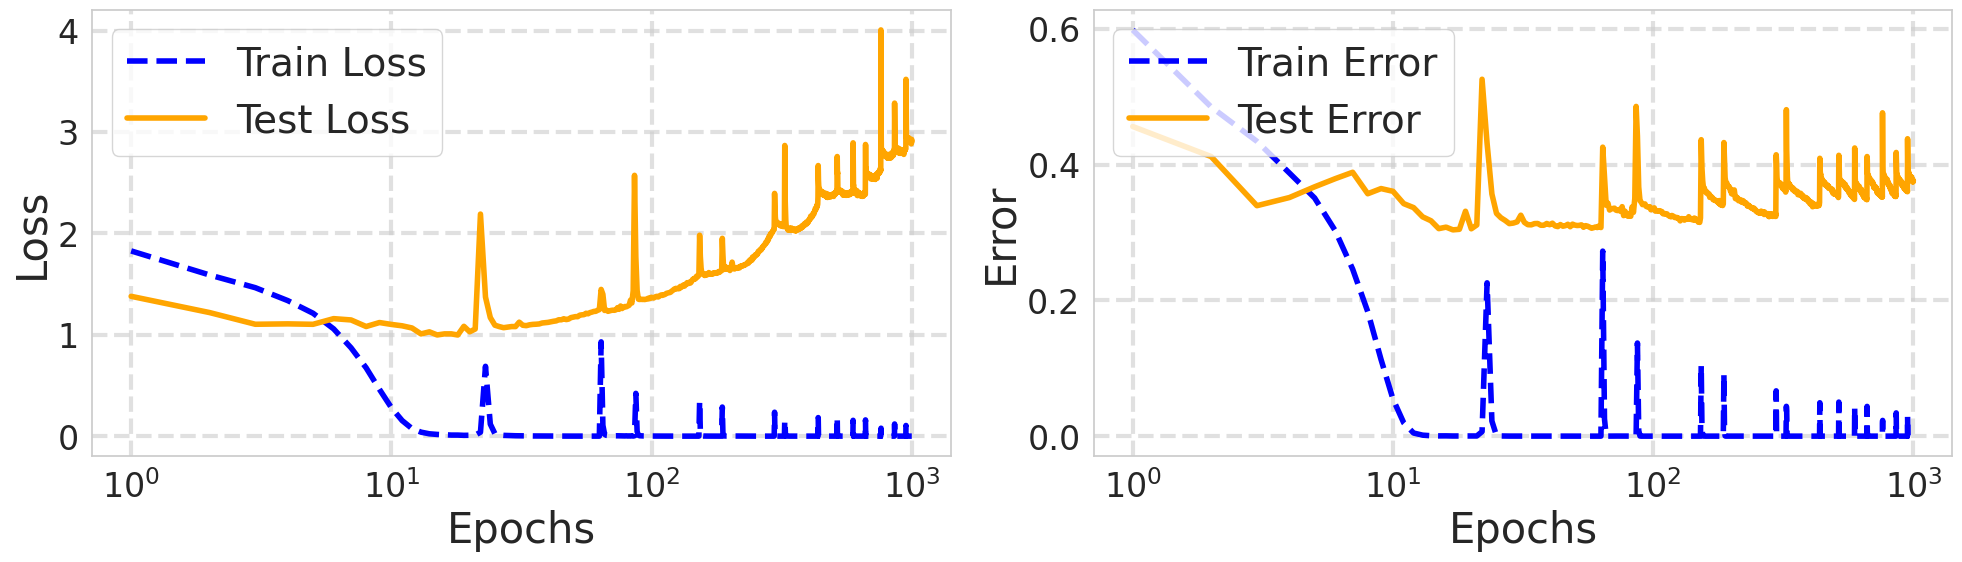

In [492]:
model = 60
df_train_filtered, df_test_filtered = filter_by_model(df_train, df_test, model)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="epochs", title=f"(3CNN(k={model}) - CIFAR10 ([25000/5000] & 20% label noise))")

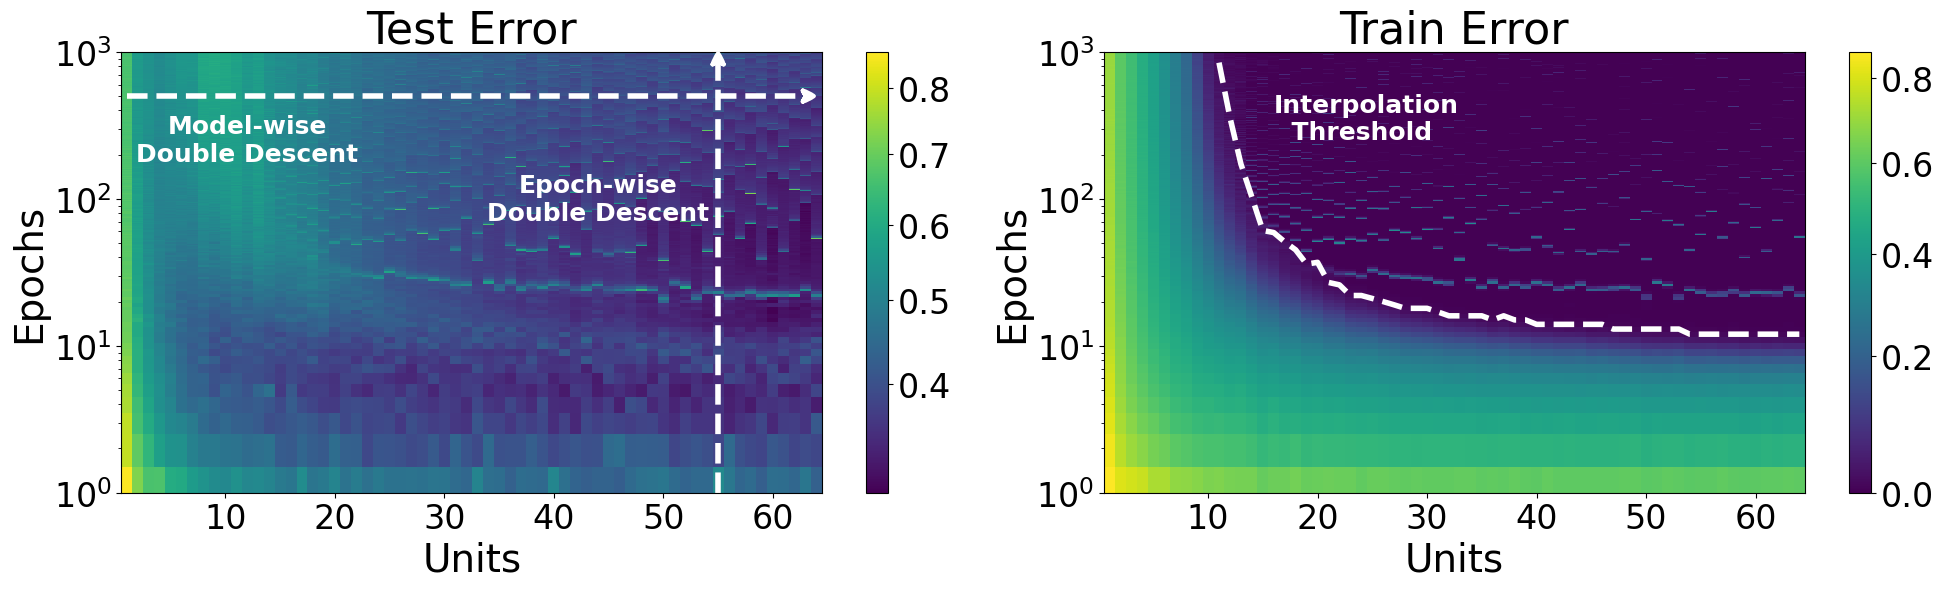

In [493]:
plot_train_test_error_heatmap(df_train, df_test, threshold_value=0.01, colormap="viridis", gamma=0.8, xlabel="Units", ylabel="Epochs", title="(3CNN, CIFAR10 ([25000/5000] & 20% label noise))")

## **CIFAR100 [25000/5000]**


In [494]:
file_base_name = 'simple3CNN_cifar10025k_020noise_noda_128bs'
dataframes = load_data_from_files(file_base_name, drive_path, net)

df_train = dataframes["train"]
df_test = dataframes["test"]

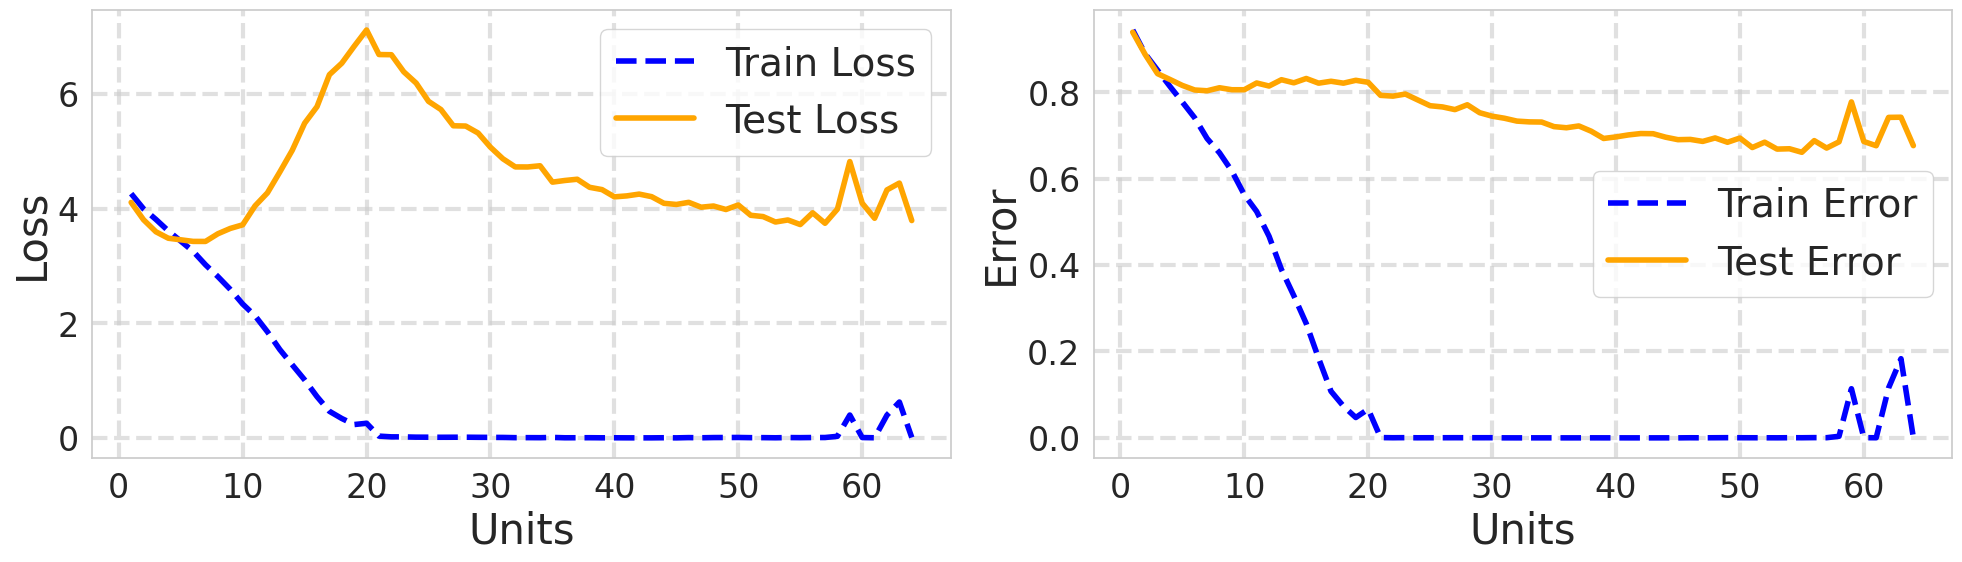

In [495]:
epoch = 100
df_train_filtered, df_test_filtered = filter_by_epoch(df_train, df_test, epoch)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="units", title="(3CNN, CIFAR100 ([25000/5000] & 20% label noise))")

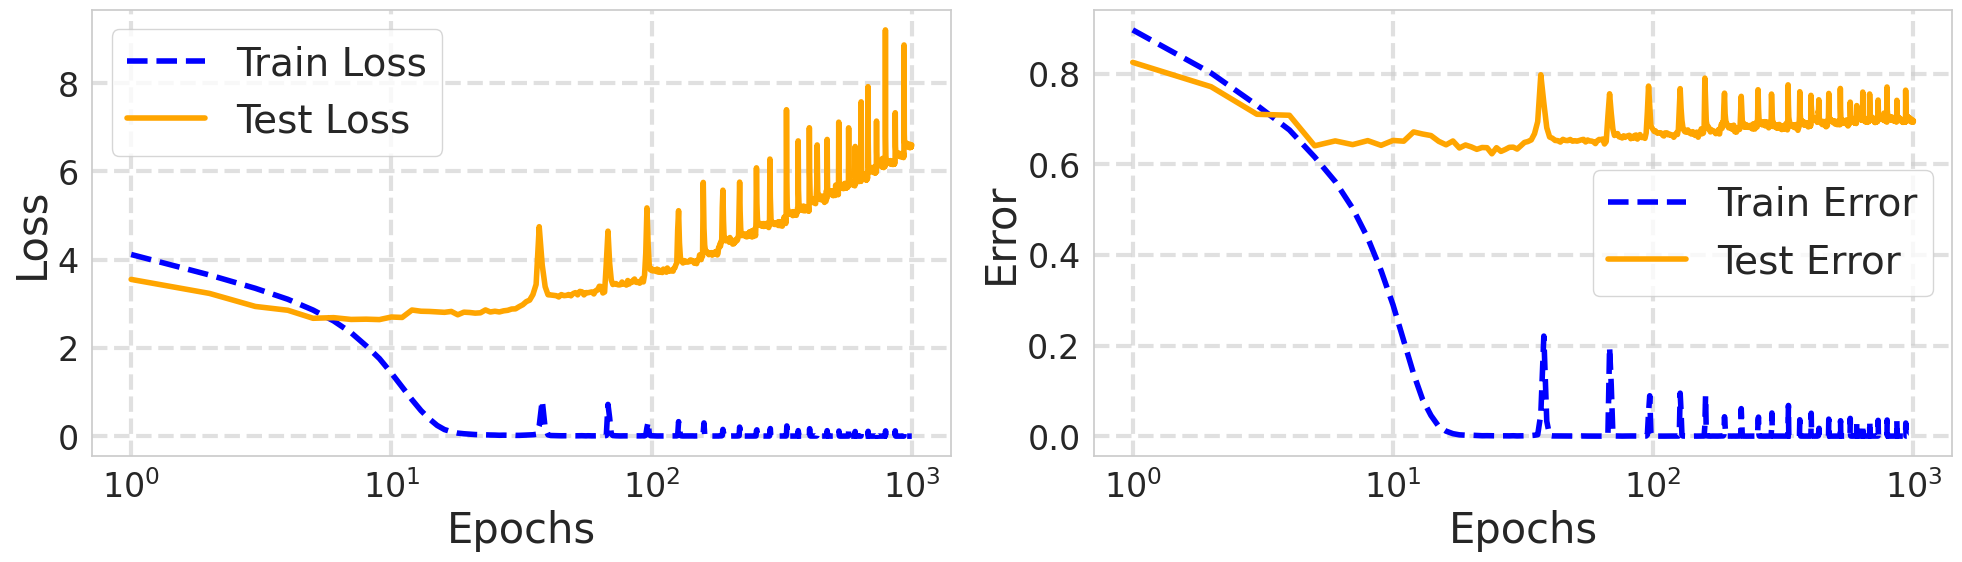

In [496]:
model = 64
df_train_filtered, df_test_filtered = filter_by_model(df_train, df_test, model)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="epochs", title=f"(3CNN(k={model}) - CIFAR100 ([25000/5000] & 20% label noise))")

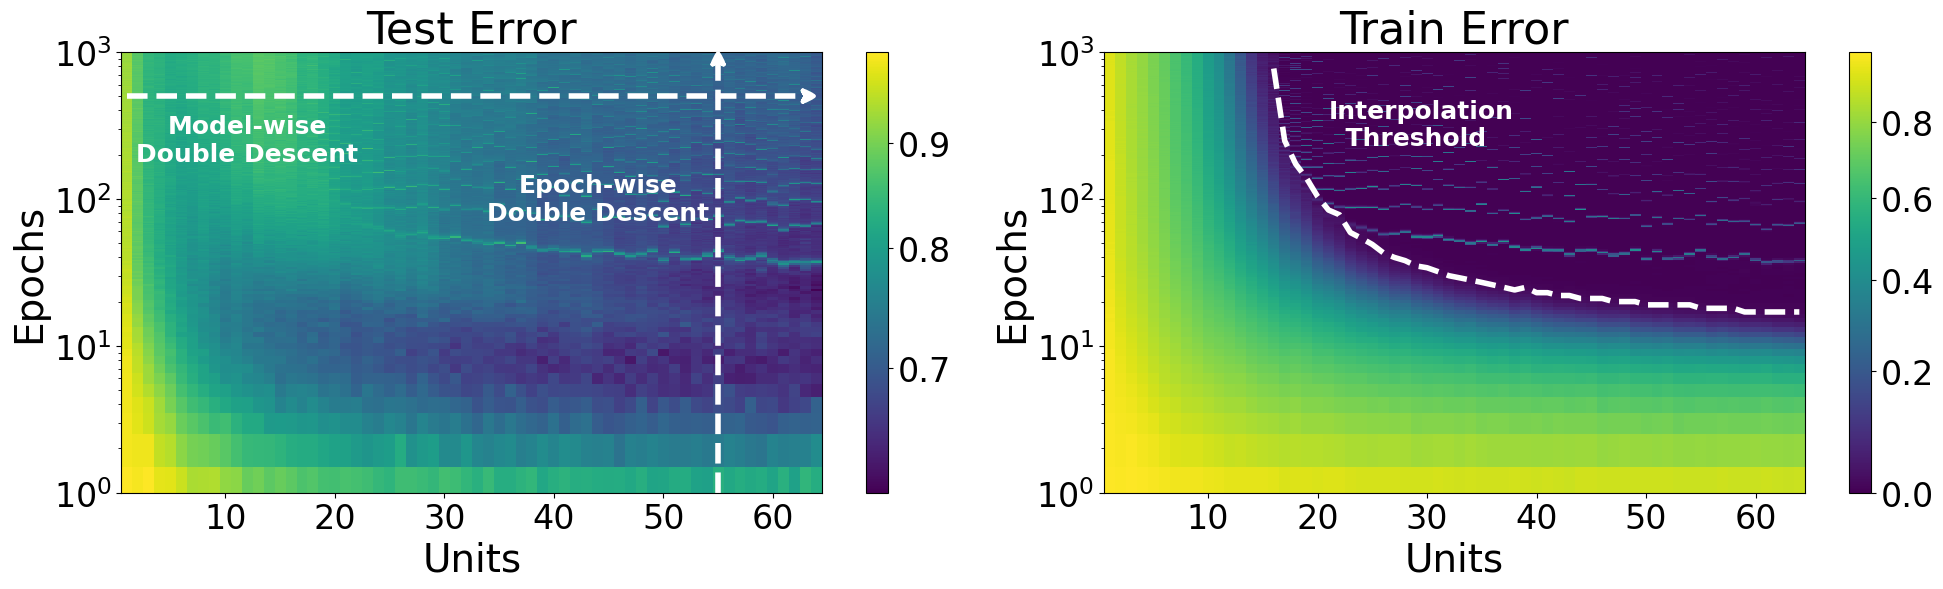

In [497]:
plot_train_test_error_heatmap(df_train, df_test, threshold_value=0.01, colormap="viridis", gamma=0.8, xlabel="Units", ylabel="Epochs", title="(3CNN, CIFAR100 ([25000/5000] & 20% label noise))")

## **CIFAR100**

In [498]:
file_base_name = 'simple3CNN_cifar100_020noise_noda_128bs'
dataframes = load_data_from_files(file_base_name, drive_path, net)

df_train = dataframes["train"]
df_test = dataframes["test"]

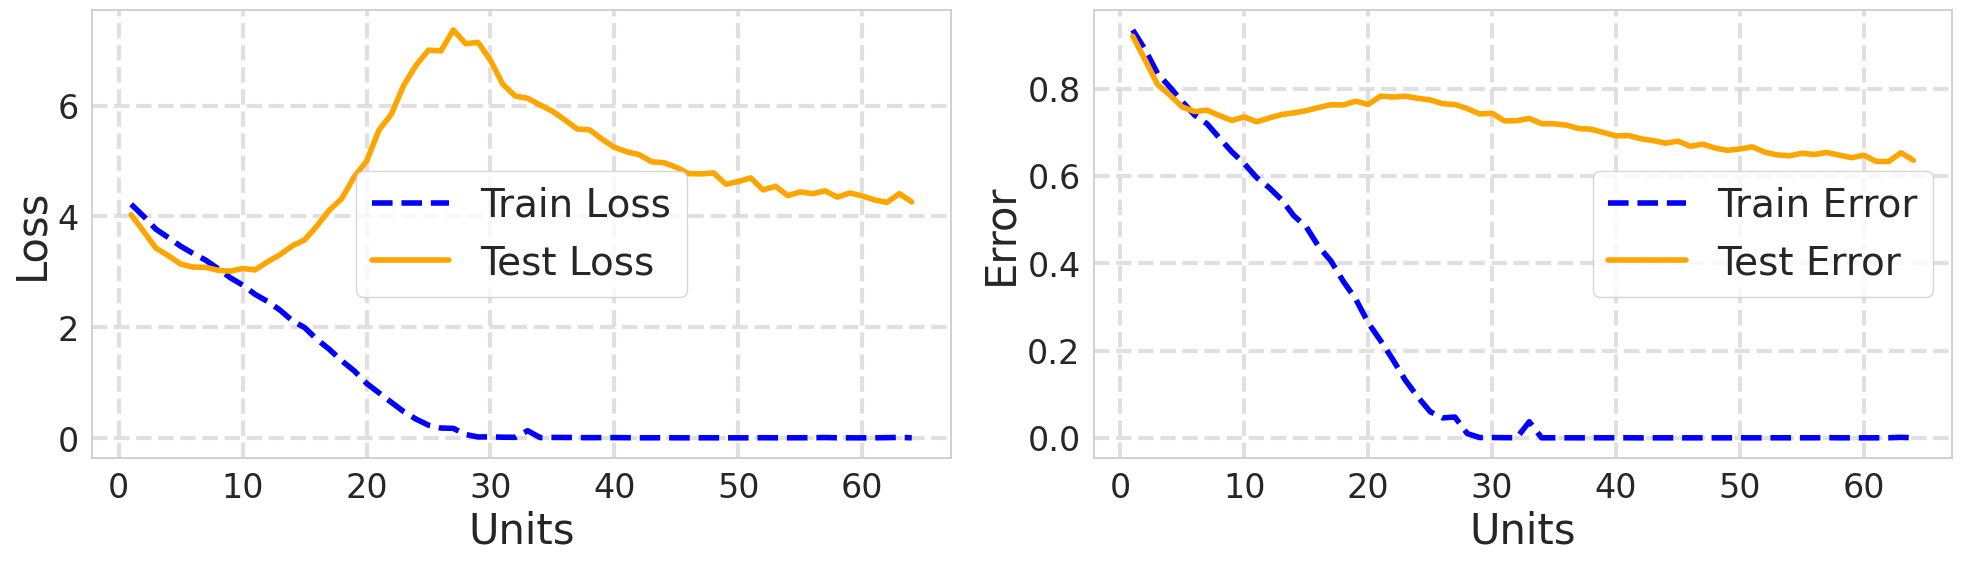

In [499]:
epoch = 100
df_train_filtered, df_test_filtered = filter_by_epoch(df_train, df_test, epoch)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="units", title="(3CNN, CIFAR100 (20% label noise))")

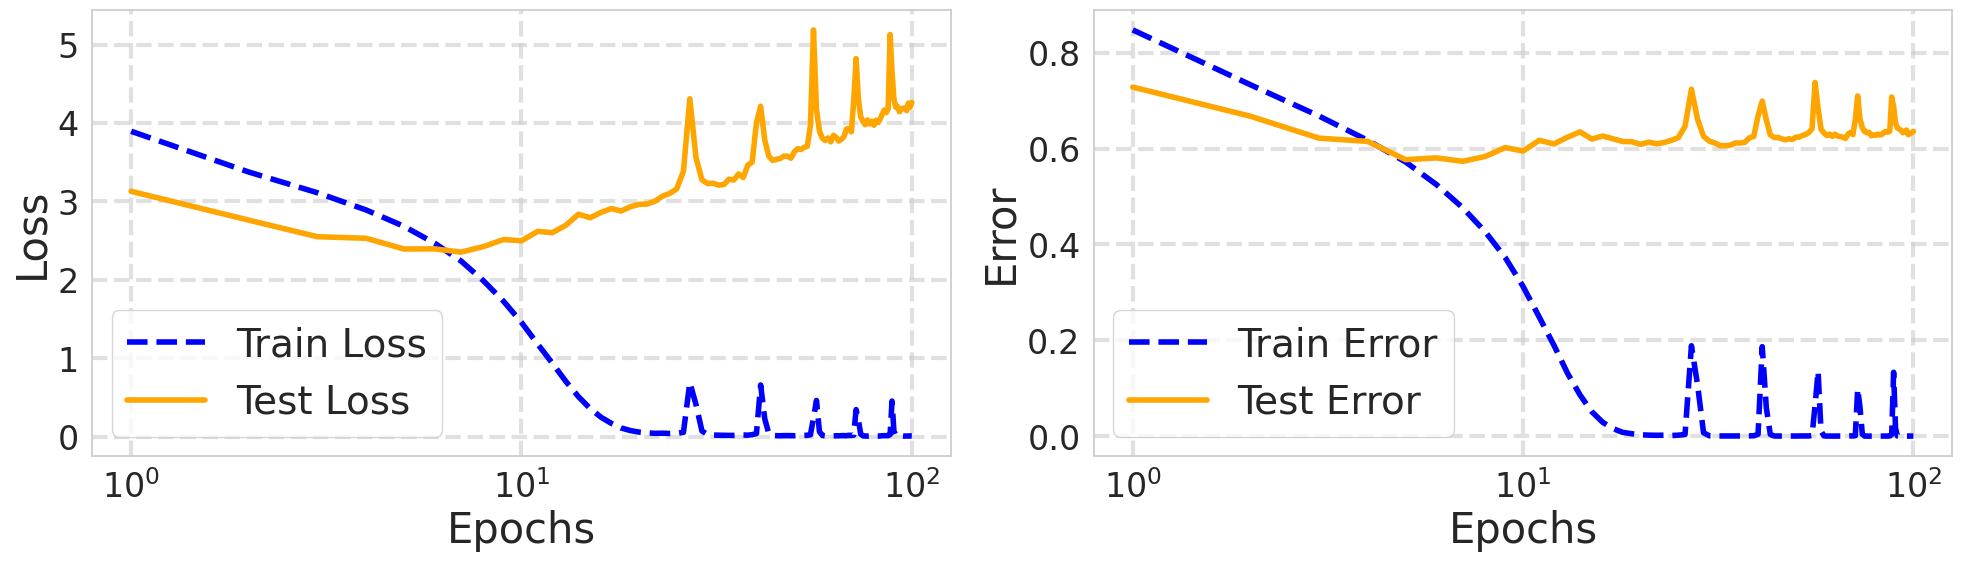

In [500]:
model = 64
df_train_filtered, df_test_filtered = filter_by_model(df_train, df_test, model)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="epochs", title=f"(3CNN(k={model}) - CIFAR100 (20% label noise))")

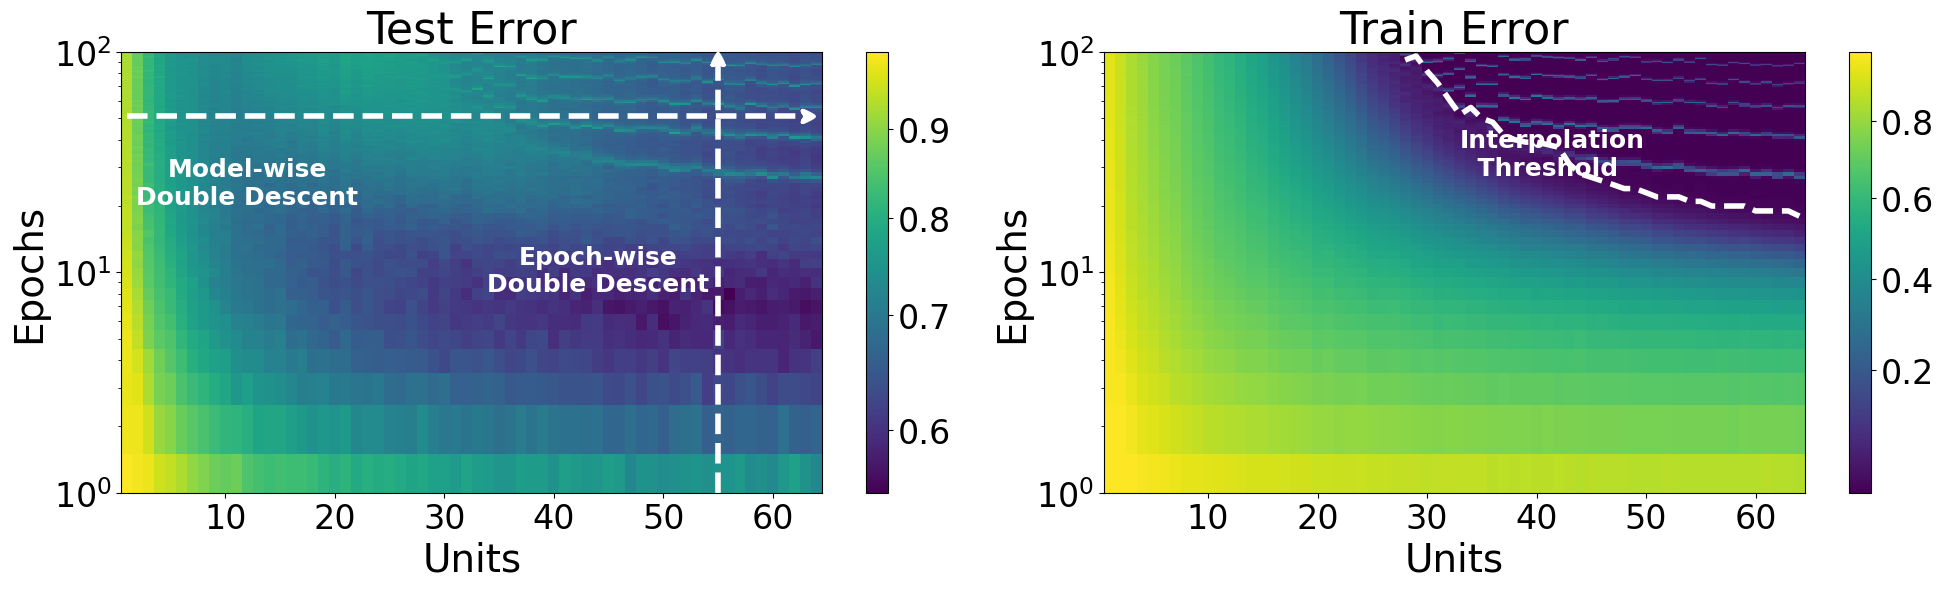

In [501]:
plot_train_test_error_heatmap(df_train, df_test, threshold_value=0.01, colormap="viridis", gamma=0.8, xlabel="Units", ylabel="Epochs", title="(3CNN, CIFAR100 (20% label noise))")

# **DeepCNN**

In [502]:
class DeepCNN(nn.Module):
  def __init__(self, in_channels, k, num_classes):
    super(DeepCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, k, kernel_size=7, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(k)
    self.relu1 = nn.ReLU()

    self.conv2 = nn.Conv2d(k, k, kernel_size=7, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(k)
    self.relu2 = nn.ReLU()

    self.conv3 = nn.Conv2d(k, k, kernel_size=7, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(k)
    self.relu3 = nn.ReLU()

    self.conv4 = nn.Conv2d(k, k, kernel_size=7, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(k)
    self.relu4 = nn.ReLU()

    self.conv5 = nn.Conv2d(k, k, kernel_size=5, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(k)
    self.relu5 = nn.ReLU()

    self.conv6 = nn.Conv2d(k, k, kernel_size=5, stride=1, padding=1)
    self.bn6 = nn.BatchNorm2d(k)
    self.relu6 = nn.ReLU()

    self.conv7 = nn.Conv2d(k, k, kernel_size=3, stride=1)
    self.bn7 = nn.BatchNorm2d(k)
    self.relu7 = nn.ReLU()

    self.conv8 = nn.Conv2d(k, k, kernel_size=3, stride=1)
    self.bn8 = nn.BatchNorm2d(k)
    self.relu8 = nn.ReLU()

    self.conv9 = nn.Conv2d(k, 2*k, kernel_size=3, stride=1)
    self.bn9 = nn.BatchNorm2d(2*k)
    self.relu9 = nn.ReLU()

    self.conv10 = nn.Conv2d(2*k, 2*k, kernel_size=3, stride=1)
    self.bn10 = nn.BatchNorm2d(2*k)
    self.relu10 = nn.ReLU()

    self.pool = nn.MaxPool2d(4)

    self.flatten = nn.Flatten()
    self.fc = nn.Linear(2*k, num_classes)

  def forward(self, x):
    x = self.relu1(self.bn1(self.conv1(x)))
    x = self.relu2(self.bn2(self.conv2(x)))
    x = self.relu3(self.bn3(self.conv3(x)))
    x = self.relu4(self.bn4(self.conv4(x)))
    x = self.relu5(self.bn5(self.conv5(x)))
    x = self.relu6(self.bn6(self.conv6(x)))
    x = self.relu7(self.bn7(self.conv7(x)))
    x = self.relu8(self.bn8(self.conv8(x)))
    x = self.relu9(self.bn9(self.conv9(x)))
    x = self.pool(self.relu10(self.bn10(self.conv10(x))))

    x = self.flatten(x)
    x = self.fc(x)
    return x

def create_deep_cnn(in_channels, size, num_classes):
  model = DeepCNN(in_channels=in_channels, k=size, num_classes=num_classes)
  return model

In [503]:
net = create_deep_cnn(in_channels=3, size=64, num_classes=10)
input = (3, 32, 32)
summary(net, input)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           9,472
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4           [-1, 64, 24, 24]         200,768
       BatchNorm2d-5           [-1, 64, 24, 24]             128
              ReLU-6           [-1, 64, 24, 24]               0
            Conv2d-7           [-1, 64, 20, 20]         200,768
       BatchNorm2d-8           [-1, 64, 20, 20]             128
              ReLU-9           [-1, 64, 20, 20]               0
           Conv2d-10           [-1, 64, 16, 16]         200,768
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 14, 14]         102,464
      BatchNorm2d-14           [-1, 64,

In [504]:
net = "DeepCNN"

### **CIFAR10 [25000/5000]**

In [517]:
file_base_name = 'deepCNN_cifar1025k_020noise_noda_128bs'
dataframes = load_data_from_files(file_base_name, drive_path, net)

df_train = dataframes["train"]
df_test = dataframes["test"]

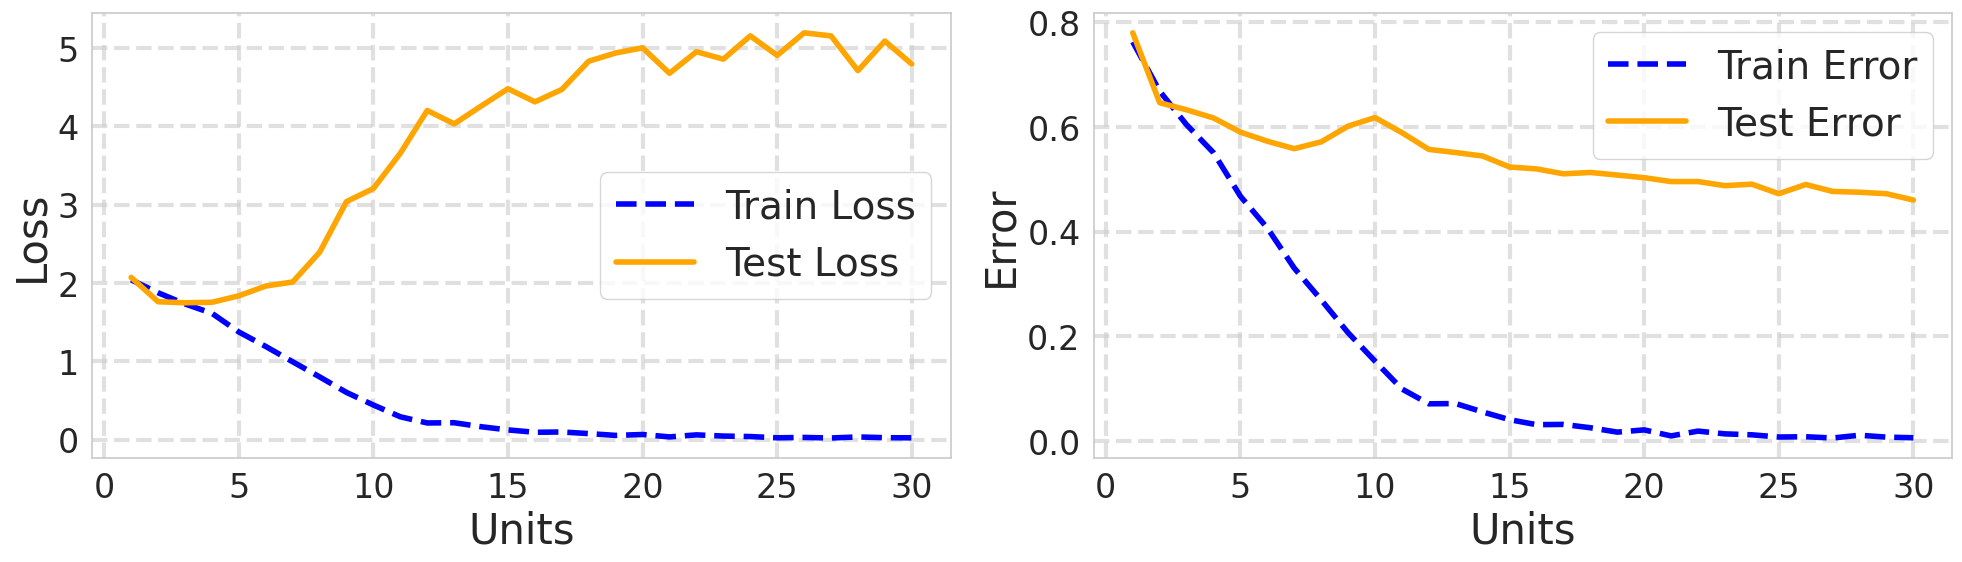

In [518]:
epoch = 1000
df_train_filtered, df_test_filtered = filter_by_epoch(df_train, df_test, epoch)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="units", title="(DeepCNN, CIFAR10 ([25000/5000] & 20% label noise))")

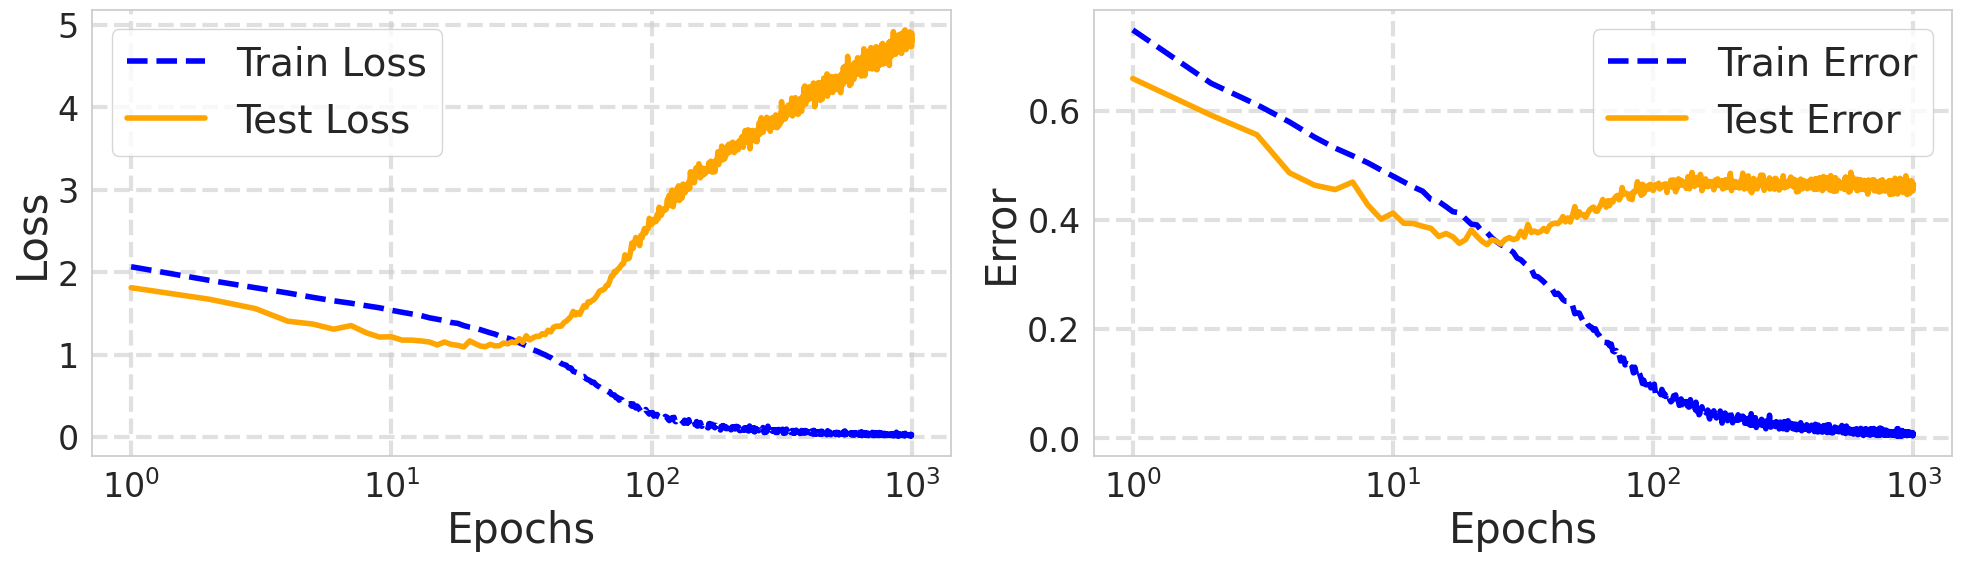

In [519]:
model = 30
df_train_filtered, df_test_filtered = filter_by_model(df_train, df_test, model)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="epochs", title=f"(DeepCNN(k={model}) - CIFAR10 ([25000/5000] & 20% label noise))")

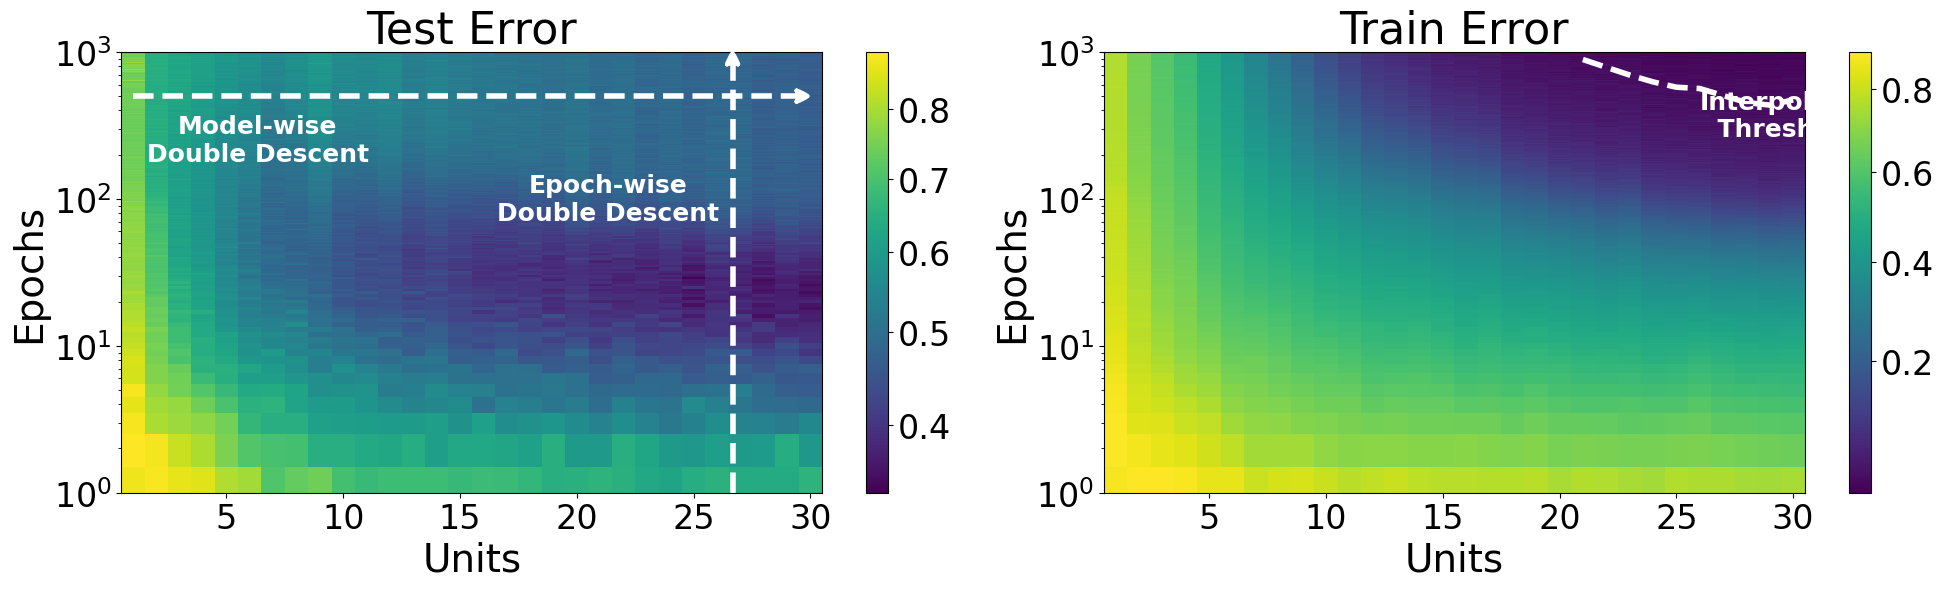

In [520]:
plot_train_test_error_heatmap(df_train, df_test, threshold_value=0.01, colormap="viridis", gamma=0.8, xlabel="Units", ylabel="Epochs", title="(DeepCNN, CIFAR10 ([25000/5000] & 20% label noise))")

## **3CNN vs DeepCNN**

In [521]:
net1 = "3CNN"
file_base_name1 = 'simple3CNN_cifar1025k_020noise_noda_128bs'
dataframes = load_data_from_files(file_base_name1, drive_path, net1)

df_train1 = dataframes["train"]
df_test1 = dataframes["test"]

In [522]:
net2 = "DeepCNN"
file_base_name2 = 'deepCNN_cifar1025k_020noise_noda_128bs'
dataframes = load_data_from_files(file_base_name2, drive_path, net2)

df_train2 = dataframes["train"]
df_test2 = dataframes["test"]

In [523]:
df_train1_filtered = df_train1[df_train1["epochs"] == 1000]
df_test1_filtered = df_test1[df_test1["epochs"] == 1000]
df_train2_filtered = df_train2[df_train2["epochs"] == 1000]
df_test2_filtered = df_test2[df_test2["epochs"] == 1000]

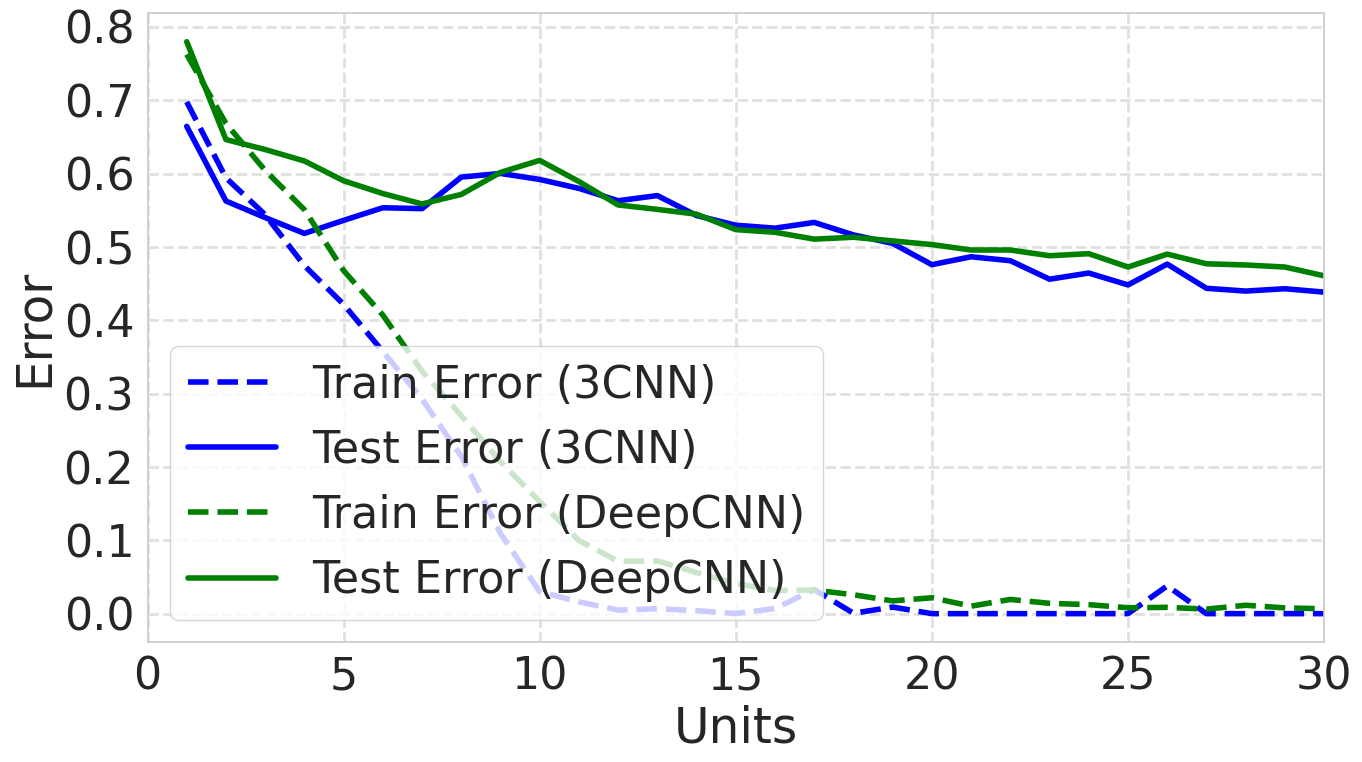

In [524]:
sns.set(style="whitegrid", context="notebook", font_scale=1.6)
plt.figure(figsize=(14, 8))

plt.plot(df_train1_filtered["units"], df_train1_filtered["train_error"], label="Train Error (3CNN)", color="blue", linestyle="--", linewidth=4)
plt.plot(df_test1_filtered["units"], df_test1_filtered["test_error"], label="Test Error (3CNN)", color="blue", linewidth=4)
plt.plot(df_train2_filtered["units"], df_train2_filtered["train_error"], label="Train Error (DeepCNN)", color="green", linestyle="--", linewidth=4)
plt.plot(df_test2_filtered["units"], df_test2_filtered["test_error"], label="Test Error (DeepCNN)", color="green", linewidth=4)

plt.xlabel("Units", fontsize=35)
plt.ylabel("Error", fontsize=35)

plt.xlim(0, 30)
plt.legend(fontsize=32, loc="lower left")

plt.grid(True, linestyle='--', alpha=0.6, linewidth=2)

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)

# plt.title("Train and Test error by units (3CNN & DeepCNN, CIFAR10 ([25000/5000] & 20% label noise))", fontsize=18, fontweight="bold")

plt.tight_layout()
plt.show()

# **PreActResNet18**

In [525]:
class PreActBlock(nn.Module):
  expansion = 1

  def __init__(self, in_planes, planes, stride=1, **kwargs):
    super(PreActBlock, self).__init__()
    self.bn1 = nn.BatchNorm2d(in_planes)
    self.conv1 = nn.Conv2d(
        in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                            stride=1, padding=1, bias=False)

    if stride != 1 or in_planes != self.expansion*planes:
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_planes, self.expansion*planes,
                      kernel_size=1, stride=stride, bias=False)
        )

  def forward(self, x):
    out = F.relu(self.bn1(x))
    shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
    out = self.conv1(out)
    out = self.conv2(F.relu(self.bn2(out)))
    out += shortcut
    return out

class PreActResNet(nn.Module):
  def __init__(self, block, num_blocks, in_channels, k=64, num_classes=10):
    super(PreActResNet, self).__init__()
    self.in_planes = k
    c = k

    self.conv1 = nn.Conv2d(in_channels, c, kernel_size=3, stride=1, padding=1, bias=False)
    self.layer1 = self._make_layer(block, c, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 2*c, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 4*c, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 8*c, num_blocks[3], stride=2)
    self.linear = nn.Linear(8*c*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    # eg: [2, 1, 1, ..., 1]. Only the first one downsamples.
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
        layers.append(block(self.in_planes, planes, stride))
        self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = self.conv1(x)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

def make_resnet18(in_channels=3, k=64, num_classes=10) -> PreActResNet:
  ''' Returns a ResNet18 with width parameter k. (k=64 is standard ResNet18)'''
  return PreActResNet(PreActBlock, [2, 2, 2, 2], in_channels=in_channels, k=k, num_classes=num_classes)

In [526]:
in_channels = 3
k = 64
num_classes = 10

net = make_resnet18(in_channels=in_channels, k=k, num_classes=num_classes)
input = (3, 32, 32)
summary(net, input)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       PreActBlock-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      PreActBlock-11           [-1, 64, 32, 32]               0
      BatchNorm2d-12           [-1, 64, 32, 32]             128
           Conv2d-13          [-1, 128, 16, 16]           8,192
           Conv2d-14          [-1, 128,

In [527]:
net = "PreActResNet18"

## **MNIST**

In [528]:
file_base_name = 'preActResNet_mnist_010noise_noda_256bs'
dataframes = load_data_from_files(file_base_name, drive_path, net)

df_train = dataframes["train"]
df_test = dataframes["test"]

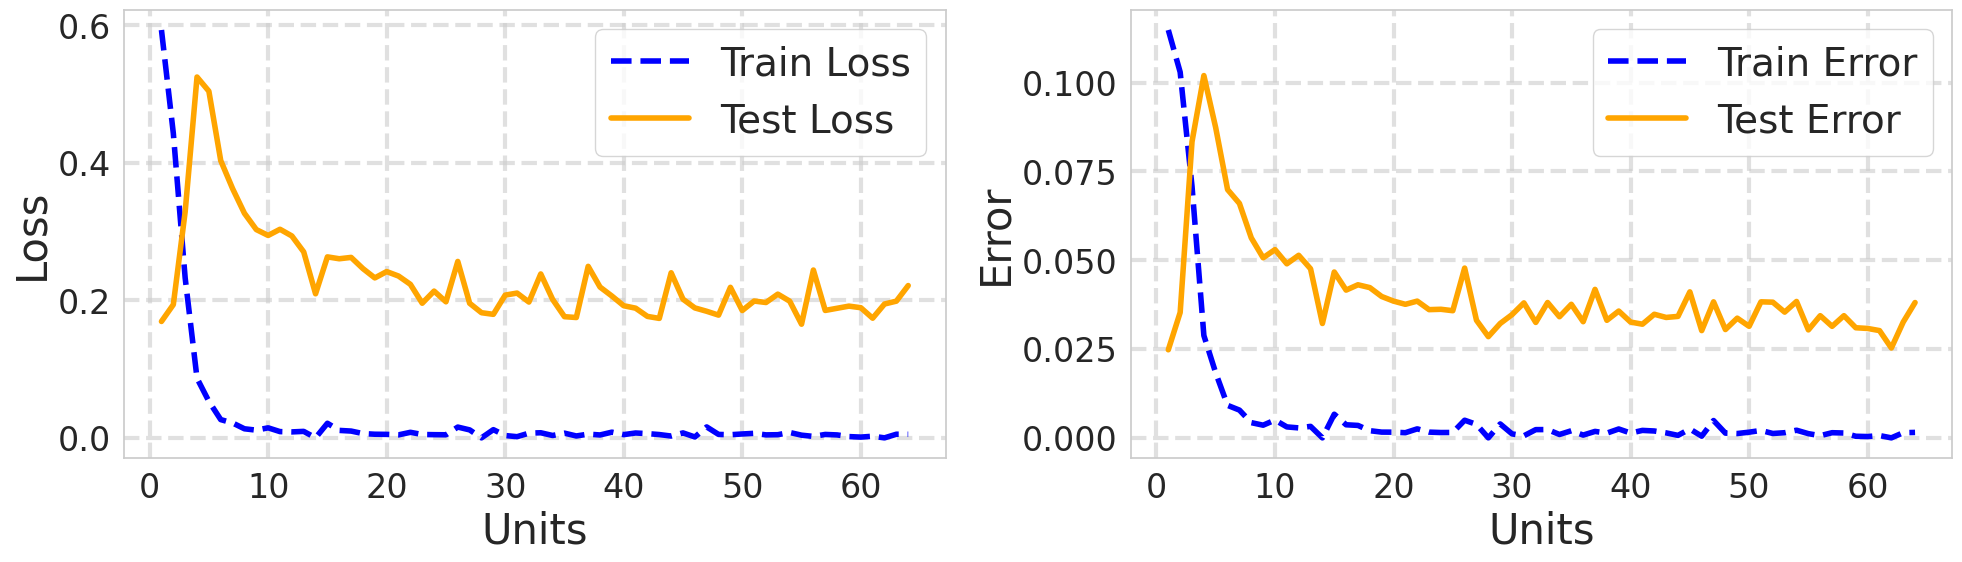

In [529]:
epoch = 200
df_train_filtered, df_test_filtered = filter_by_epoch(df_train, df_test, epoch)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="units", title="(PreActResNet18, MNIST (10% label noise))")

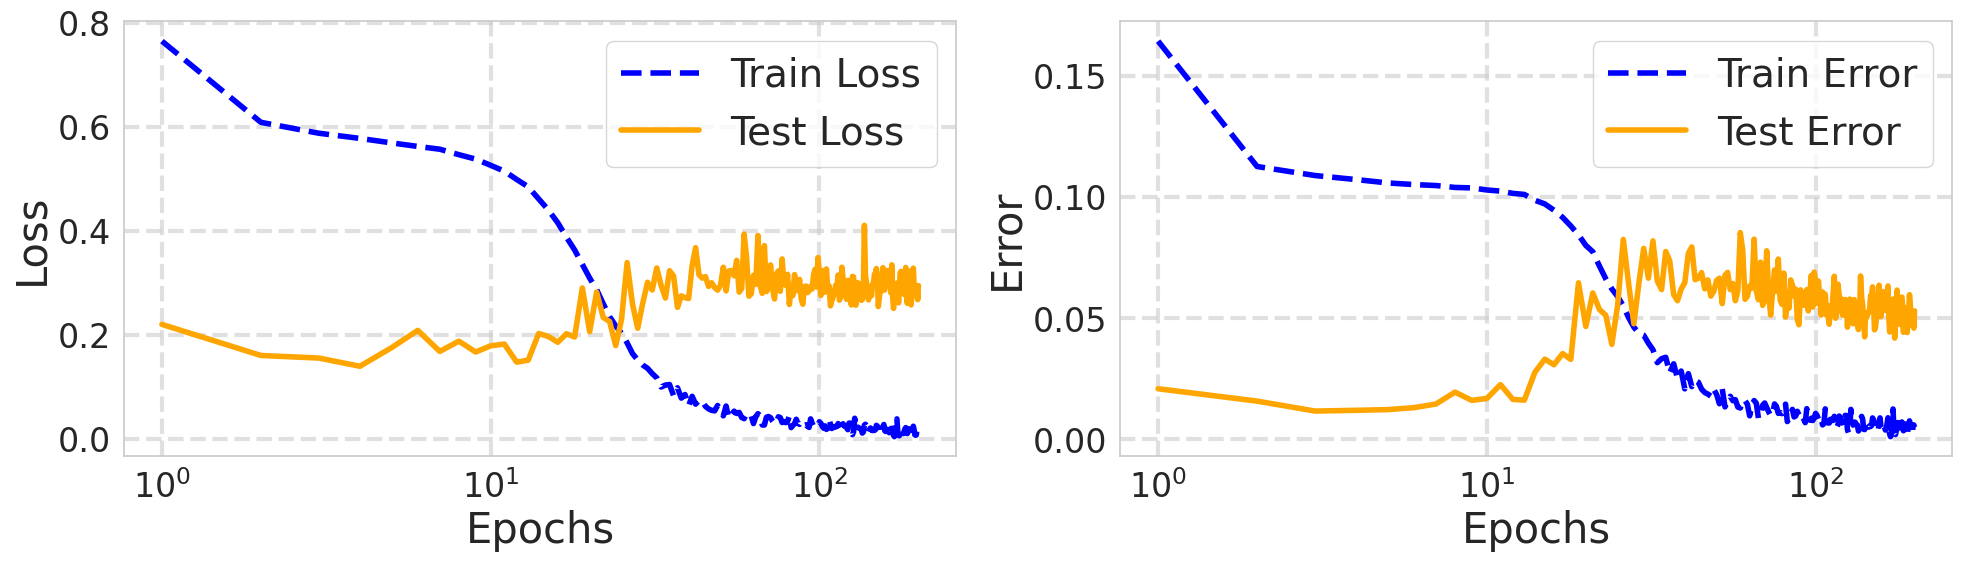

In [530]:
model = 10
df_train_filtered, df_test_filtered = filter_by_model(df_train, df_test, model)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="epochs", title=f"(PreActResNet18(k={model}) - MNIST (10% label noise))")

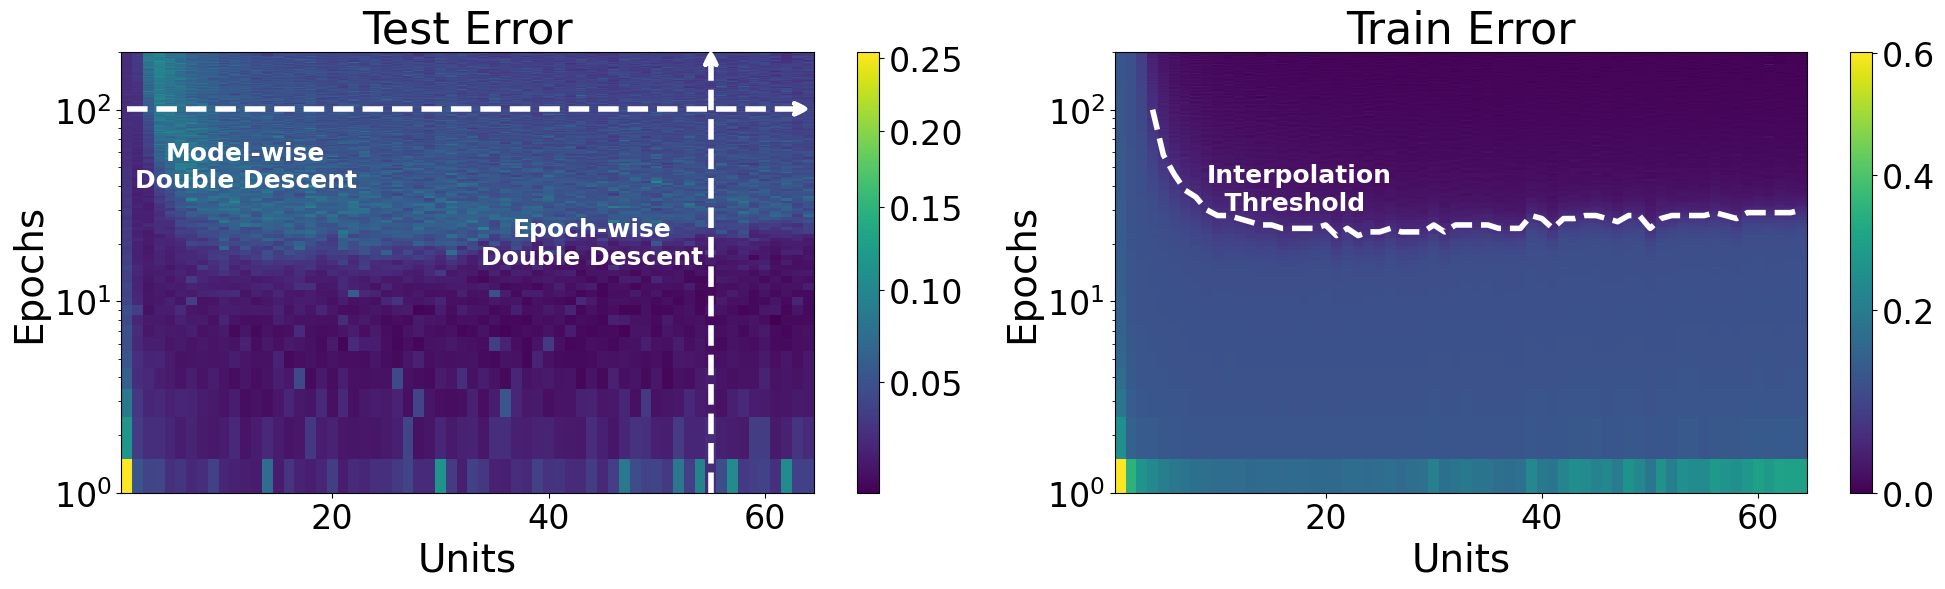

In [531]:
plot_train_test_error_heatmap(df_train, df_test, threshold_value=0.05, colormap="viridis", gamma=0.8, xlabel="Units", ylabel="Epochs", title="(PreActResNet18, MNIST (10% label noise))")

## **CIFAR10**

In [532]:
file_base_name = 'preActResNet_cifar1025k_020noise_noda_256bs'
dataframes = load_data_from_files(file_base_name, drive_path, net)

df_train = dataframes["train"]
df_test = dataframes["test"]

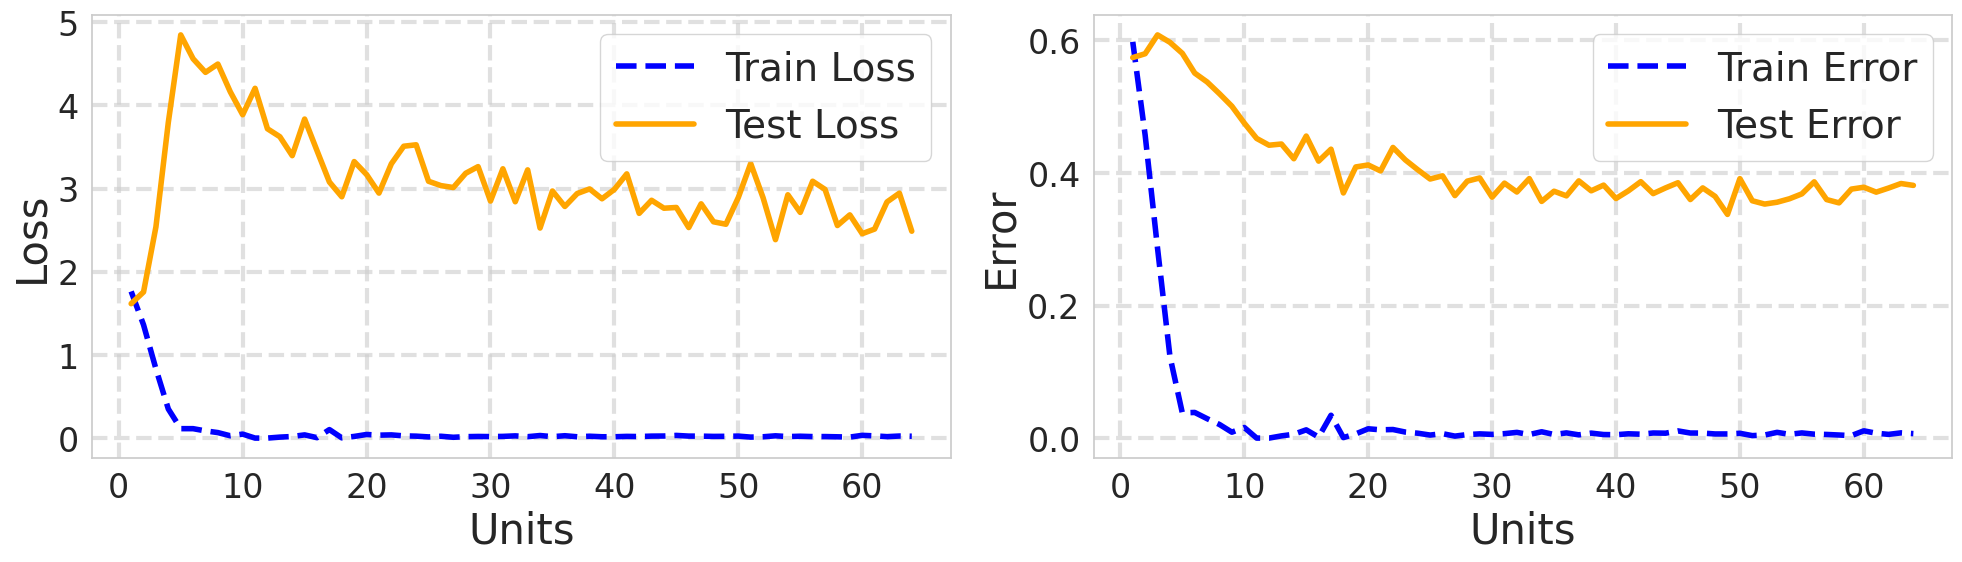

In [533]:
epoch = 100
df_train_filtered, df_test_filtered = filter_by_epoch(df_train, df_test, epoch)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="units", title="(PreActResNet18, CIFAR10 ([25000/5000] & 20% label noise))")

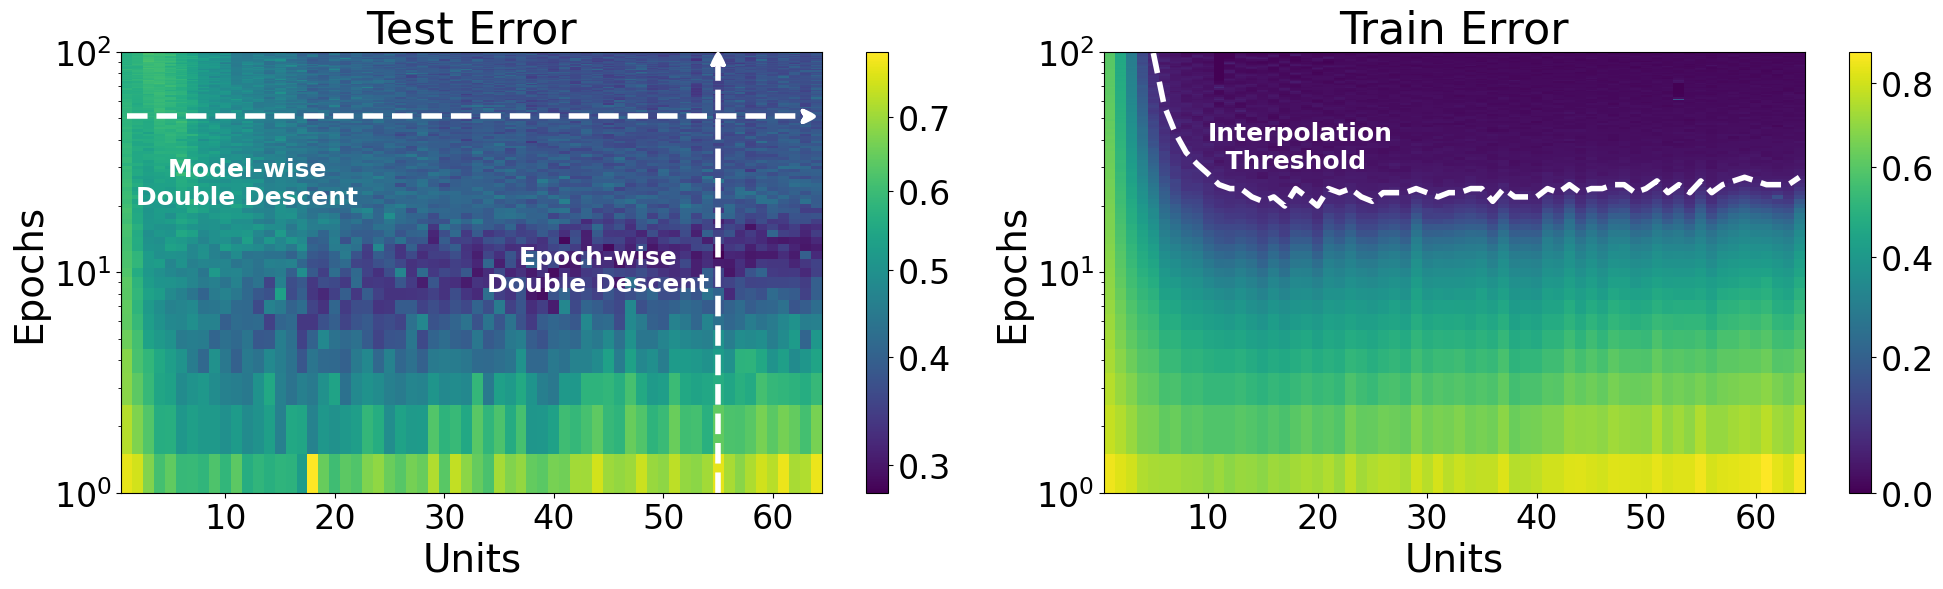

In [534]:
plot_train_test_error_heatmap(df_train, df_test, threshold_value=0.05, colormap="viridis", gamma=0.8, xlabel="Units", ylabel="Epochs", title="(PreActResNet18, CIFAR10 ([25000/5000] & 20% label noise))")

In [535]:
file_base_name = 'PreActResNet18_k45_cifar10_020noise_da_256bs'
dataframes = load_data_from_files(file_base_name, drive_path, net)

df_train = dataframes["train"]
df_test = dataframes["test"]

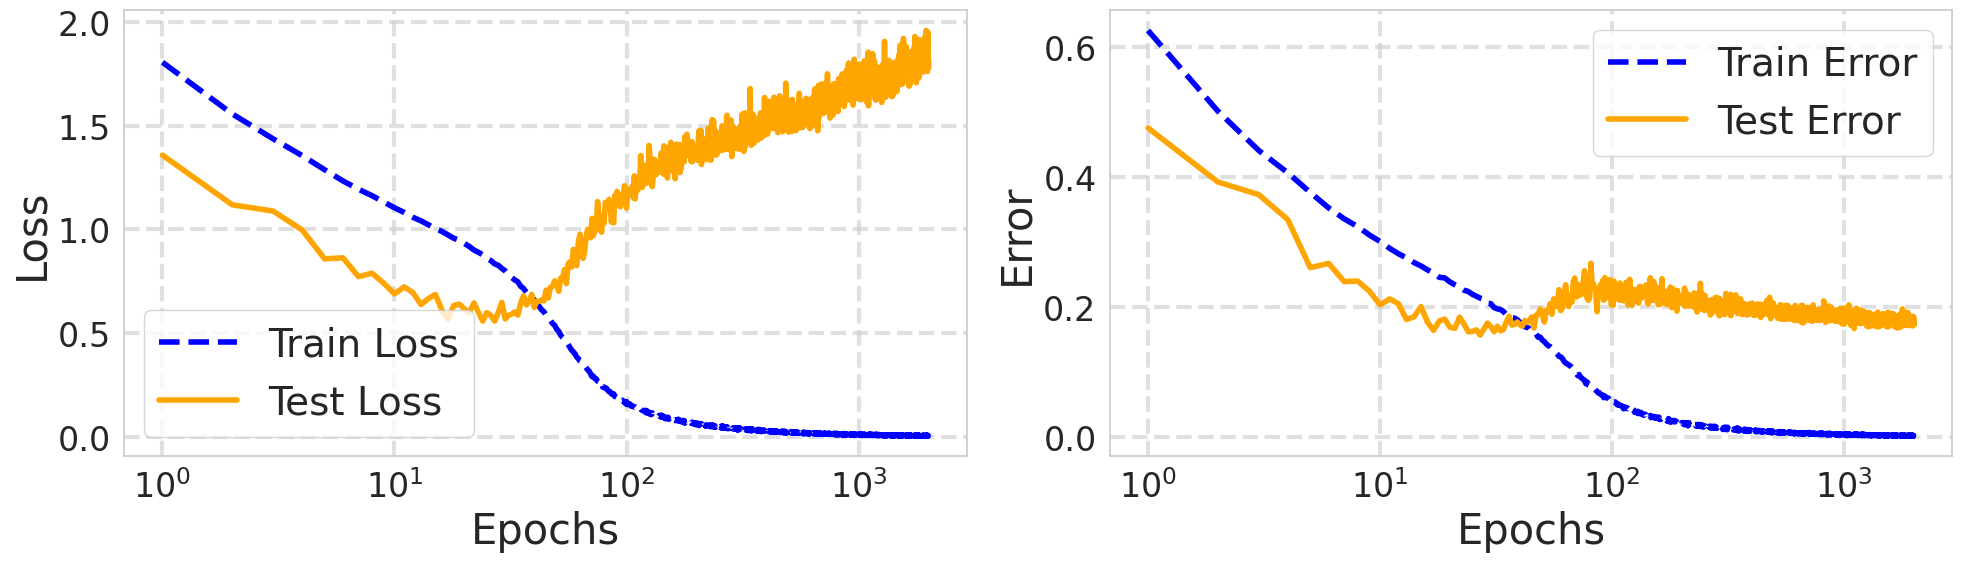

In [536]:
plot_simple_train_test_metrics(df_train, df_test, interpolation_threshold=None, xlabel="epochs", title=f"(PreActResNet18(k=45) - CIFAR10 (20% label noise & data augmentation))")

In [537]:
net = "PreActResNet18"
file_base_name = 'PreActResNet18_k64_cifar10_020noise_da_256bs'
dataframes = load_data_from_files(file_base_name, drive_path, net)

df_train = dataframes["train"]
df_test = dataframes["test"]

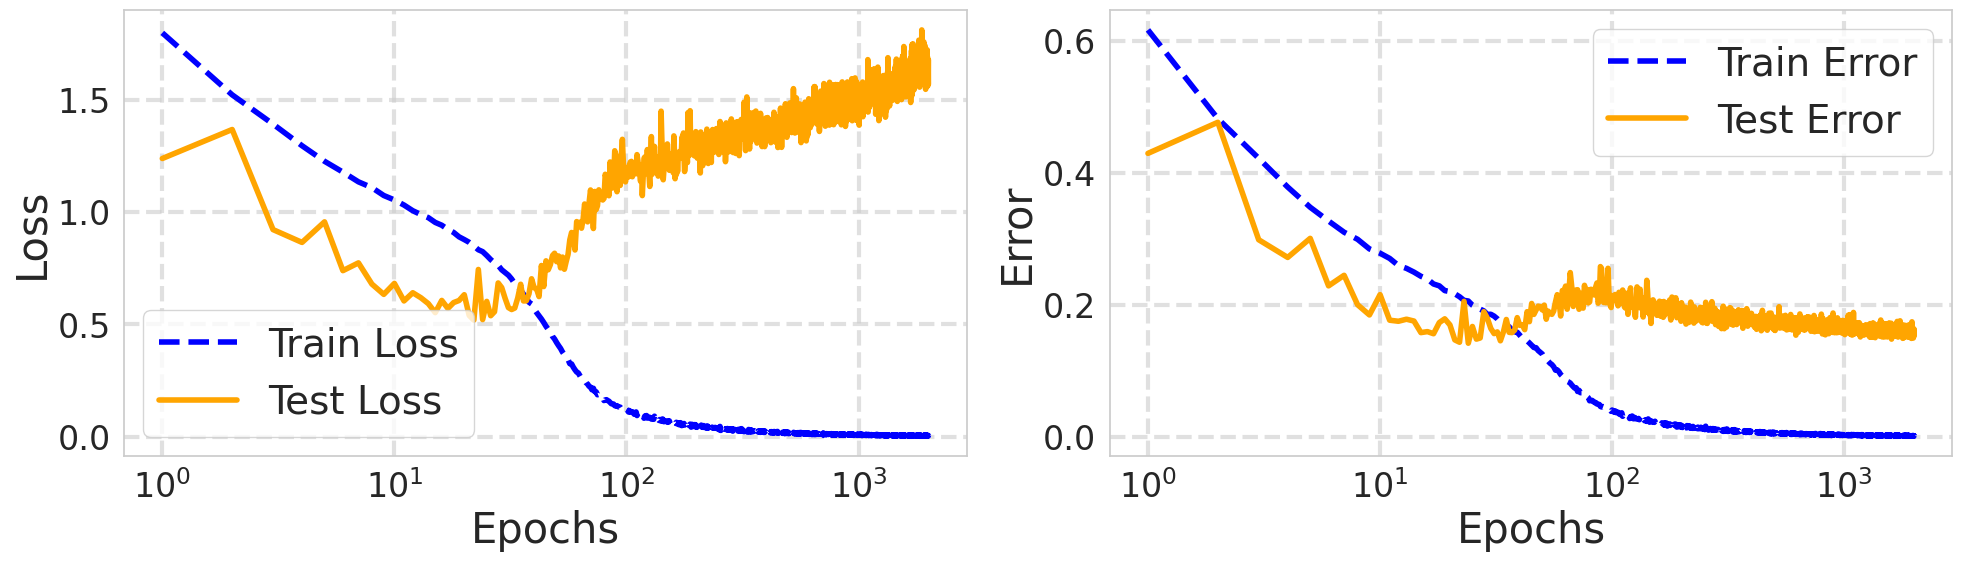

In [538]:
plot_simple_train_test_metrics(df_train, df_test, interpolation_threshold=None, xlabel="epochs", title=f"(PreActResNet18(k=64) - CIFAR10 (20% label noise & data augmentation))")

In [539]:
file_base_name1 = 'PreActResNet18_k45_cifar10_020noise_da_256bs'
dataframes1 = load_data_from_files(file_base_name1, drive_path, net)

file_base_name2 = 'PreActResNet18_k64_cifar10_020noise_da_256bs'
dataframes2 = load_data_from_files(file_base_name2, drive_path, net)

df_train1 = dataframes1["train"]
df_test1 = dataframes1["test"]
df_train2 = dataframes2["train"]
df_test2 = dataframes2["test"]

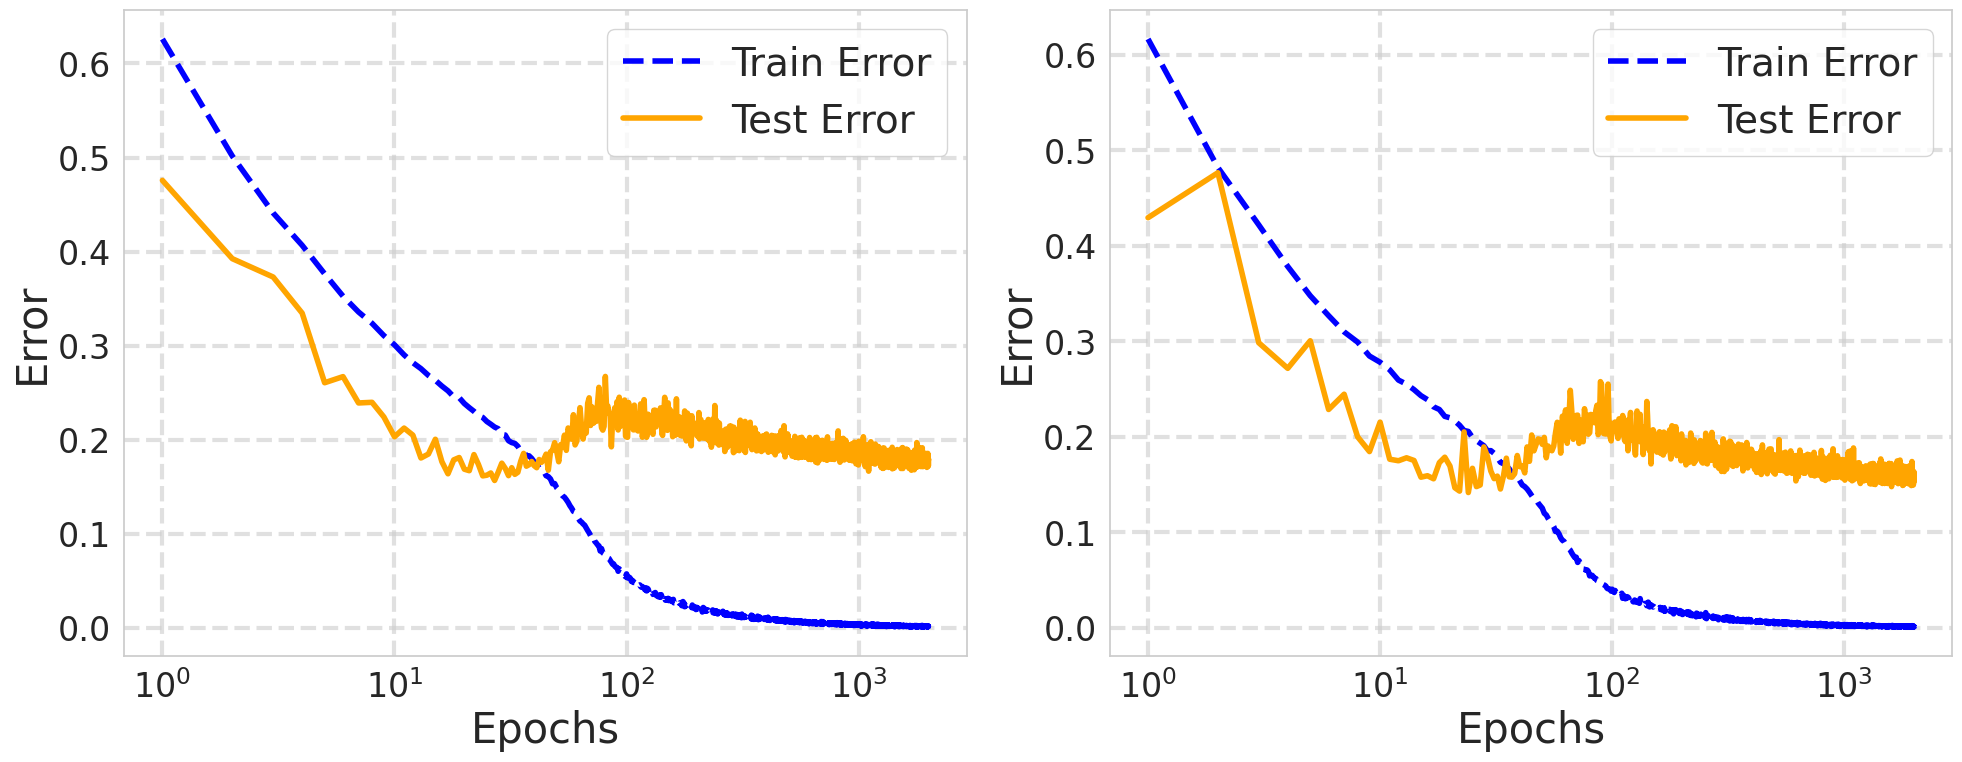

In [540]:
sns.set(style="whitegrid", context="notebook", font_scale=1.6)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

datasets = [
    (df_train1, df_test1, "PreActResNet18(k=45)"),
    (df_train2, df_test2, "PreActResNet18(k=64)")
]

for ax, (df_train, df_test, net_title) in zip(axes, datasets):
    ax.plot(df_train["epochs"], df_train["train_error"], label="Train Error", color='blue', linestyle="--", linewidth=4)
    ax.plot(df_test["epochs"], df_test["test_error"], label="Test Error", color='orange', linewidth=4)

    ax.set_xscale('log')
    ax.set_xlabel("Epochs", fontsize=30)
    ax.set_ylabel("Error", fontsize=30)

    # ax.set_title(net_title, fontsize=35)
    ax.legend(fontsize=28, loc="best")
    ax.grid(True, linestyle='--', alpha=0.6, linewidth=3)
    ax.tick_params(axis='both', labelsize=24)

# fig.suptitle("Train and Test error by epochs (PreActResNet18 - CIFAR10 (20% label noise & data augmentation))", fontsize=16, fontweight='bold')

plt.subplots_adjust(wspace=0.3, top=0.85)
plt.tight_layout()
plt.show()

## **CIFAR10 (augmented)**

In [541]:
file_base_name = 'preActResNet_cifar10augmented_020noise_noda_256bs'
dataframes = load_data_from_files(file_base_name, drive_path, net)

df_train = dataframes["train"]
df_test = dataframes["test"]

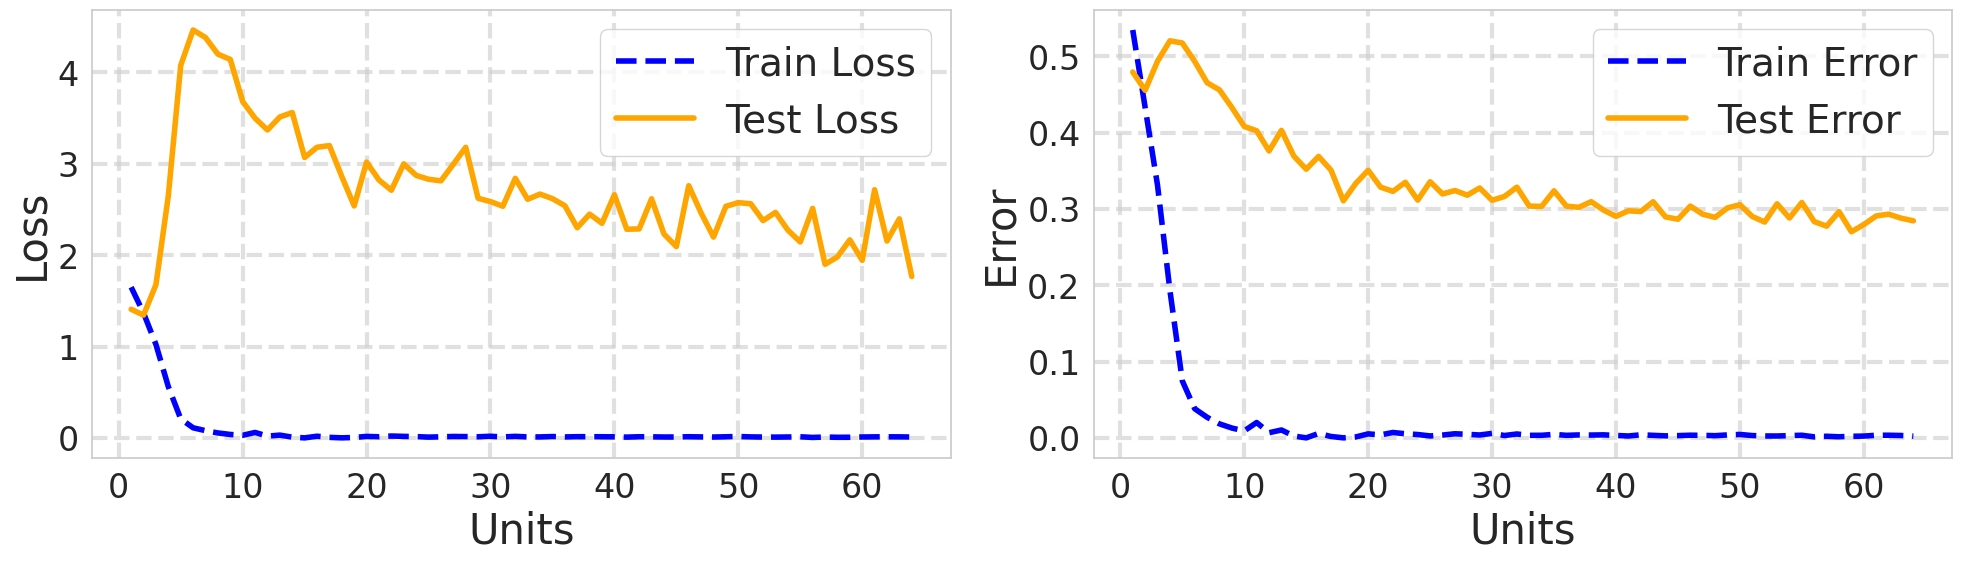

In [542]:
epoch = 200
df_train_filtered, df_test_filtered = filter_by_epoch(df_train, df_test, epoch)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="units", title="(PreActResNet18, CIFAR10 (Augmented & 20% label noise))")

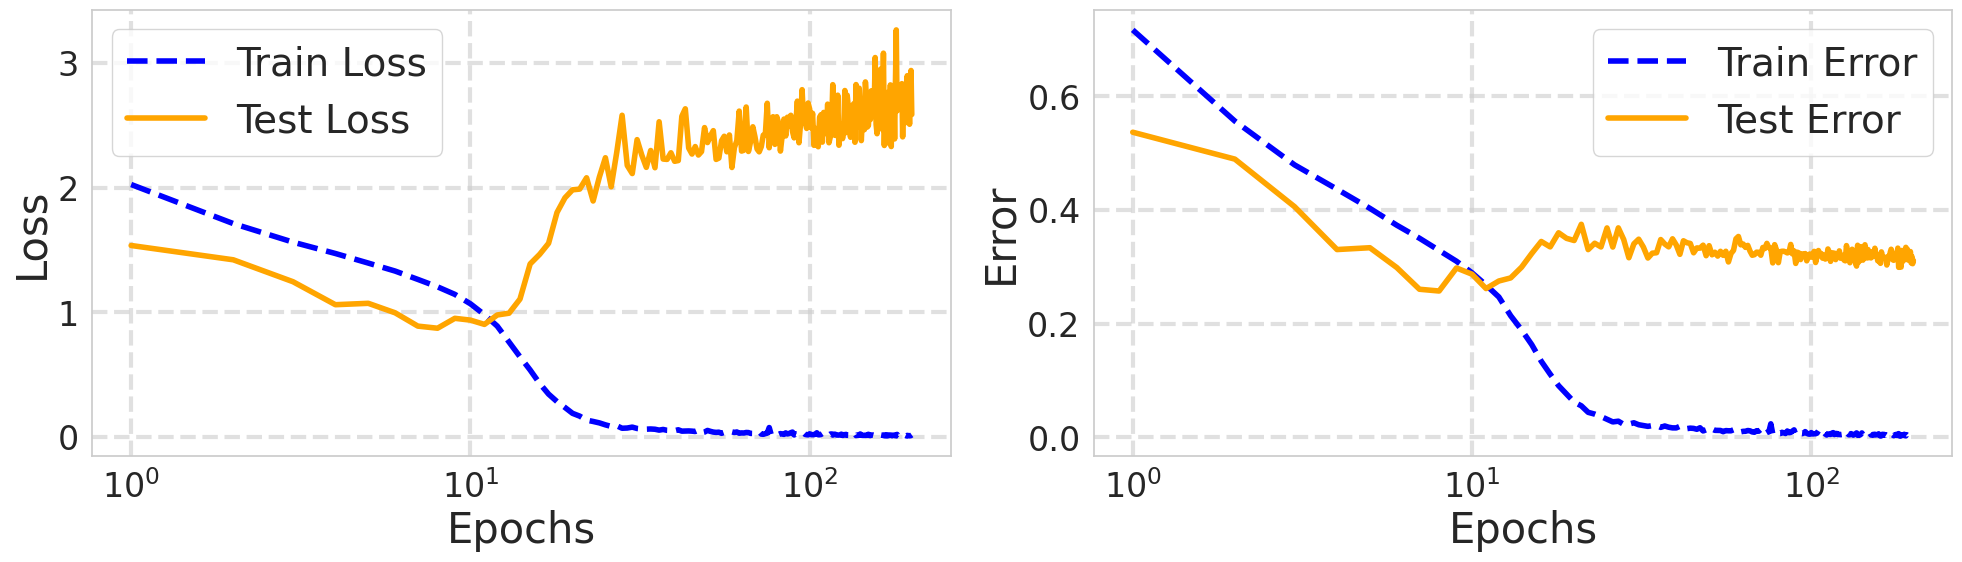

In [543]:
model = 30
df_train_filtered, df_test_filtered = filter_by_model(df_train, df_test, model)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="epochs", title=f"(PreActResNet18(k={model}) - CIFAR10 (Augmented & 20% label noise))")

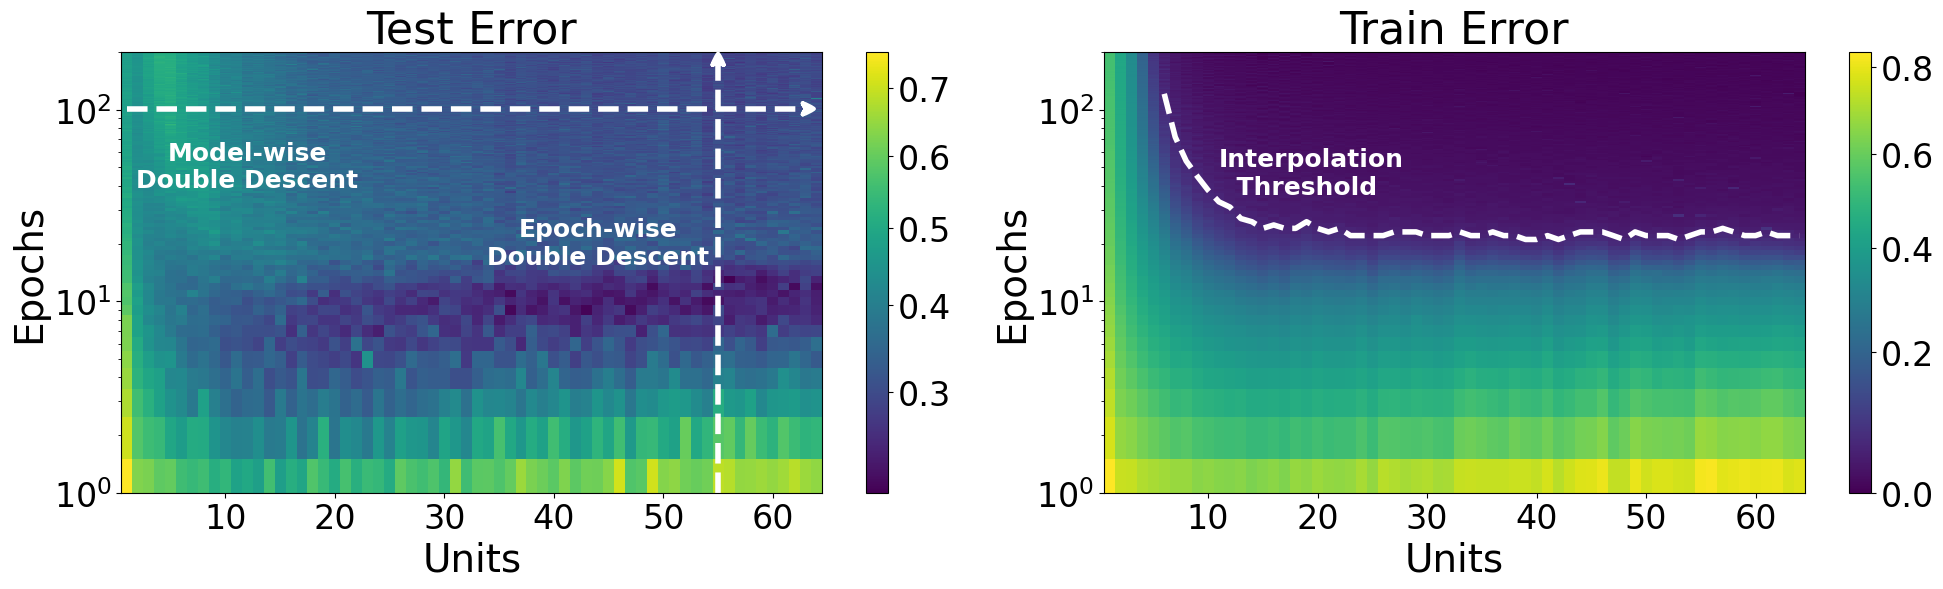

In [544]:
plot_train_test_error_heatmap(df_train, df_test, threshold_value=0.05, colormap="viridis", gamma=0.8, xlabel="Units", ylabel="Epochs", title="(PreActResNet18, CIFAR10 (Augmented & 20% label noise))")

## **CIFAR100**

In [545]:
file_base_name = 'preActResNet_cifar100_020noise_noda_256bs'
dataframes = load_data_from_files(file_base_name, drive_path, net)

df_train = dataframes["train"]
df_test = dataframes["test"]

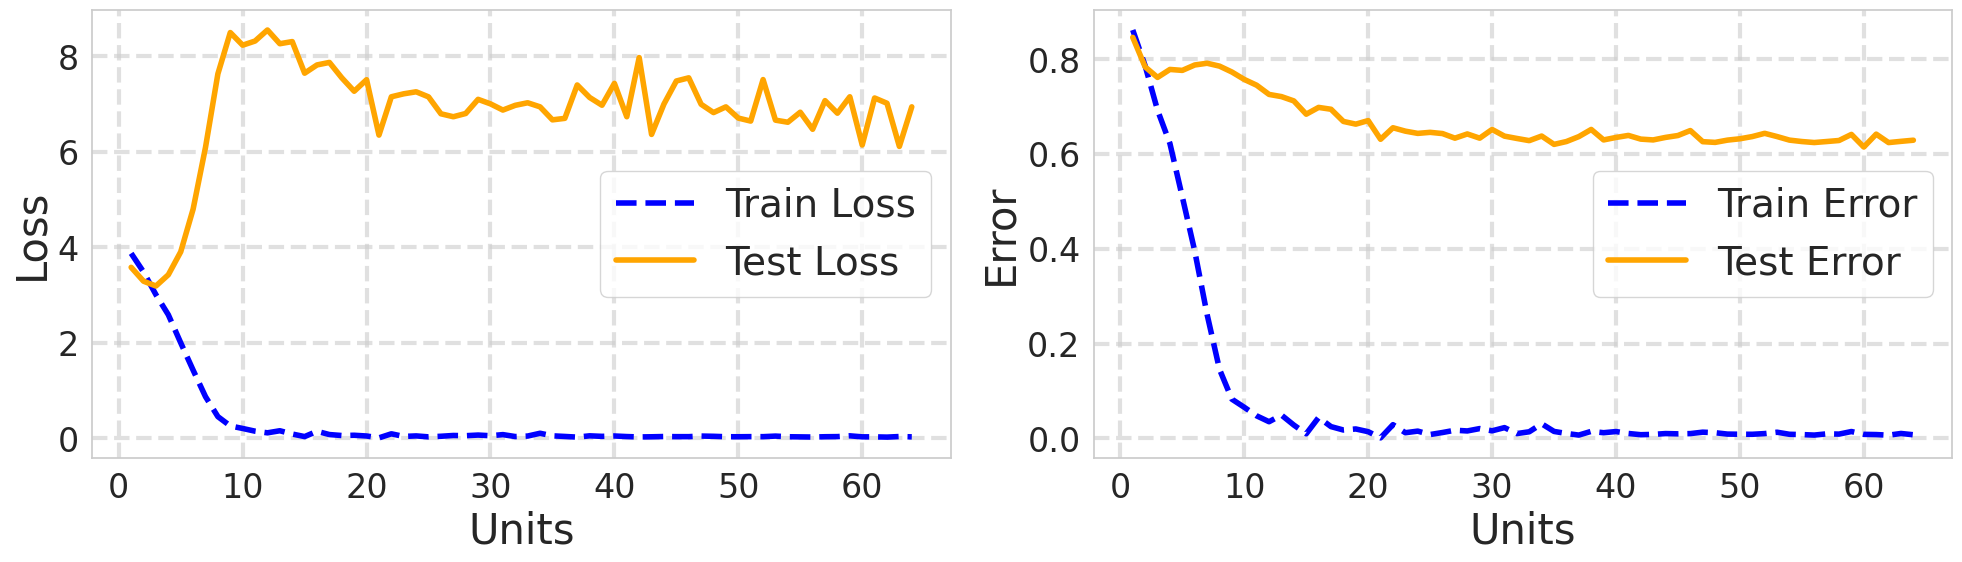

In [546]:
epoch = 100
df_train_filtered, df_test_filtered = filter_by_epoch(df_train, df_test, epoch)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="units", title="(PreActResNet18, CIFAR100 (20% label noise))")

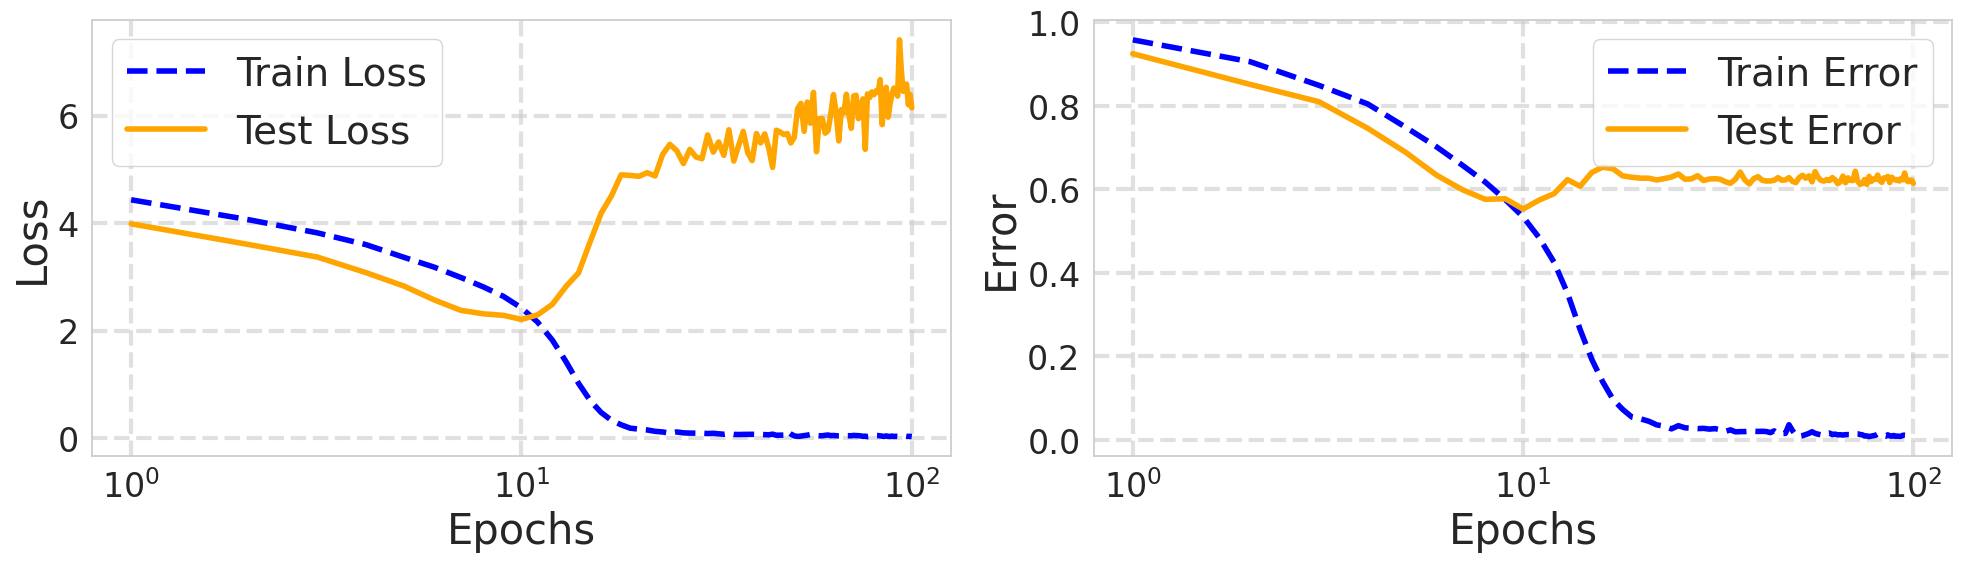

In [547]:
model = 60
df_train_filtered, df_test_filtered = filter_by_model(df_train, df_test, model)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="epochs", title=f"(PreActResNet18(k={model}) - CIFAR100 (20% label noise))")

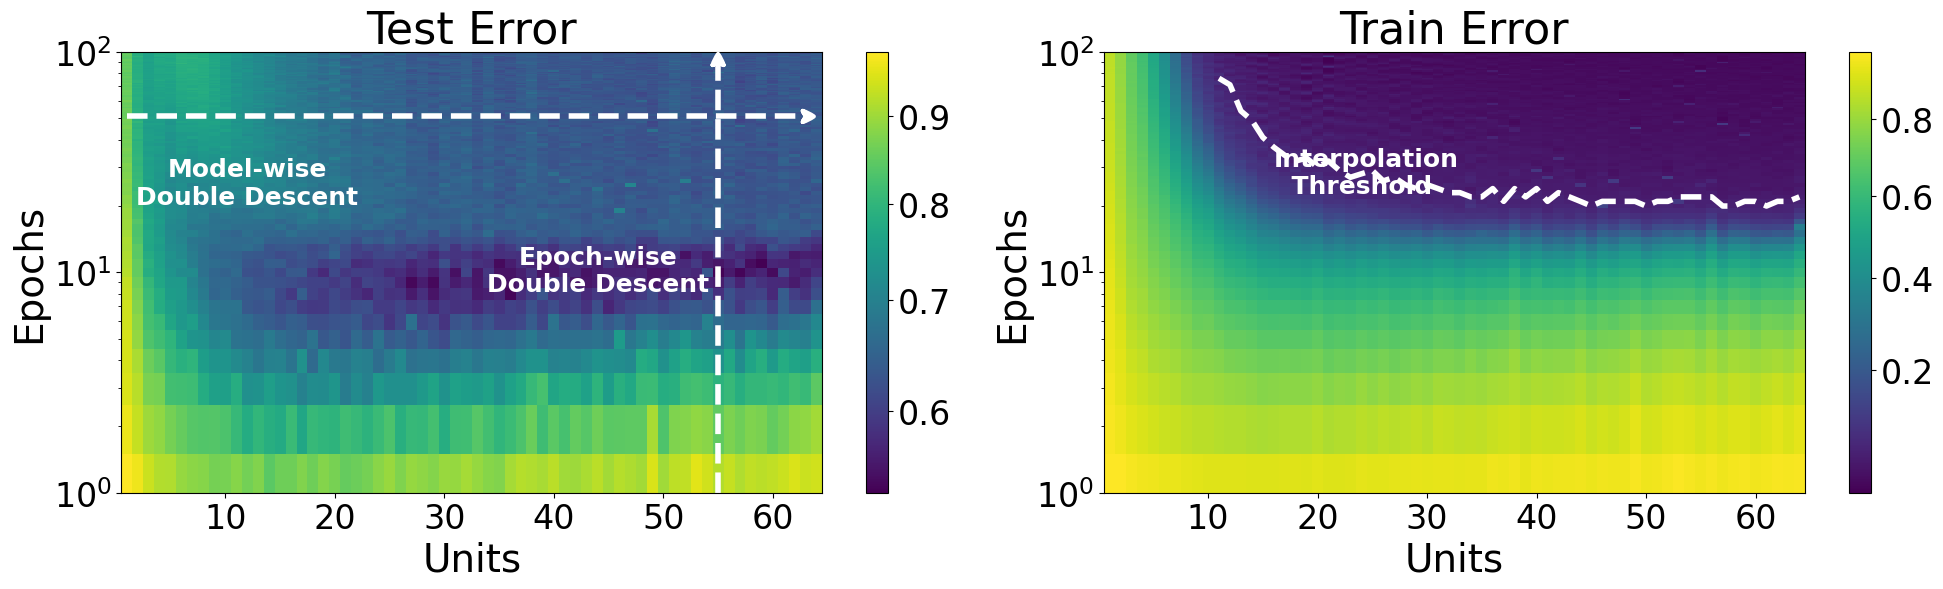

In [548]:
plot_train_test_error_heatmap(df_train, df_test, threshold_value=0.05, colormap="viridis", gamma=0.8, xlabel="Units", ylabel="Epochs", title="(PreActResNet18, CIFAR100 (20% label noise))")

## **CIFAR100 (augmented)**

In [549]:
file_base_name = 'preActResNet_cifar100augmented_020noise_noda_256bs'
dataframes = load_data_from_files(file_base_name, drive_path, net)

df_train = dataframes["train"]
df_test = dataframes["test"]

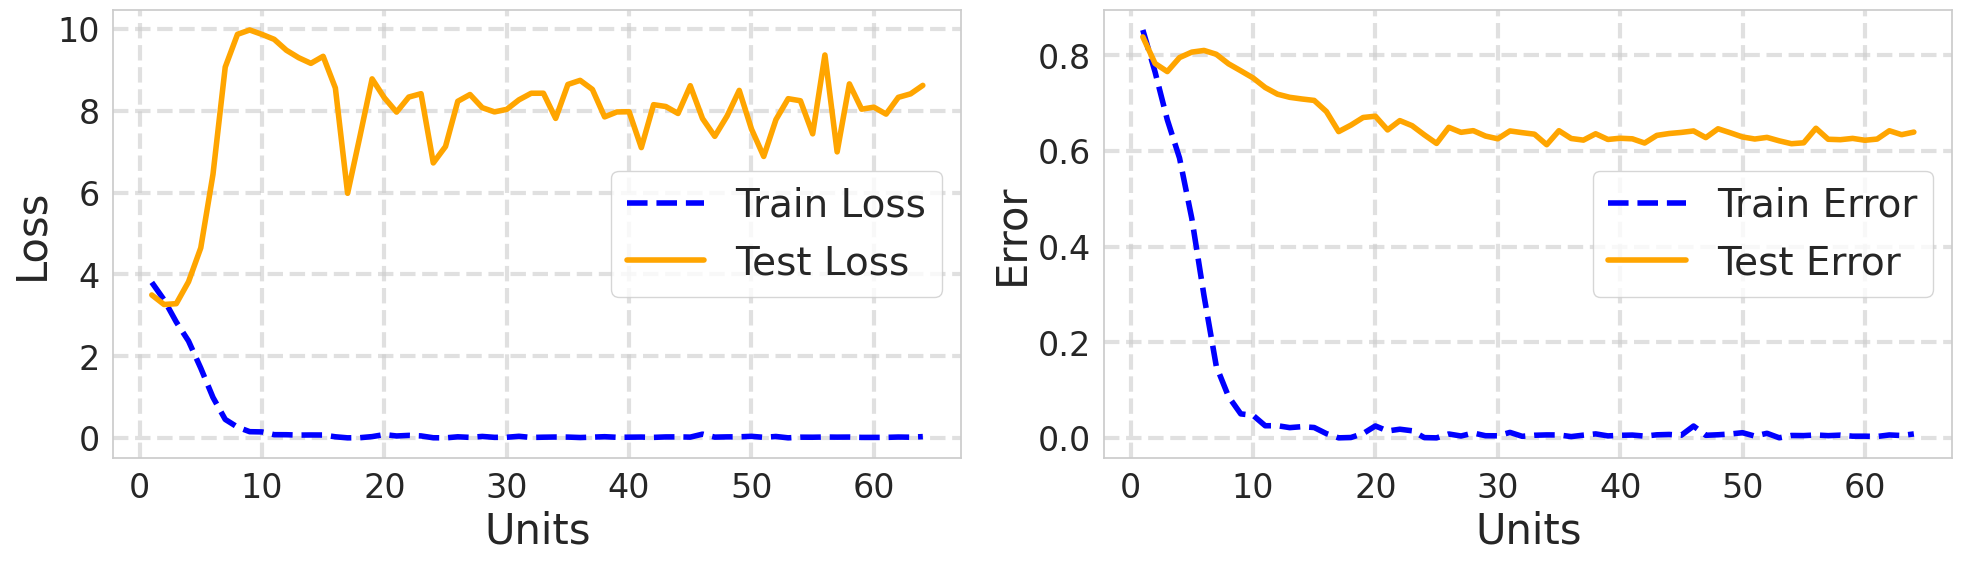

In [550]:
epoch = 200
df_train_filtered, df_test_filtered = filter_by_epoch(df_train, df_test, epoch)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="units", title="(PreActResNet18, CIFAR100 (Augmented & 20% label noise))")

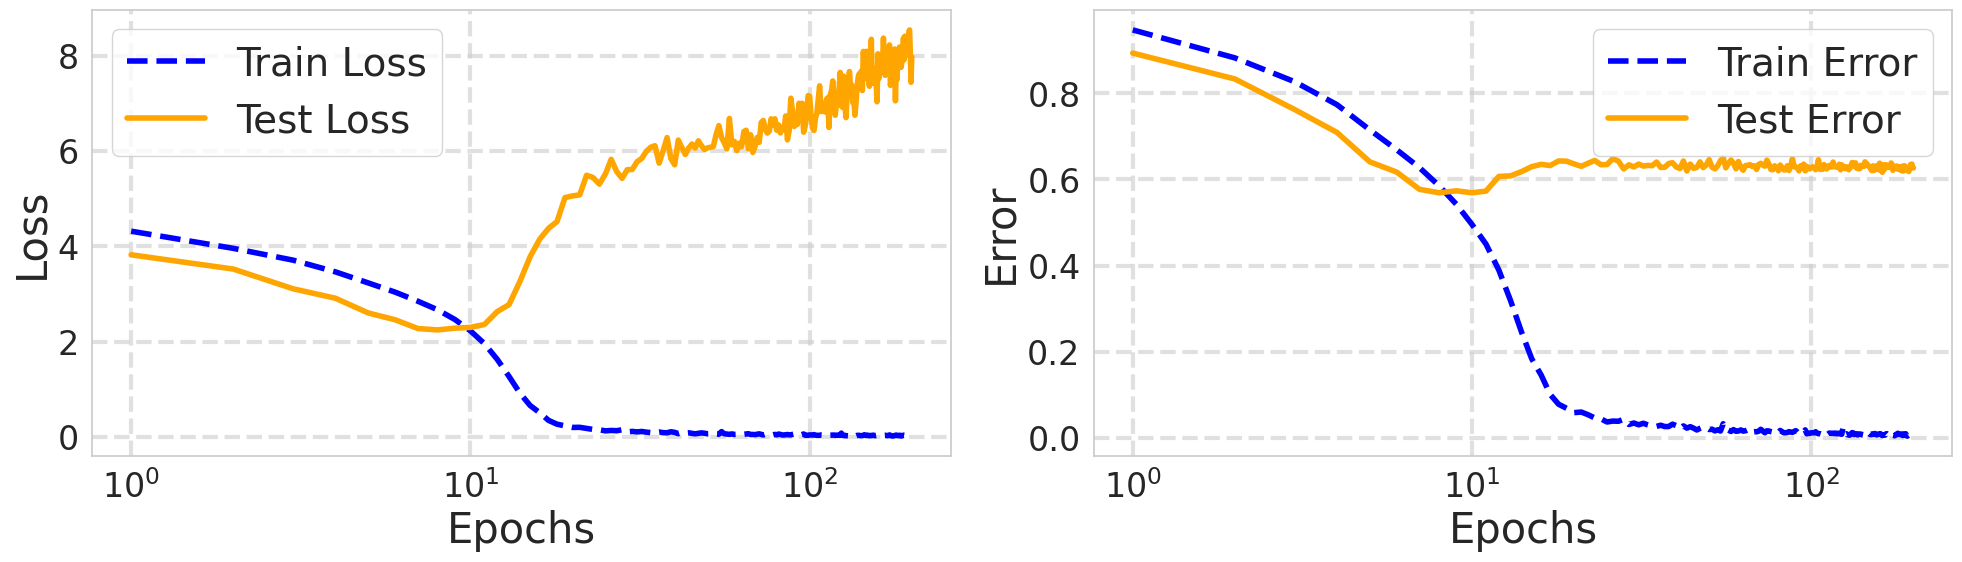

In [551]:
model = 40
df_train_filtered, df_test_filtered = filter_by_model(df_train, df_test, model)
plot_simple_train_test_metrics(df_train_filtered, df_test_filtered, interpolation_threshold=None, xlabel="epochs", title=f"(PreActResNet18(k={model}) - CIFAR100 (Augmented & 20% label noise))")

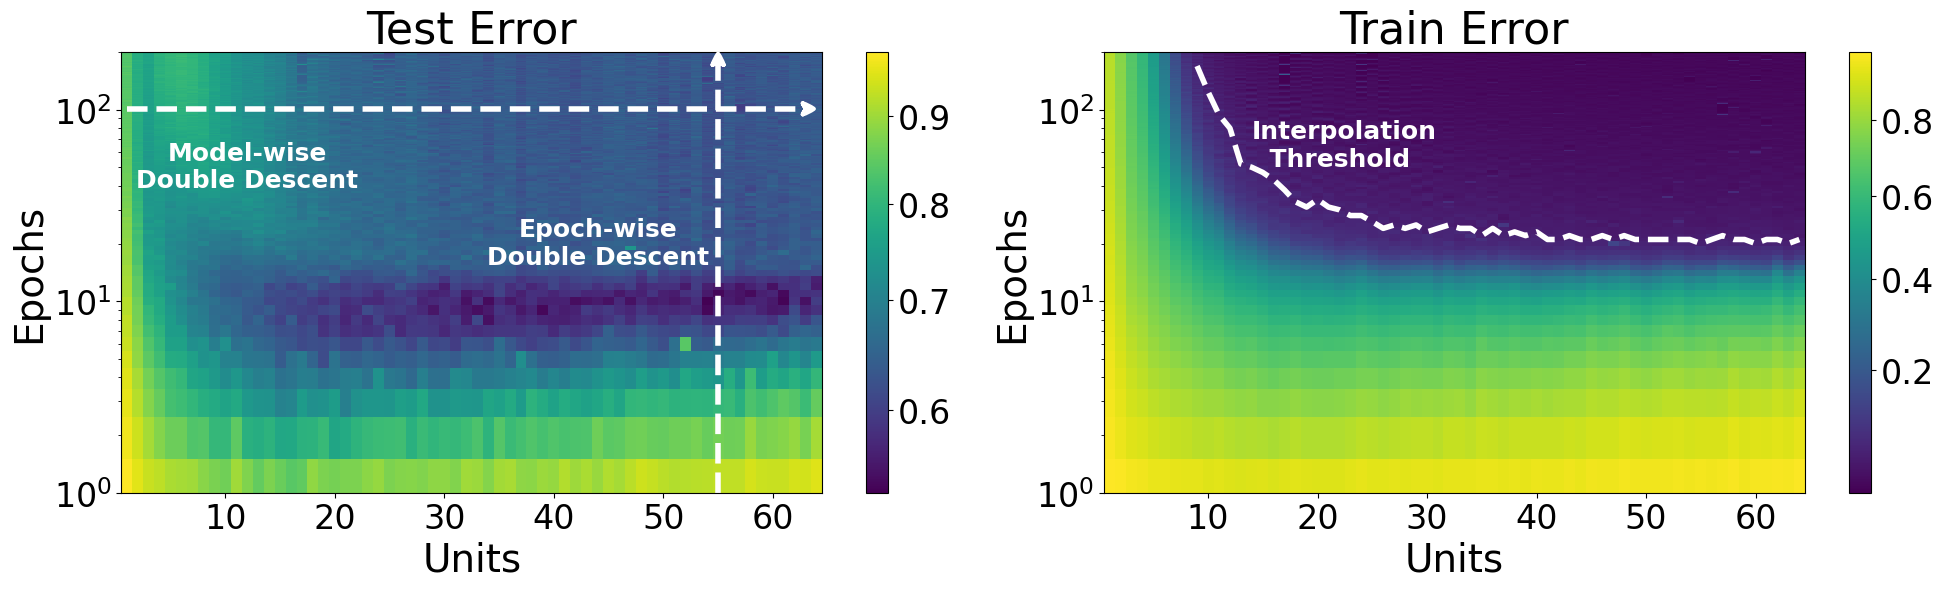

In [552]:
plot_train_test_error_heatmap(df_train, df_test, threshold_value=0.05, colormap="viridis", gamma=0.8, xlabel="Units", ylabel="Epochs", title="(PreActResNet18, CIFAR100 (Augmented & 20% label noise))")